In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

import MagellanicStream as ms

import gradfunctions as gfunc


import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [30]:
#########################
### Import fits files ###
#########################

#PARSEC Isochrones
# parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
#                     format='basic', delimiter='\s')

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#LMC r13 data
lmcr13 = fits.getdata('lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

In [3]:
def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

In [4]:
### Circular galactic radius for LMC
x,y,dist = gfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
radius = elliptical_radius(x,y) #np.sqrt(x**2+y**2)
     
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

labels = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
          '[Ca/Fe','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
          '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

labs = np.copy(labels)

In [5]:
# ############################
# ### Set up distributions ###
# ############################

# def linmodl(m,b,x):
#     y = m * x + b
#     return y

# def lnL(theta,x,y,yerr):
#     m, b = theta
#     modl = linmodl(m,b,x)
#     inv_sig2 = np.reciprocal(np.square(yerr))
#     return -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))

# def lnP(theta, *args):
#     m, b = theta
#     if m > 2.0 or m <-2.0:
#         return -np.inf
#     elif b < -3.0 or b > 3.0:
#         return -np.inf
#     return lnL(theta, *args)

In [18]:
#################
### functions ###
#################

import numpy as np
from scipy.optimize import minimize
from scipy.stats import binned_statistic

def mad(dat):
    '''
    Calculate the median absolute deviation (MAD)
    
    Parameters:
    ----------
        dat: array-like object containing data
    
    Returns:
    -------
        dev: MAD(dat)
    '''
    dev = np.median(np.absolute(dat - np.median(dat)))
    return dev

def linmodl(m,b,x):
    '''
    Slope-intercept form of a line
    
    Parameters:
    ----------
        m: slope of line
        x: exog of line
        b: intercept of line
        
    Returns:
    -------
        y: endog of line
    '''
    y = m*x + b
    return y

def lnL(theta,x,y,yerr):
    '''
    Log likelihood for linmodl
    
    Parameters:
    ----------
        theta: parameters to plug into linmodl (m,b)
        x: exog of line
        y: endog of line
        yerr: endog error
    
    Returns:
    -------
        lnl: log likelihood 
    '''
    
    m, b = theta
    modl = linmodl(m,b,x)
    inv_sig2 = np.reciprocal(np.square(yerr))
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

def mle_fit(exog,endog,endog_err):
    '''
    Do a MLE fit of median abundances as function (y = mx + b) of radius
    using unbinned data
    
    Parameters:
    ----------
        exog: radii for stars
        endog: abundances for stars
        endog_err: errors in abund
    Returns:
    -------
        med_m: slope of line fit
        med_b: intercept of line fit
    '''
    
    #Calculate bins
    bins = np.arange(np.floor(np.min(exog)),np.ceil(np.max(exog)),1.0) 
    
    #Calcuradius[cln]late median value for each bin
    bin_stats, _, _ = binned_statistic(exog,endog,statistic='median',bins=bins)
    
    #Calculate spread (MAD) in values in each bin
    bin_stats_err, _, _ = binned_statistic(exog,endog,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                           bins=bins)
    
    
    #Initialize MLE calculation
    med_exog = np.arange(len(bin_stats))+0.5
    med_endog = bin_stats
    med_endog_err = bin_stats_err
    
    med_m_guess = (bin_stats[1]-bin_stats[0])/(med_exog[1]-med_exog[0])
    med_b_guess = bin_stats[0]
    
    # minimize MLE and find slopes and intercepts
    nll = lambda *args: -lnL(*args)
    med_guess = np.array([med_m_guess, med_b_guess])
    med_soln = minimize(nll, med_guess, args=(med_exog, med_endog, med_endog_err))
    med_m_ml, med_b_ml = med_soln.x
    
    return med_m_ml, med_b_ml


## Intial Median MLE Fit

In [19]:
# from scipy.optimize import minimize
# from scipy.stats import binned_statistic

# med_m = []
# med_b = []

# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     # clean up data
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))

#     exog = radius[cln]
#     endog = r13[elems[i]][cln]
#     bins = np.arange(np.floor(np.min(exog)),np.ceil(np.max(exog)),1.0)
    
#     # calculate 
#     bin_stats, bin_edges, binnumber = binned_statistic(exog,endog,statistic='median',
#                                                        bins=bins)
    
#     # get mads for medians calculated above
#     bin_stats_err, _, _ = binned_statistic(exog,endog,statistic=lambda y: gfunc.mad(y),
#                                            bins=bins)
    
#     # initialize MLE calculation
#     med_m_guess = 0.0 
#     med_b_guess = bin_stats[0]

#     med_exog = np.arange(len(bin_stats))+0.5
#     med_endog = bin_stats
#     med_endog_err = bin_stats_err

#     # minimize MLE and find slopes and intercepts
#     nll = lambda *args: -lnL(*args)
#     med_guess = np.array([med_m_guess, med_b_guess])
#     med_soln = minimize(nll, med_guess, args=(med_exog, med_endog, med_endog_err))
#     med_m_ml, med_b_ml = med_soln.x
    
#     med_m.append(med_m_ml)
#     med_b.append(med_b_ml)

## Initial Fit 

In [20]:
##############################
### Fit Overall Trendlines ###
##############################

med_ms = []
med_bs = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    
    # fit data
    slope, inter = mle_fit(radius[cln],r13[elems[i]][cln],r13[elems_err[i]][cln])
    med_ms.append(slope)
    med_bs.append(inter)

In [21]:
print(med_ms)
print(med_bs)

[-0.04153015891235224, -0.021645882837647727, -0.011900163840700726, 0.0026522517256463026, -0.004128804766382723, 0.007068154995398838, -0.011864690951180014, 0.004031126432336423, 0.03311875692220101, 0.01674321670549326, 0.0213491487794348, -0.0012811305496080595, 0.02003802990169195, 0.030639034970136824, -0.0035704486953474883, -0.0061964759586570824, -0.024966181738259426, -0.03743413201474323, -0.00487559087365151, 0.0005592841167043657, 0.04166866914454615]
[-0.5888352344915108, -0.2741163476203498, 0.14726686916043882, 0.024019096566133012, -0.1724769493491439, 0.08238739084835342, -0.3125384583784591, -0.010772658548327993, -0.013642700356590202, 0.14056169522817957, -0.05997934716035616, 0.10537909834514368, -0.1330936195833684, -0.16678681097727285, -0.10368812353172524, 0.062029662803432264, -0.016230465853255847, -0.5943873092902547, -0.12977738119332616, -0.133664165636279, 0.003822908447429142]


## Find Distance Above or Below Trendline

In [22]:
labels

['[M/H]',
 '[C/Fe]',
 '[N/Fe]',
 '[O/Fe]',
 '[Na/Fe]',
 '[Mg/Fe]',
 '[Al/Fe]',
 '[Si/Fe]',
 '[P/Fe]',
 '[S/Fe]',
 '[K/Fe]',
 '[Ca/Fe',
 '[Ti/FE]',
 '[Ti II/Fe]',
 '[V/Fe]',
 '[Cr/Fe]',
 '[Mn/Fe]',
 '[Fe/H]',
 '[Co/Fe]',
 '[Ni/Fe]',
 '[Cu/Fe]',
 '[Ge/Fe]',
 '[Rb/Fe]',
 '[Ce/Fe]',
 '[Nd/Fe]',
 '[Yb/FE]']

In [11]:
elem_str

NameError: name 'elem_str' is not defined

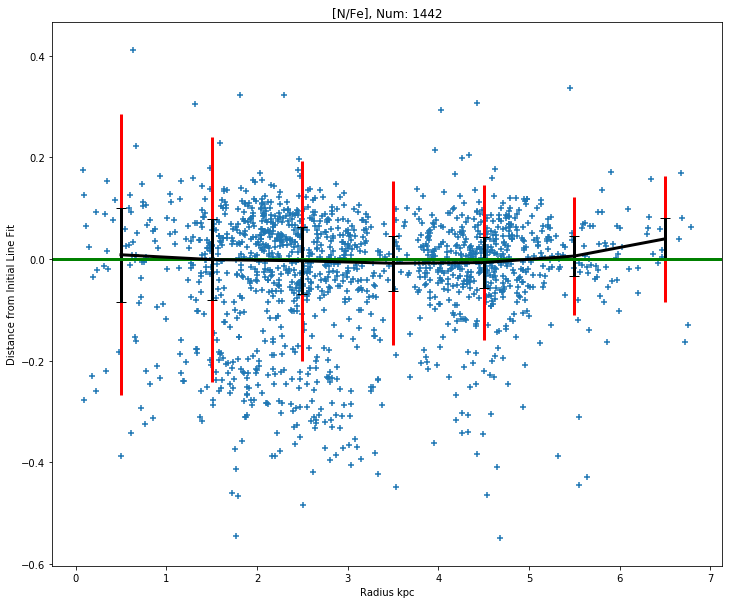

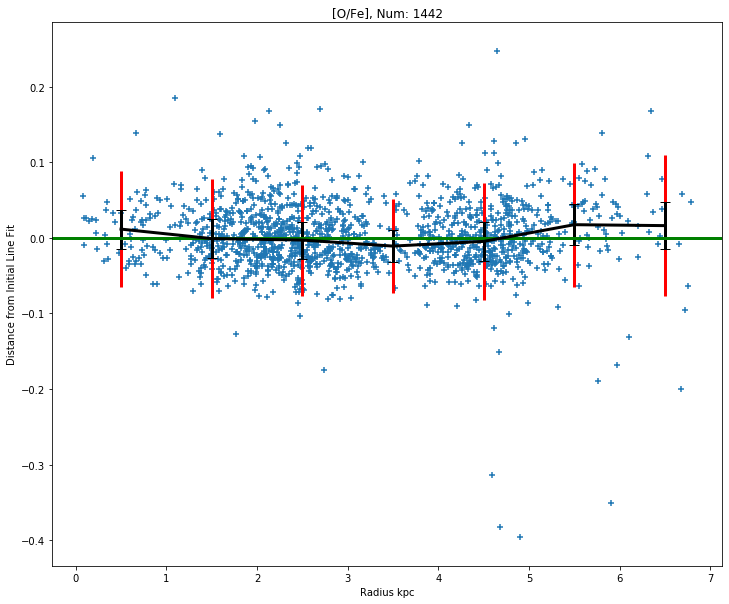

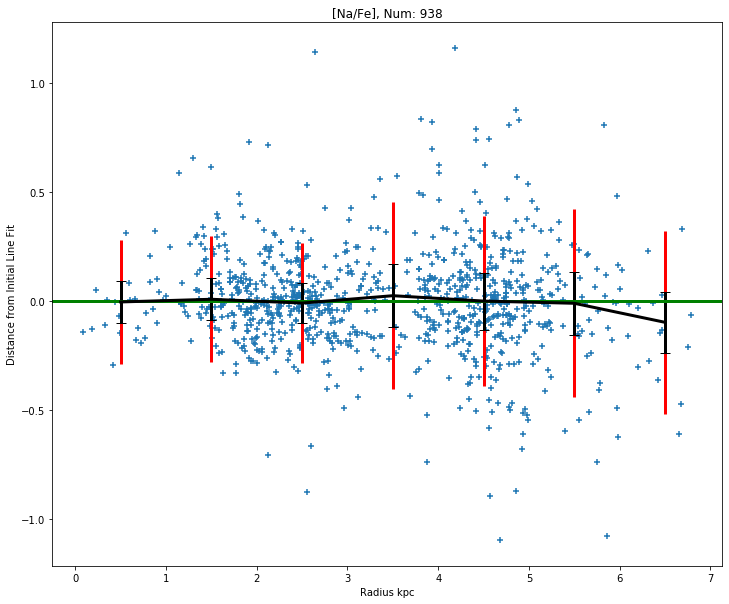

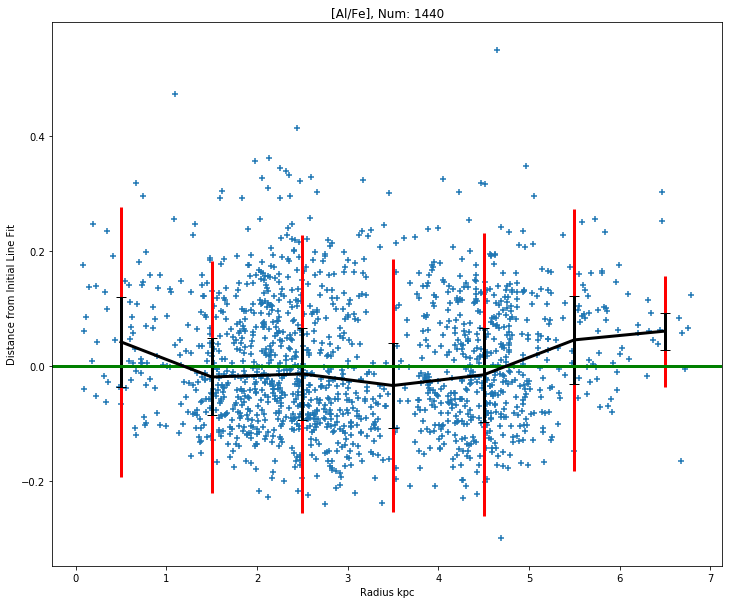

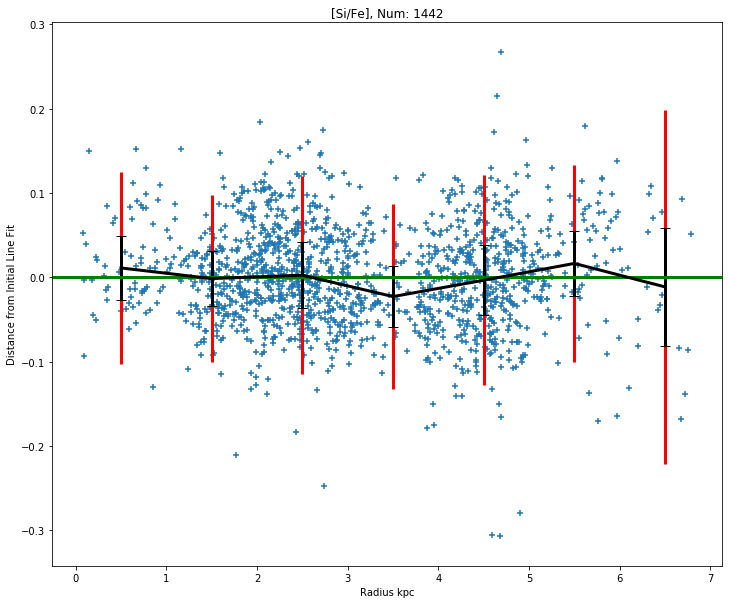

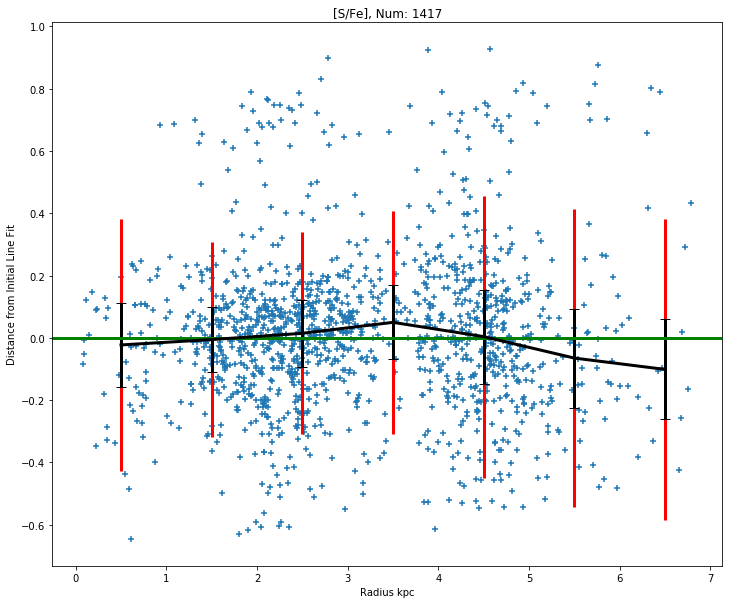

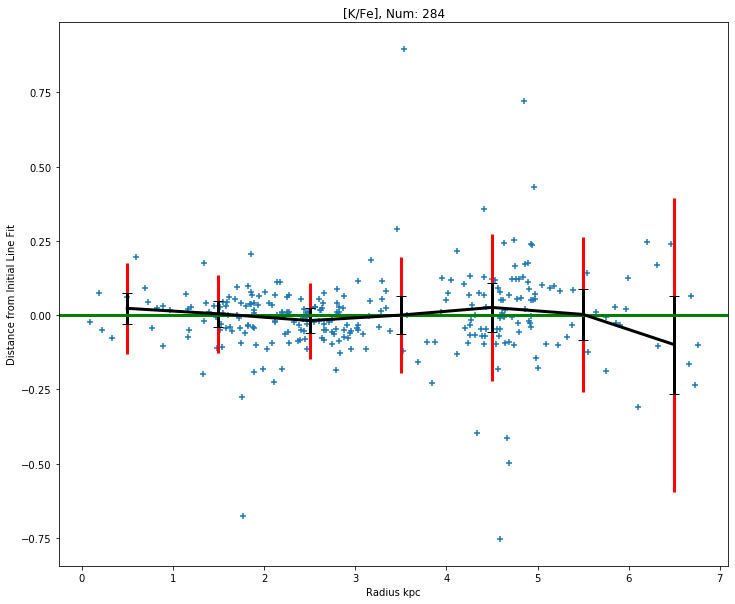

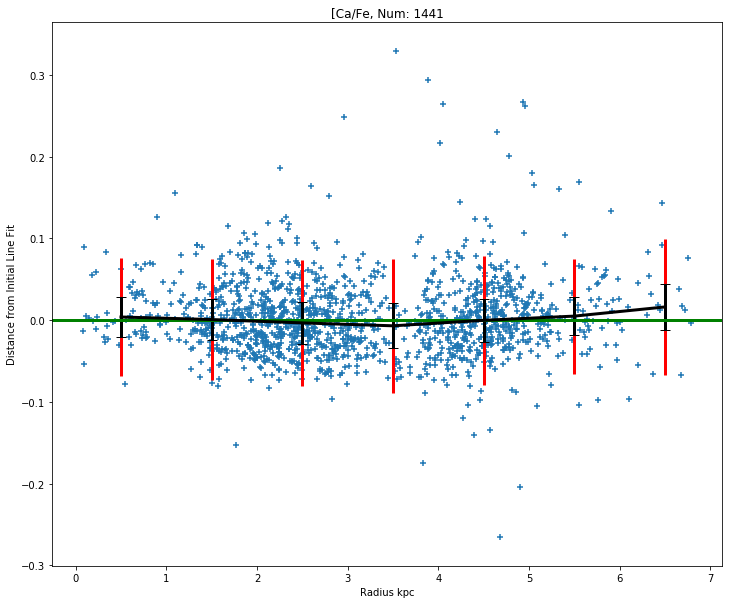

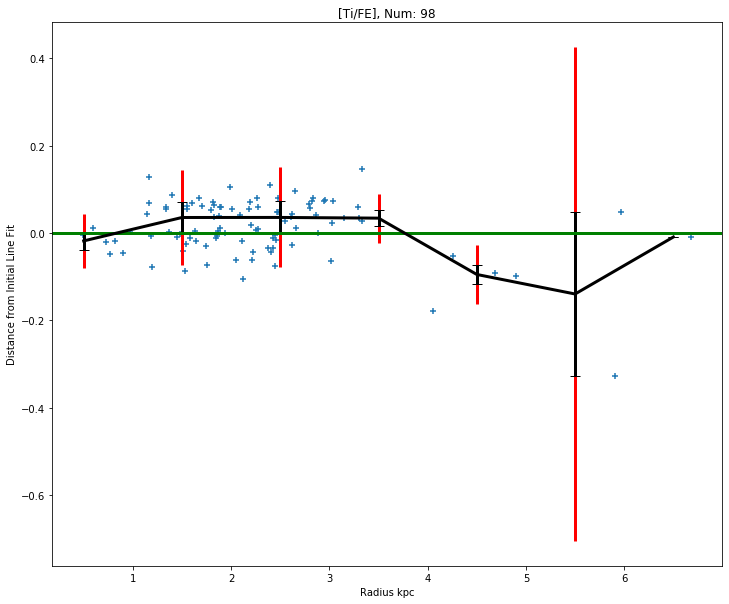

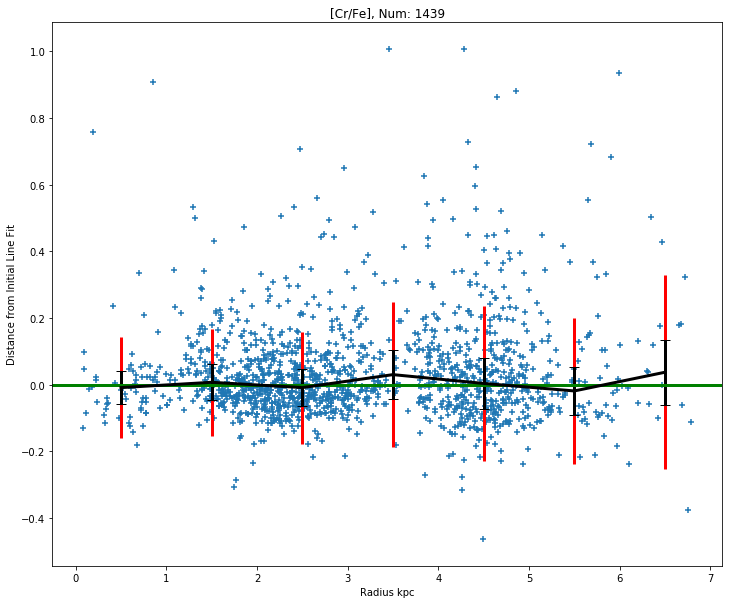

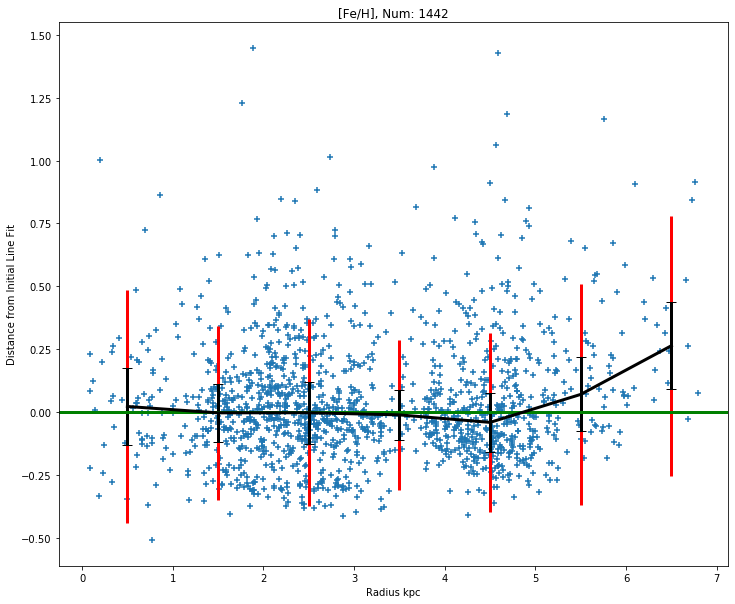

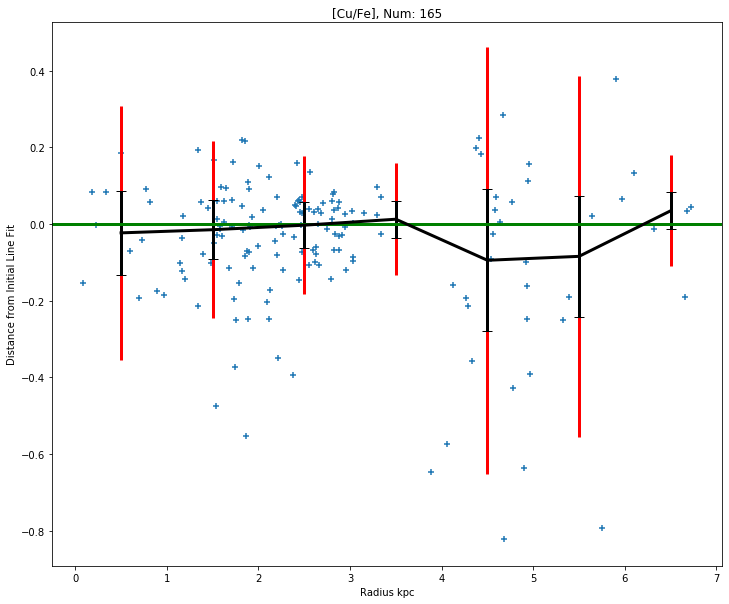

In [23]:
med_elems_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return med_ms[i]*x+med_bs[i]
    
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    plug = trendline(radius[cln])
    dist = plug-r13[elems[i]][cln]
    
    med_elems_dist.append(dist)    
    
#     plt.figure(figsize=[7,7])
#     plt.hist(dist)
#     madsig = gfunc.mad(dist)
#     plt.title(r'{}, Num: {}, MAD: {:.3f}'.format(labs[i],len(np.squeeze(cln)),madsig))
#     plt.axvline(0.,c='k',ls='--')
    
    bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
                     np.ceil(np.max(radius[cln]))+1) 
    bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
    bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                     bins=bins)
    
    plt.figure(figsize=[12,10])
    plt.scatter(radius[cln],dist,marker='+')
    plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=3*bin_spr,c='r',ls='none',lw=3)
    plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=bin_spr,c='k',capsize=5,lw=3)
    plt.axhline(0.0,c='g',lw=3.0)
    plt.title(r'{}, Num: {}'.format(labs[i],len(np.squeeze(cln))))
    plt.xlabel(r'Radius kpc')
    plt.ylabel(r'Distance from Initial Line Fit')
    plt.savefig('outliers{}'.format(elems[i]),bbox_inches='tight')
    plt.show()
    
#     print(len(bins))
#     print(len(bin_dist))
#     print(len(bin_spr))
    
#     #MAD cutoffs
#     plt.axvline(madsig,c='b',ls='--')
#     plt.axvline(-madsig,c='b',ls='--')
#     plt.axvline(2.0*madsig,c='g',ls='--')
#     plt.axvline(-2.0*madsig,c='g',ls='--')
#     plt.axvline(3.0*madsig,c='orange',ls='--')
#     plt.axvline(-3.0*madsig,c='orange',ls='--')
#     plt.axvline(4.0*madsig,c='r',ls='--')
#     plt.axvline(-4.0*madsig,c='r',ls='--')
    
#     plt.show()
    
#     #MAD percentage
#     print('MAD',len(np.squeeze(np.where((dist>-madsig)&(dist<madsig))))/len(np.squeeze(cln)))
#     print('2MAD',len(np.squeeze(np.where((dist>-2.*madsig)&(dist<2.*madsig))))/len(np.squeeze(cln)))
#     print('3MAD',len(np.squeeze(np.where((dist>-3.*madsig)&(dist<3.*madsig))))/len(np.squeeze(cln)))
#     print('4MAD',len(np.squeeze(np.where((dist>-4.*madsig)&(dist<4.*madsig))))/len(np.squeeze(cln)))

In [24]:
mad([1,2,3,4])

1.0

## Median MLE Refit with Pruning

In [25]:
prune_fact = 3.0

re_med_ms = []
re_med_bs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    prune = np.where((r13[elems[i]]>-prune_fact*gfunc.mad(med_elems_dist[i])+
                      np.median(r13[cln][elems[i]]))&
                     (r13[elems[i]]<prune_fact*gfunc.mad(med_elems_dist[i])+
                      np.median(r13[cln][elems[i]])))
    
    # refit pruned data
    re_slope, re_inter = mle_fit(radius[prune],r13[elems[i]][prune],r13[elems_err[i]][prune])
    re_med_ms.append(re_slope)
    re_med_bs.append(re_inter)

In [13]:
# re_med_m = []
# re_med_b = []

# prune_fact = 3.
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     # clean up data and prune outliers
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
#     prune = np.where((r13[elems[i]]>-prune_fact*gfunc.mad(med_elems_dist[i])+
#                       np.median(r13[cln][elems[i]]))&
#                      (r13[elems[i]]<prune_fact*gfunc.mad(med_elems_dist[i])+
#                       np.median(r13[cln][elems[i]])))

#     exog = radius[prune]
#     endog = r13[elems[i]][prune]
#     bins = np.arange(np.floor(np.min(exog)),np.ceil(np.max(exog)),1.0)
    
#     # calculate 
#     bin_stats, bin_edges, binnumber = binned_statistic(exog,endog,statistic='median',
#                                                        bins=bins)
    
#     # get mads for medians calculated above
#     bin_stats_err, _, _ = binned_statistic(exog,endog,statistic=lambda y: gfunc.mad(y),
#                                            bins=bins)
    
#     # initialize MLE calculation
#     med_m_guess = 0.0 
#     med_b_guess = bin_stats[0]

#     med_exog = np.arange(len(bin_stats))+0.5
#     med_endog = bin_stats
#     med_endog_err = bin_stats_err

#     # minimize MLE and find slopes and intercepts
#     nll = lambda *args: -lnL(*args)
#     med_guess = np.array([med_m_guess, med_b_guess])
#     med_soln = minimize(nll, med_guess, args=(med_exog, med_endog, med_endog_err))
#     med_m_ml, med_b_ml = med_soln.x
    
#     re_med_m.append(med_m_ml)
#     re_med_b.append(med_b_ml)

In [14]:
# prune_fact = 3
# for i in tqdm_notebook(range(len(elems)-5),desc='Element'):
    
#     # clean up data and prune outliers
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
#     prune = np.where((r13[elems[i]]>-prune_fact*gfunc.mad(r13[cln][elems[i]])+
#                      np.median(r13[cln][elems[i]]))&
#                     (r13[elems[i]]<prune_fact*gfunc.mad(r13[cln][elems[i]])+
#                      np.median(r13[cln][elems[i]])))
    
#     prune_rads = radius[prune]
#     prune_r13 = r13[prune]
    
#     slps = []
#     ints = []
    
#     # resample with replacement 500 times and fit lines
#     for j in tqdm_notebook(range(500),leave=False,desc='Iteration'):
        
#         ind = np.floor(np.random.random(len(prune_r13))*(len(prune_r13)-1)).astype(int)
#         indr13 = prune_r13[ind]
#         indrads = prune_rads[ind]
        
#         try:
#             # initial guess
#             min_r = np.where(indrads <= 0.5)

#             m_guess = 0.0 
#             b_guess = np.median(indr13[elems[i]][min_r])
            
#             # prep data
#             exog = indrads
#             endog = indr13[elems[i]]
#             endog_err = indr13[elems_err[i]]

#             # minimize negative lnL
#             nll = lambda *args: -lnL(*args)
#             guess = np.array([m_guess, b_guess])
#             soln = minimize(nll, guess, args=(exog, endog, endog_err))
#             m_ml, b_ml = soln.x
        
#             slps.append(m_ml)
#             ints.append(b_ml)
        
#         except:
#             slps.append(-9999.0)
#             ints.append(-9999.0)
    
#     # calculate deviations
#     mdevs.append(gfunc.mad(slps))
#     bdevs.append(gfunc.mad(ints))

## Uncertainties in Slopes and Intercepts

In [26]:
med_m_devs = []
med_b_devs = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    prune = np.where((r13[elems[i]]>-prune_fact*gfunc.mad(med_elems_dist[i])+
                      np.median(r13[cln][elems[i]]))&
                     (r13[elems[i]]<prune_fact*gfunc.mad(med_elems_dist[i])+
                      np.median(r13[cln][elems[i]])))

    exog = radius[prune]
    endog = r13[elems[i]][prune]
    endog_err = r13[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    med_m_devs.append(mad(slps))
    med_b_devs.append(mad(ints))


In [27]:
for i in range(len(re_med_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],re_med_ms[i],med_m_devs[i],
                                                                         re_med_bs[i],med_b_devs[i]))

M_H: slope: -0.0267 +/- 0.0026 inter: -0.6019 +/- 0.0090
C_FE: slope: -0.0186 +/- 0.0019 inter: -0.2719 +/- 0.0069
N_FE: slope: -0.0106 +/- 0.0016 inter: 0.1194 +/- 0.0063
O_FE: slope: -0.0013 +/- 0.0015 inter: 0.0386 +/- 0.0041
NA_FE: slope: 0.0029 +/- 0.0035 inter: -0.1817 +/- 0.0115
MG_FE: slope: 0.0010 +/- 0.0020 inter: 0.1016 +/- 0.0059
AL_FE: slope: -0.0107 +/- 0.0016 inter: -0.3091 +/- 0.0060
SI_FE: slope: 0.0037 +/- 0.0012 inter: -0.0049 +/- 0.0047
P_FE: slope: 0.0263 +/- 0.0045 inter: 0.0285 +/- 0.0148
S_FE: slope: 0.0098 +/- 0.0029 inter: 0.1484 +/- 0.0100
K_FE: slope: 0.0109 +/- 0.0037 inter: -0.0355 +/- 0.0101
CA_FE: slope: -0.0019 +/- 0.0006 inter: 0.1076 +/- 0.0017
TI_FE: slope: 0.0001 +/- 0.0039 inter: -0.1077 +/- 0.0089
TIII_FE: slope: 0.0321 +/- 0.0060 inter: -0.1900 +/- 0.0195
V_FE: slope: -0.0037 +/- 0.0017 inter: -0.0918 +/- 0.0062
CR_FE: slope: -0.0075 +/- 0.0015 inter: 0.0717 +/- 0.0044
MN_FE: slope: -0.0124 +/- 0.0022 inter: -0.0403 +/- 0.0065
FE_H: slope: -0.022

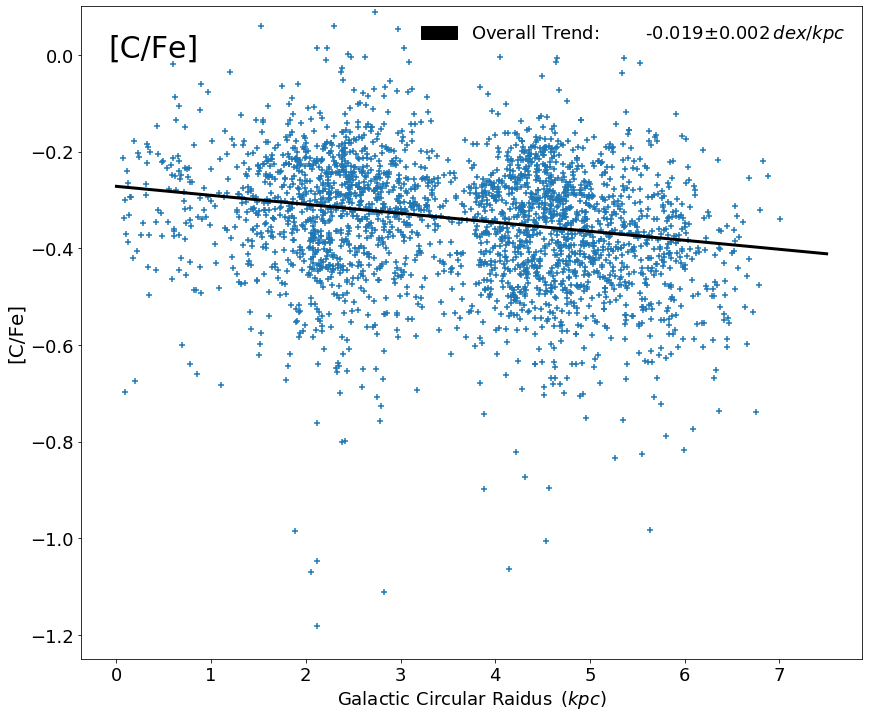

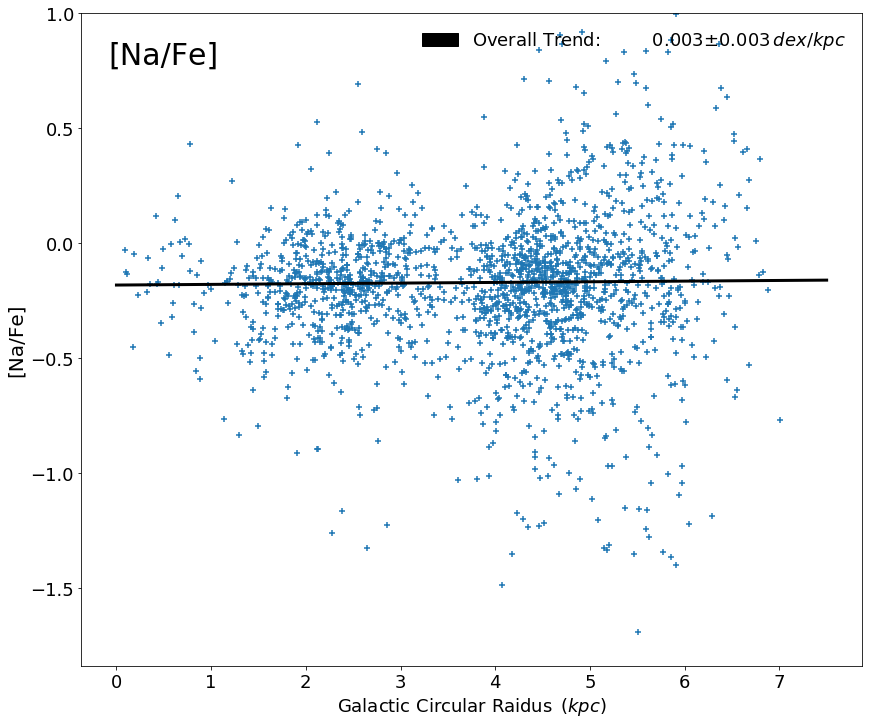

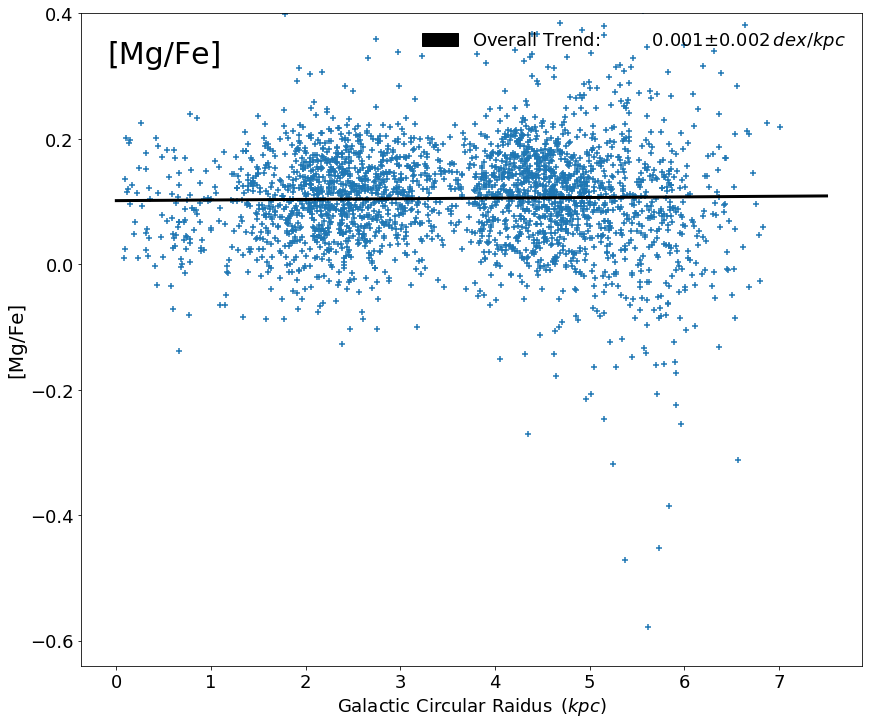

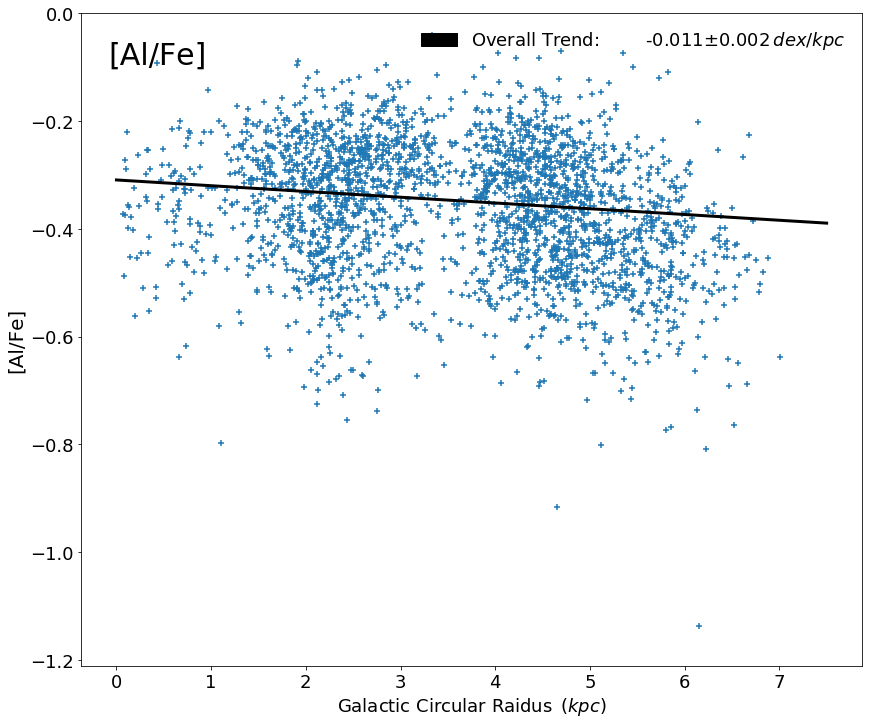

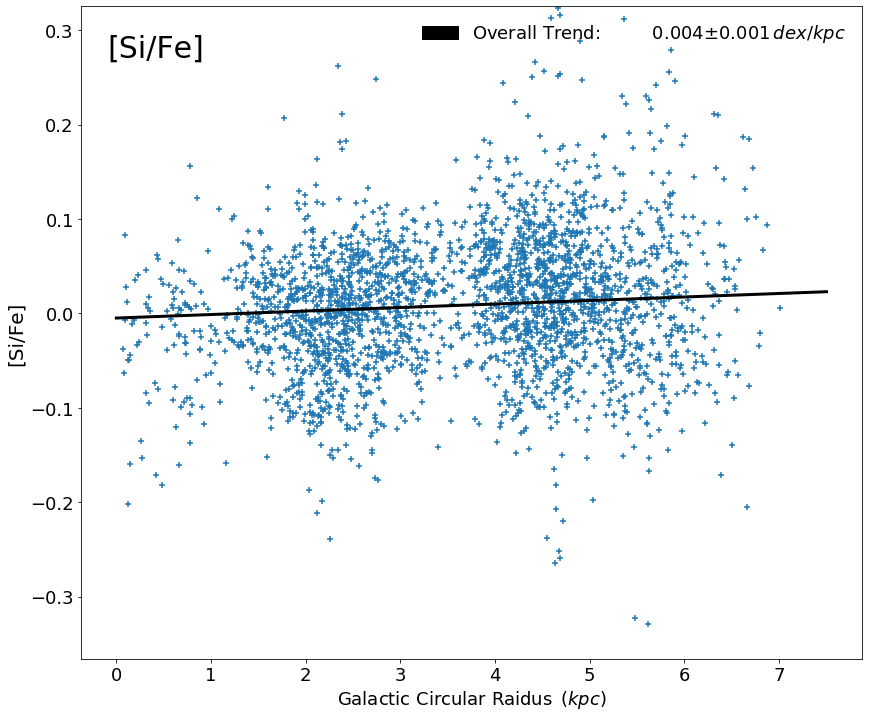

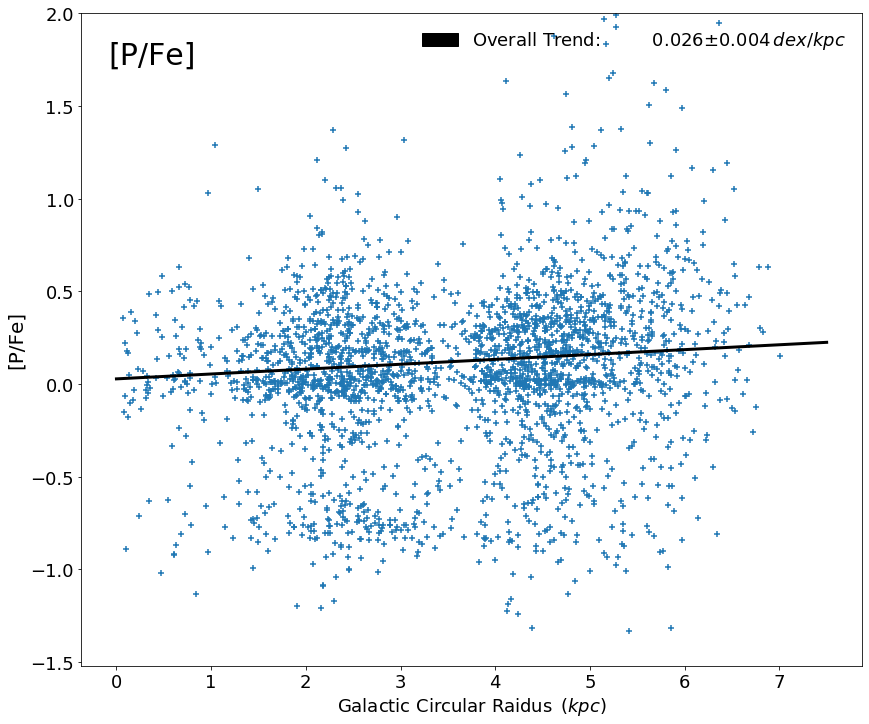

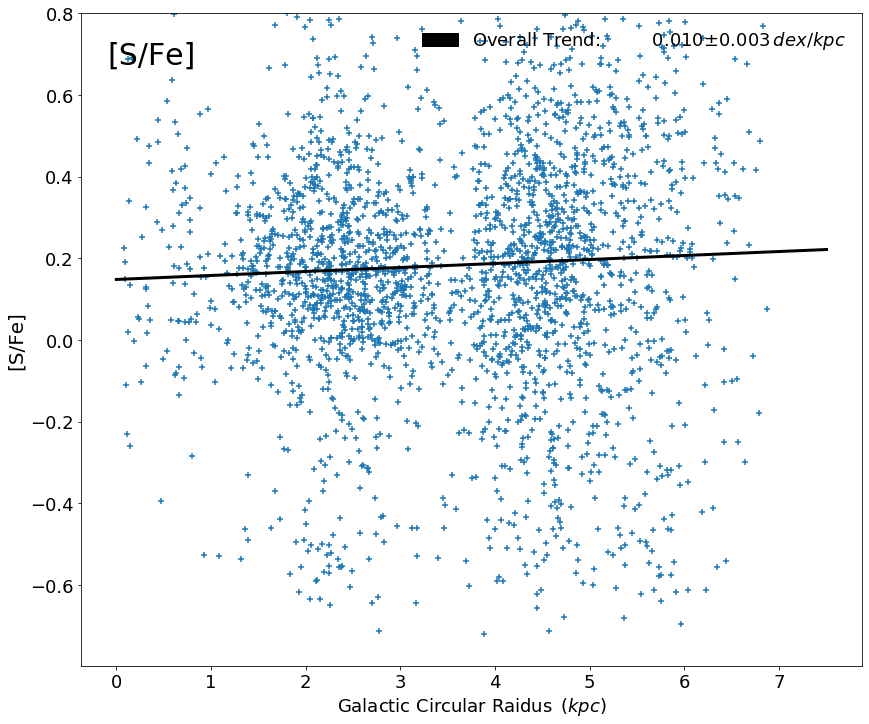

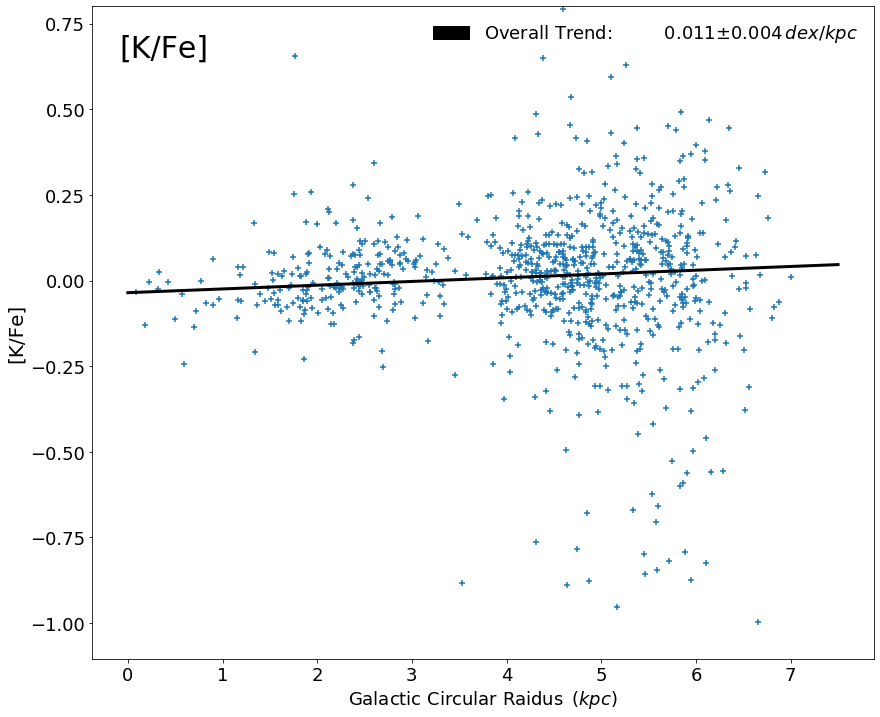

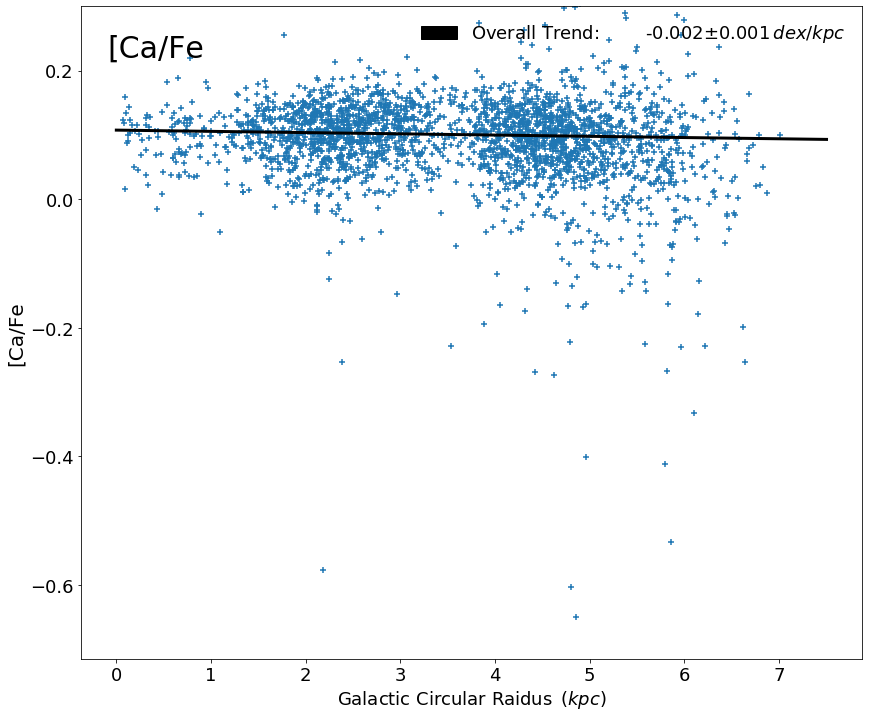

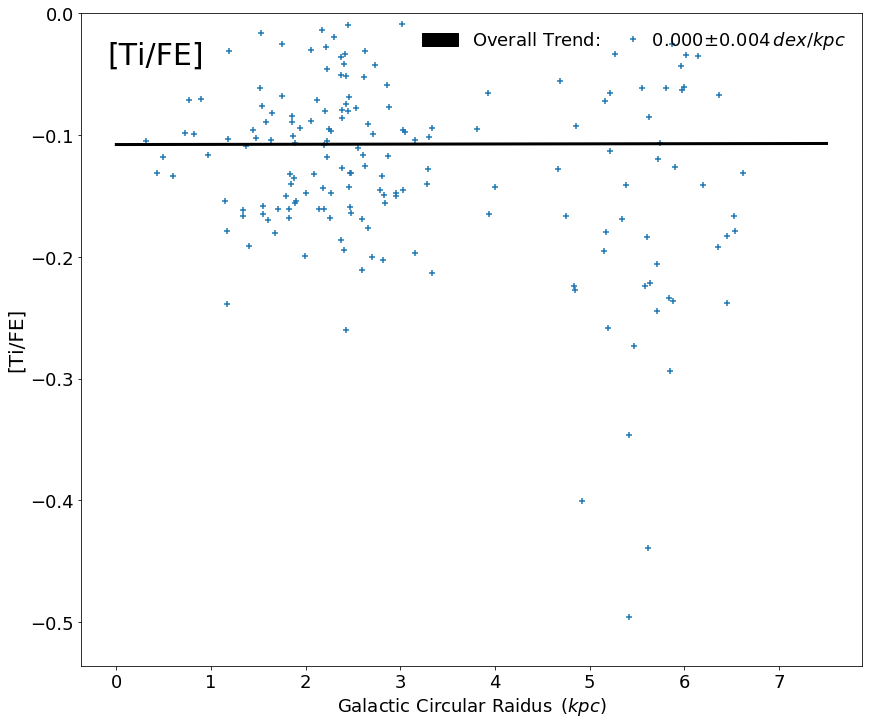

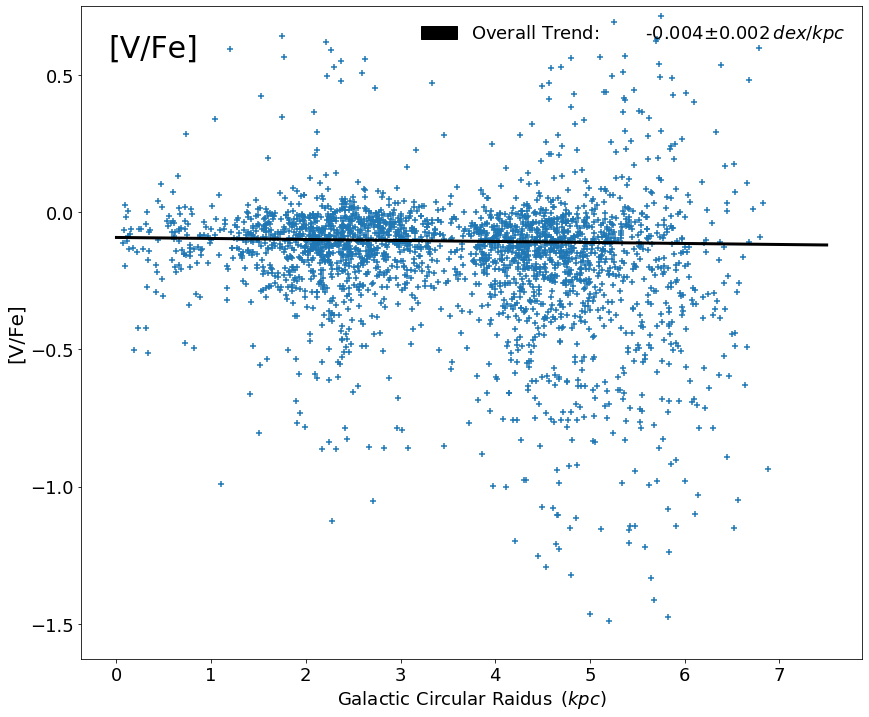

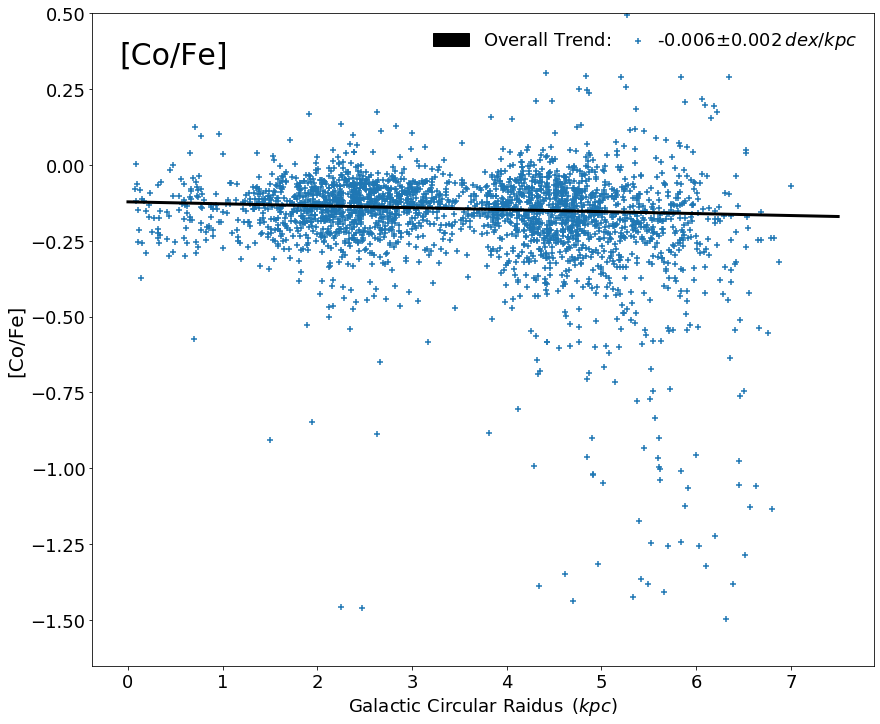

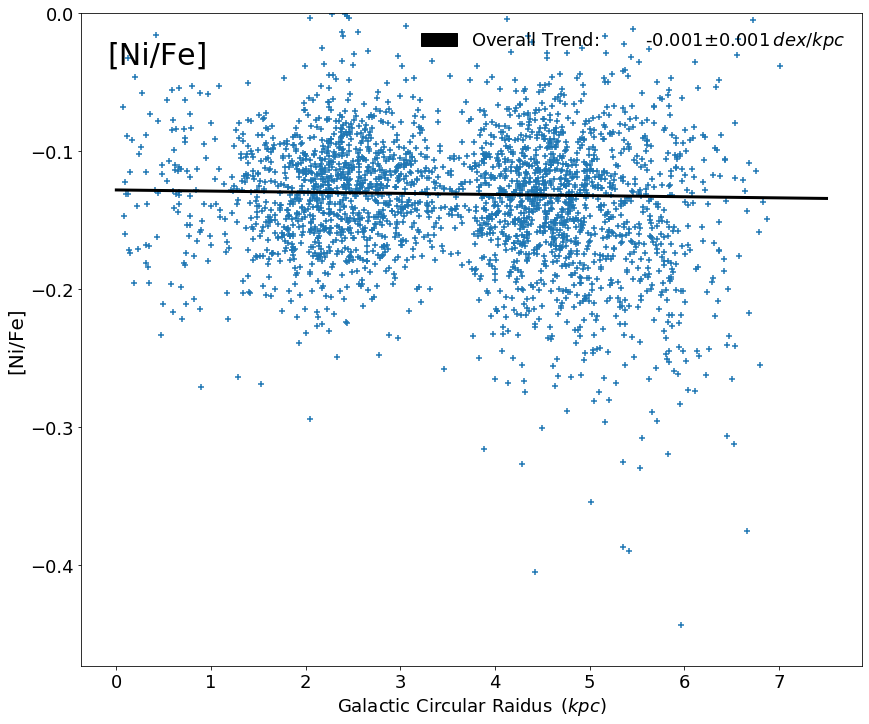

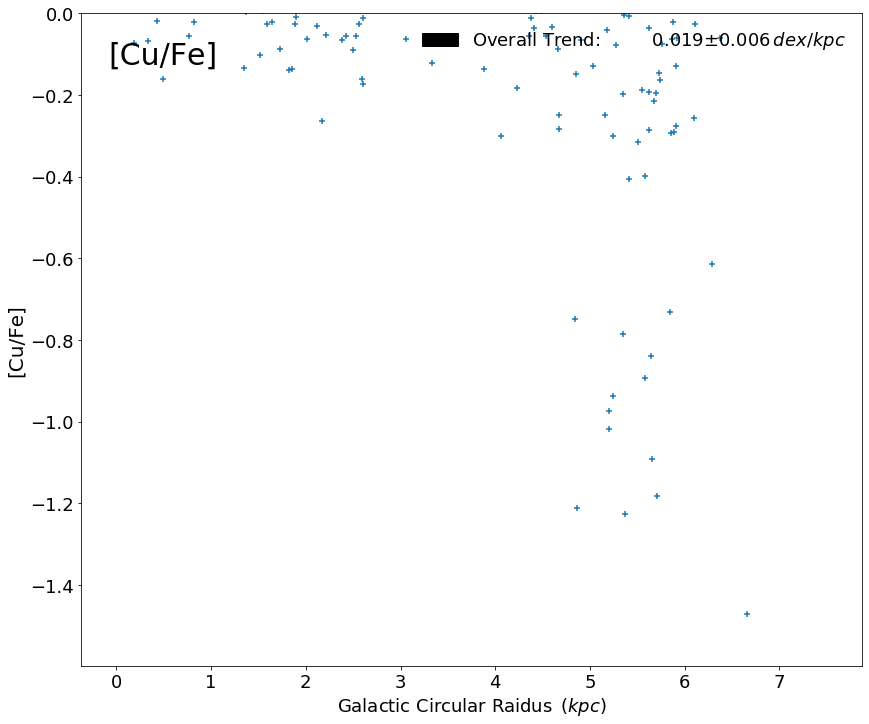

In [28]:
#####################################
### Overall Trend Plots with Data ###
#####################################

matplotlib.rcParams.update({'font.size': 18})

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    
    cln = np.where(r13[elems[i]]>-100)
    
    xval = np.linspace(0.0,7.5)

    fig = plt.figure(figsize=[14,12])
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    plt.scatter(np.asarray(radius)[cln],r13[elems[i]][cln],marker='+',c='tab:blue')
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    handles.append(empty_over)

    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(re_med_ms[i],med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='medium',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    
    plt.ylim(top = ytops[i])
    
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
    plt.savefig('overallgradonly{}.pdf'.format(elems[i]),bbox_inches='tight')
    plt.show()

In [19]:
# flat_samples = []

# prune_fact = 3.
# for j in tqdm_notebook(range(len(elems)-5),desc='Done?'):
#     cln = np.where((r13[elems[j]]>-100)&(r13['SNR']>=100))
#     prune = np.where((r13[elems[j]]>-prune_fact*gfunc.mad(med_elems_dist[i])+
#                      np.median(r13[cln][elems[j]]))&
#                     (r13[elems[j]]<prune_fact*gfunc.mad(med_elems_dist[i])+
#                      np.median(r13[cln][elems[j]])))

#     m_guess = re_med_m[j]
#     b_guess = re_med_b[j]
    
#     guess = np.array([m_guess,b_guess])

#     exog = radius[prune]
#     endog = r13[elems[i]][prune]
#     endog_err = r13[elems_err[i]][prune]

# #     niter = 800
#     ndim, nwalkers = 2, 1000
    
#     pos = [guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(exog, endog, endog_err))
#     sampler.run_mcmc(pos, 500);
    
#     flat_samples.append(sampler.flatchain)

In [20]:
# for i in range(len(flat_samples)):
#     labs = ["m", "b"]
#     print('{}'.format(elems[i]))
#     for j in range(ndim):
#         mcmc = np.percentile(flat_samples[i][:, j], [16, 50, 84])
#         q = np.diff(mcmc)
#         txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
#         txt = txt.format(mcmc[j], q[0], q[1], labs[j])
#         display(Math(txt))
#     fig = corner.corner(flat_samples[j], labels=labs)
#     plt.show()
    
#     plt.figure(figsize=[4,4])
#     def trendline(x):
#         return re_med_m[i]*x+re_med_b[i]
    
#     xval = np.linspace(0.0,7.5)
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
#     plt.figure(figsize=[14,12])
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0)
#     plt.scatter(radius[cln],r13[elems[i]][cln])
#     plt.ylabel(r'{}'.format(labels[i]),fontsize=30)
#     plt.xlabel(r'Radius [kpc]',fontsize=30)
#     plt.title(r'MLE Gradient {:.4f}'.format(re_med_m[i]))
#     plt.show()

fit lines only to binned values

resampling mc take ages and add uncert then rebin and redo grads then scatter 



# USE PCA OLS AGES

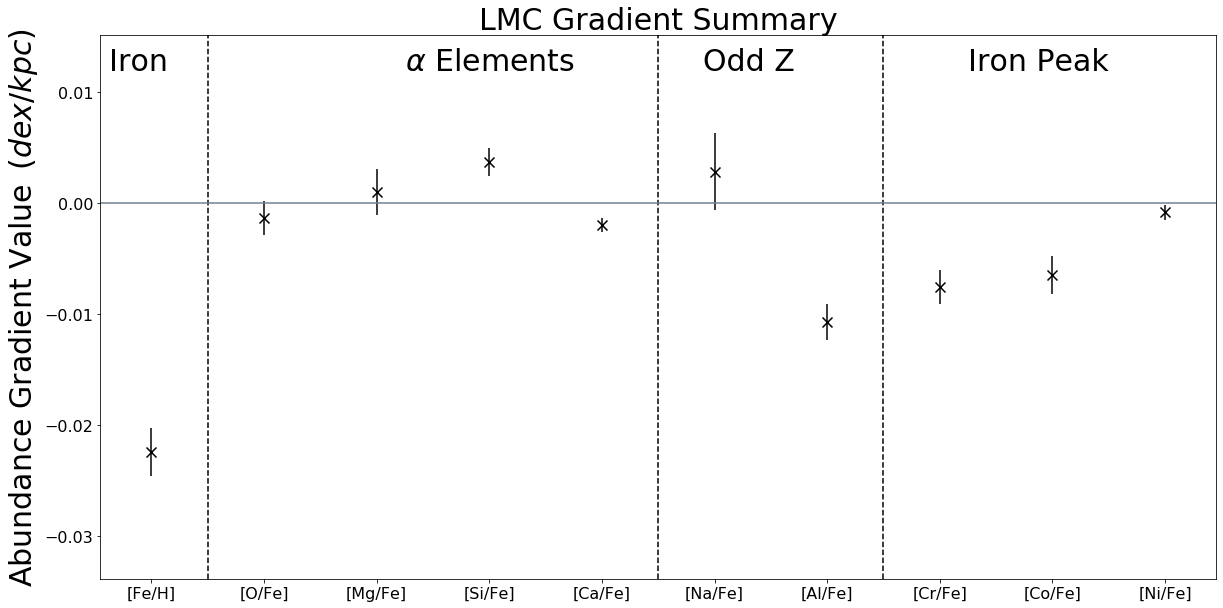

In [29]:
idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_over = []
err_over = []

good_med = []
err_med = []

for i in idx:
    good_over.append(re_med_ms[i])
    err_over.append(med_m_devs[i])
    
#     good_med.append(med_m[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='x',c='black',label='Overall',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

#plt.scatter([0,1,2,3,4,5,6,7,8,9],good_med,marker='x',c='red',label='0.5 kpc bins',s=100)

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]','[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.012,'Iron',fontsize=30)
plt.text(2.25,0.012,'$\\alpha$ Elements',fontsize=30)
plt.text(4.9,0.012,'Odd Z',fontsize=30)
plt.text(7.25,0.012,'Iron Peak',fontsize=30)

plt.title(r'LMC Gradient Summary',fontsize=30)

# plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='large')
plt.savefig('mle_overall.pdf',bbox_inches='tight')
plt.show()

<font size='20'>
    <b>
        Age Bins
    </b>
</font>

In [31]:
### PCA Plus OLS
# def find_ages(z1,z2):
#     p = [9.41292724,0.05706436,-2.70513596]
#     return p[0]+p[1]*z1+p[2]*z2

# def find_ages(z1,z2,z3):
#     p = [9.39183782e+00,6.21217819e-02,4.29593576e-02,-2.95816612e+00,-1.43014007e-02,-6.47435954e-02,
#          -5.99196415e-02,-5.84656083e-03,1.71370300e-02,8.66227116e-01,-2.01258347e-02]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
#     return age

### Final Age Model

def find_ages(z1,z2,z3):
    p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
         1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
    return age

from sklearn.decomposition import PCA
pdat = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg']]).T

In [23]:
# ######################
# ### Calculate Ages ###
# ######################

# abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
# keys = list(abd.keys())

# sol_2_H = []
# for i in keys:
#     sol_2_H.append(abd[i]-12.0)
    
# sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
# x_C = []
# x_N = []
# x_O = []
# x_Mg = []
# x_Ca = []
# x_S = []
# x_Si = []
# x_Fe = []

# for i in range(len(r13)):
#     x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
#     x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    
# factsCN = []
# for j in range(len(r13)):
#     numerCN = x_C[j]+x_N[j]
#     denomCN = sum(sol_xm[0:2])
    
# factsCN.append(numerCN/denomCN)
# factsCN = factsCN

# metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

# _, _, stardist = gfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
# corabsK = gfunc.absmag(r13['K'],stardist)-r13['AK_TARG']

# adat = np.array([np.log10(r13['TEFF']),corabsK,gfunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T

# zs = PCA(n_components=3).fit(pdat).transform(adat)

# parage = find_ages(zs[:,0],zs[:,1],zs[:,2])

In [24]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)

# X = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg']]).T
# factor=pca.fit(X)

# print(factor.explained_variance_ratio_)

# print(factor.components_.T)

# new_data = np.dot(X,factor.components_.T)

In [32]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    

# factsCN = []

# for j in range(len(r13)):
#     numerCN = x_C[j]+x_N[j]
#     denomCN = sum(sol_xm[0:2])
    
# factsCN.append(numerCN/denomCN)
    
# factsCN = factsCN

# metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

# _, _, stardist = gfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
# corabsK = gfunc.absmag(r13['K'],stardist)-r13['AK_TARG']

# adat = np.array([np.log10(r13['TEFF']),corabsK,gfunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T

# zs = PCA(n_components=3).fit(pdat).transform(adat)

# parage = find_ages(zs[:,0],zs[:,1],zs[:,2])

In [33]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [86]:
age_dist = []

pca_transform = PCA(n_components=3).fit(pdat)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = gfunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_noise(dist,1.0,distribution='uniform')
#             absK_new = gfunc.absmag(ks_new,dist_new) - ak
        
#         else:
#             absK_new = gfunc.absmag(ks_new,dist) - ak
            
        absK_new = gfunc.absmag(ks_new,dist+5.) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,gfunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in range(len(age_dist)):
    devs.append(gfunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

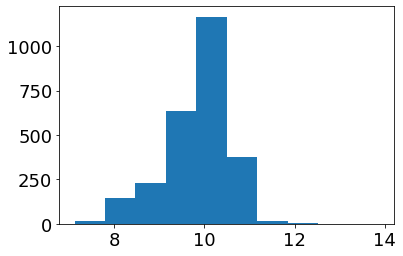

In [87]:
plt.hist(parages)
plt.show()

In [88]:
#####################
### Make Age Bins ###
#####################

young = np.where(parages<=np.log10(0.5*10**9))
yless = np.where((parages>np.log10(0.5*10**9))&(parages<=np.log10(2.0*10**9)))
ymed = np.where((parages>np.log10(2.0*10**9))&(parages<=np.log10(7*10**9)))
omed = np.where((parages>np.log10(7*10**9))&(parages<=np.log10(10.5*10**9)))
old = np.where(parages>np.log10(10.5*10**9))

r13young = r13[young]
r13yless = r13[yless]
r13ymed = r13[ymed]
r13omed = r13[omed]
r13old = r13[old]

In [89]:
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    
    # fit data
    slope, inter = mle_fit(radius[cln],r13[elems[i]][cln],r13[elems_err[i]][cln])
    med_ms.append(slope)
    med_bs.append(inter)

In [33]:
# print(young_ms)
# print(young_bs)

In [90]:
##################################
### Age bin initial Trendlines ###
##################################

### young

young_ms = []
young_bs = []

r13young = r13[young]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13young[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle_fit(radius[young][cln],r13young[elems[i]][cln],r13young[elems_err[i]][cln])
        young_ms.append(slope)
        young_bs.append(inter)
        
    except:
        young_ms.append(-9999.0)
        young_bs.append(-9999.0)
    
### yless

yless_ms = []
yless_bs = []

r13yless = r13[yless]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13yless[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle_fit(radius[yless][cln],r13yless[elems[i]][cln],r13yless[elems_err[i]][cln])
        yless_ms.append(slope)
        yless_bs.append(inter)
        
    except:
        yless_ms.append(-9999.0)
        yless_bs.append(-9999.0)
    
### ymed

ymed_ms = []
ymed_bs = []

r13ymed = r13[ymed]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13ymed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle_fit(radius[ymed][cln],r13ymed[elems[i]][cln],r13ymed[elems_err[i]][cln])
        ymed_ms.append(slope)
        ymed_bs.append(inter)
        
    except:
        ymed_ms.append(-9999.0)
        ymed_bs.append(-9999.0)
    
### omed

omed_ms = []
omed_bs = []

r13omed = r13[omed]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13omed[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle_fit(radius[omed][cln],r13omed[elems[i]][cln],r13omed[elems_err[i]][cln])
        omed_ms.append(slope)
        omed_bs.append(inter)
        
    except:
        omed_ms.append(-9999.0)
        omed_bs.append(-9999.0)
    
### old

old_ms = []
old_bs = []

r13old = r13[old]

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13old[elems[i]]>-100))
    
    try:
        # fit data
        slope, inter = mle_fit(radius[old][cln],r13old[elems[i]][cln],r13old[elems_err[i]][cln])
        old_ms.append(slope)
        old_bs.append(inter)
        
    except:
        old_ms.append(-9999.0)
        old_bs.append(-9999.0)

In [91]:
############################################
### Find distances between data and fits ###
############################################

young_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return young_ms[i]*x+young_bs[i]
    
    cln = np.where((r13young[elems[i]]>-100))
    plug = trendline(radius[young][cln])
    dist = plug-r13young[elems[i]][cln]
    
    young_dist.append(dist) 
    
yless_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return yless_ms[i]*x+yless_bs[i]
    
    cln = np.where((r13yless[elems[i]]>-100))
    plug = trendline(radius[yless][cln])
    dist = plug-r13yless[elems[i]][cln]
    
    yless_dist.append(dist) 
    
ymed_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return ymed_ms[i]*x+ymed_bs[i]
    
    cln = np.where((r13ymed[elems[i]]>-100))
    plug = trendline(radius[ymed][cln])
    dist = plug-r13ymed[elems[i]][cln]
    
    ymed_dist.append(dist) 
    
omed_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return omed_ms[i]*x+omed_bs[i]
    
    cln = np.where((r13omed[elems[i]]>-100))
    plug = trendline(radius[omed][cln])
    dist = plug-r13omed[elems[i]][cln]
    
    omed_dist.append(dist) 
    
old_dist = []
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    def trendline(x):
        return old_ms[i]*x+old_bs[i]
    
    cln = np.where((r13old[elems[i]]>-100))
    plug = trendline(radius[old][cln])
    dist = plug-r13old[elems[i]][cln]
    
    old_dist.append(dist) 

In [36]:
# prune_fact = 3.0

# re_young_ms = []
# re_young_bs = []

# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     # clean up data
#     cln = np.where((r13young[elems[i]]>-100))
#     prune = np.where((r13young[elems[i]]>-prune_fact*gfunc.mad(young_dist[i])+
#                       np.median(r13young[cln][elems[i]]))&
#                      (r13young[elems[i]]<prune_fact*gfunc.mad(young_dist[i])+
#                       np.median(r13young[cln][elems[i]])))
    
#     print(r13[elems[i]][prune])
    
#     # refit pruned data
# #     try:
# #         re_slope, re_inter = mle_fit(radius[prune],r13[elems[i]][prune],r13[elems_err[i]][prune])
# #         re_young_ms.append(re_slope)
# #         re_young_bs.append(re_inter)

In [92]:
####################
### Pruned Refit ###
####################

prune_fact = 3.0

re_young_ms = []
re_young_bs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13young[elems[i]]>-100))
    prune = np.where((r13young[elems[i]]>-prune_fact*gfunc.mad(young_dist[i])+
                      np.median(r13young[cln][elems[i]]))&
                     (r13young[elems[i]]<prune_fact*gfunc.mad(young_dist[i])+
                      np.median(r13young[cln][elems[i]])))
    
    # refit pruned data
    try:
        re_slope, re_inter = mle_fit(radius[young][prune],r13young[elems[i]][prune],
                                     r13young[elems_err[i]][prune])
        re_young_ms.append(re_slope)
        re_young_bs.append(re_inter)
        
    except:
        re_young_ms.append(-9999.0)
        re_young_bs.append(-9999.0)
    
re_yless_ms = []
re_yless_bs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13yless[elems[i]]>-100))
    prune = np.where((r13yless[elems[i]]>-prune_fact*gfunc.mad(yless_dist[i])+
                      np.median(r13yless[cln][elems[i]]))&
                     (r13yless[elems[i]]<prune_fact*gfunc.mad(yless_dist[i])+
                      np.median(r13yless[cln][elems[i]])))
    
    # refit pruned data
    try:
        re_slope, re_inter = mle_fit(radius[yless][prune],r13yless[elems[i]][prune],
                                     r13yless[elems_err[i]][prune])
        re_yless_ms.append(re_slope)
        re_yless_bs.append(re_inter)
        
    except:
        re_yless_ms.append(-9999.0)
        re_yless_bs.append(-9999.0)
    
re_ymed_ms = []
re_ymed_bs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13ymed[elems[i]]>-100))
    prune = np.where((r13ymed[elems[i]]>-prune_fact*gfunc.mad(ymed_dist[i])+
                      np.median(r13ymed[cln][elems[i]]))&
                     (r13ymed[elems[i]]<prune_fact*gfunc.mad(ymed_dist[i])+
                      np.median(r13ymed[cln][elems[i]])))
    
    # refit pruned data
    try:
        re_slope, re_inter = mle_fit(radius[ymed][prune],r13ymed[elems[i]][prune],
                                     r13ymed[elems_err[i]][prune])
        re_ymed_ms.append(re_slope)
        re_ymed_bs.append(re_inter)
        
    except:
        re_ymed_ms.append(-9999.0)
        re_ymed_bs.append(-9999.0)
    
re_omed_ms = []
re_omed_bs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13omed[elems[i]]>-100))
    prune = np.where((r13omed[elems[i]]>-prune_fact*gfunc.mad(omed_dist[i])+
                      np.median(r13omed[cln][elems[i]]))&
                     (r13omed[elems[i]]<prune_fact*gfunc.mad(omed_dist[i])+
                      np.median(r13omed[cln][elems[i]])))
    
    # refit pruned data
    try:
        re_slope, re_inter = mle_fit(radius[omed][prune],r13omed[elems[i]][prune],
                                     r13omed[elems_err[i]][prune])
        re_omed_ms.append(re_slope)
        re_omed_bs.append(re_inter)
        
    except:
        re_omed_ms.append(-9999.0)
        re_omed_bs.append(-9999.0)
    
re_old_ms = []
re_old_bs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data
    cln = np.where((r13old[elems[i]]>-100))
    prune = np.where((r13old[elems[i]]>-prune_fact*gfunc.mad(old_dist[i])+
                      np.median(r13old[cln][elems[i]]))&
                     (r13old[elems[i]]<prune_fact*gfunc.mad(old_dist[i])+
                      np.median(r13old[cln][elems[i]])))
    
    # refit pruned data
    try:
        re_slope, re_inter = mle_fit(radius[old][prune],r13old[elems[i]][prune],
                                     r13old[elems_err[i]][prune])
        re_old_ms.append(re_slope)
        re_old_bs.append(re_inter)
        
    except:
        re_old_ms.append(-9999.0)
        re_old_bs.append(-9999.0)

In [93]:
prune_fact = 3.0

young_m_devs = []
young_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13young[elems[i]]>-100))
    prune = np.where((r13young[elems[i]]>-prune_fact*gfunc.mad(young_dist[i])+
                      np.median(r13young[cln][elems[i]]))&
                     (r13young[elems[i]]<prune_fact*gfunc.mad(young_dist[i])+
                      np.median(r13young[cln][elems[i]])))

    exog = radius[young][prune]
    endog = r13young[elems[i]][prune]
    endog_err = r13young[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    young_m_devs.append(mad(slps))
    young_b_devs.append(mad(ints))
    
yless_m_devs = []
yless_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13yless[elems[i]]>-100))
    prune = np.where((r13yless[elems[i]]>-prune_fact*gfunc.mad(yless_dist[i])+
                      np.median(r13yless[cln][elems[i]]))&
                     (r13yless[elems[i]]<prune_fact*gfunc.mad(yless_dist[i])+
                      np.median(r13yless[cln][elems[i]])))

    exog = radius[yless][prune]
    endog = r13yless[elems[i]][prune]
    endog_err = r13yless[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    yless_m_devs.append(mad(slps))
    yless_b_devs.append(mad(ints))
    
ymed_m_devs = []
ymed_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13ymed[elems[i]]>-100))
    prune = np.where((r13ymed[elems[i]]>-prune_fact*gfunc.mad(ymed_dist[i])+
                      np.median(r13ymed[cln][elems[i]]))&
                     (r13ymed[elems[i]]<prune_fact*gfunc.mad(ymed_dist[i])+
                      np.median(r13ymed[cln][elems[i]])))

    exog = radius[ymed][prune]
    endog = r13ymed[elems[i]][prune]
    endog_err = r13ymed[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    ymed_m_devs.append(mad(slps))
    ymed_b_devs.append(mad(ints))
    
omed_m_devs = []
omed_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13omed[elems[i]]>-100))
    prune = np.where((r13omed[elems[i]]>-prune_fact*gfunc.mad(omed_dist[i])+
                      np.median(r13omed[cln][elems[i]]))&
                     (r13omed[elems[i]]<prune_fact*gfunc.mad(omed_dist[i])+
                      np.median(r13omed[cln][elems[i]])))

    exog = radius[omed][prune]
    endog = r13omed[elems[i]][prune]
    endog_err = r13omed[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    omed_m_devs.append(mad(slps))
    omed_b_devs.append(mad(ints))
    
old_m_devs = []
old_b_devs = []

for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    # clean up data and prune outliers
    cln = np.where((r13old[elems[i]]>-100))
    prune = np.where((r13old[elems[i]]>-prune_fact*gfunc.mad(old_dist[i])+
                      np.median(r13old[cln][elems[i]]))&
                     (r13old[elems[i]]<prune_fact*gfunc.mad(old_dist[i])+
                      np.median(r13old[cln][elems[i]])))

    exog = radius[old][prune]
    endog = r13old[elems[i]][prune]
    endog_err = r13old[elems_err[i]][prune]
    
    slps = []
    ints = []
    
    # resample with replacement 100 times and fit lines
    for j in tqdm_notebook(range(1000),leave=False,desc='Iteration'):
        
        ind = np.floor(np.random.random(len(endog))*(len(endog)-1)).astype(int)
        indexog = exog[ind]
        indendog = endog[ind]
        indendog_err = endog_err[ind]
        
        # fit sampled data
        try:
            sample_slope, sample_inter = mle_fit(indexog,indendog,indendog_err)
            slps.append(sample_slope)
            ints.append(sample_inter)
        
        except:
            slps.append(-9999.0)
            ints.append(-9999.0)
        
    old_m_devs.append(mad(slps))
    old_b_devs.append(mad(ints))

In [80]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]


# [np.squeeze(np.where(np.asarray(elems)=='O_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='AL_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='SI_FE')),np.squeeze(np.where(np.asarray(elems)=='CA_FE')),
#          np.squeeze(np.where(np.asarray(elems)=='CR_FE')),np.squeeze(np.where(np.asarray(elems)=='FE_H')),
#          np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_med_ms[i])
    
    err_young.append(young_m_devs[i])
    err_yless.append(yless_m_devs[i])
    err_ymed.append(ymed_m_devs[i])
    err_omed.append(omed_m_devs[i])
    err_old.append(old_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.04,'Iron',fontsize=30)
plt.text(1.75,0.04,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.04,'Odd Z',fontsize=30)
plt.text(7.4,0.04,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)

# plt.title(r'LMC Gradient Summary Plot Without Blue Loop')

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
# plt.savefig('MLEfitcutRefit.pdf',bbox_inches='tight')
plt.show()

In [82]:
# prune_fact = 3.0

# binned_young_stats = []
# binned_young_spread = []

# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     # clean up data
#     cln = np.where((r13young[elems[i]]>-100))
#     prune = np.where((r13young[elems[i]]>-prune_fact*gfunc.mad(young_dist[i])+
#                       np.median(r13young[cln][elems[i]]))&
#                      (r13young[elems[i]]<prune_fact*gfunc.mad(young_dist[i])+
#                       np.median(r13young[cln][elems[i]])))
    
#     #  bin pruned data
#     try:
#         bins = np.arange(np.floor(np.min(radiusyoung[prune])),np.ceil(np.max(radiusyoung[prune])),1)
#         binned_young_stats, _, _ = binned_statistic(radiusyoung[prune],r13young[elems[i]][prune],
#                                                     statistic='median',bins=bins)
#         young_mad, _, _ = binned_statistic(radiusyoung[prune],r13young[elems[i]][prune],
#                                            statistic=lambda y: mad(y),bins=bins)
#         binned_youn
        
        
#     except:
#         re_young_ms.append(-9999.0)
#         re_young_bs.append(-9999.0)

In [83]:
radiusyoung = radius[young]
radiusyless = radius[yless]
radiusymed = radius[ymed]
radiusomed = radius[omed]
radiusold = radius[old]

### young
young_stats = [] 
young_edges = []
young_number = []
young_spread = []

for i in range(len(elems)-5):
    young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusyoung[young_cln])),np.ceil(np.max(radiusyoung[young_cln])),1)
        young_bin_stats, young_bin_edges, young_binnumber = binned_statistic(radiusyoung[young_cln],
                                                                             r13young[elems[i]][young_cln],
                                                                             statistic='median',bins=bins)
        young_mad, _, _ = binned_statistic(radiusyoung[young_cln],r13young[elems[i]][young_cln],
                                                 statistic=lambda y: mad(y),bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_edges.append(young_bin_edges)
        young_number.append(young_binnumber)
        young_spread.append(young_mad)
        
    
    except:
        young_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

        
### yless        
yless_stats = [] 
yless_edges = []
yless_number = []
yless_spread = []

for i in range(len(elems)-5):
    yless_cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusyless[yless_cln])),np.ceil(np.max(radiusyless[yless_cln])),1)
        yless_bin_stats, yless_bin_edges, yless_binnumber = binned_statistic(radiusyless[yless_cln],
                                                                             r13yless[elems[i]][yless_cln],
                                                                             statistic='median',bins=bins)
        yless_mad, _, _ = binned_statistic(radiusyless[yless_cln],r13yless[elems[i]][yless_cln],
                                                 statistic=lambda y: mad(y),bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_edges.append(yless_bin_edges)
        yless_number.append(yless_binnumber)
        yless_spread.append(yless_mad)
    
    except:
        yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### ymed       
ymed_stats = [] 
ymed_edges = []
ymed_number = []
ymed_spread = []

for i in range(len(elems)-5):
    ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusymed[ymed_cln])),np.ceil(np.max(radiusymed[ymed_cln])),1)
        ymed_bin_stats, ymed_bin_edges, ymed_binnumber = binned_statistic(radiusymed[ymed_cln],
                                                                             r13ymed[elems[i]][ymed_cln],
                                                                             statistic='median',bins=bins)
        ymed_mad, _, _ = binned_statistic(radiusymed[ymed_cln],r13ymed[elems[i]][ymed_cln],
                                                 statistic=lambda y: mad(y),bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_edges.append(ymed_bin_edges)
        ymed_number.append(ymed_binnumber)
        ymed_spread.append(ymed_mad)
    
    except:
        ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### omed       
omed_stats = [] 
omed_edges = []
omed_number = []
omed_spread = []

for i in range(len(elems)-5):
    omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusomed[omed_cln])),np.ceil(np.max(radiusomed[omed_cln])),1)
        omed_bin_stats, omed_bin_edges, omed_binnumber = binned_statistic(radiusomed[omed_cln],
                                                                             r13omed[elems[i]][omed_cln],
                                                                             statistic='median',bins=bins)
        omed_mad, _, _ = binned_statistic(radiusomed[omed_cln],r13omed[elems[i]][omed_cln],
                                                 statistic=lambda y: mad(y),bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_edges.append(omed_bin_edges)
        omed_number.append(omed_binnumber)
        omed_spread.append(omed_mad)
    
    except:
        omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### old       
old_stats = [] 
old_edges = []
old_number = []
old_spread = []

for i in range(len(elems)-5):
    old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    try:
        bins = np.arange(np.floor(np.min(radiusold[old_cln])),np.ceil(np.max(radiusold[old_cln])),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(radiusold[old_cln],
                                                                             r13old[elems[i]][old_cln],
                                                                             statistic='median',bins=bins)
        old_mad, _, _ = binned_statistic(radiusold[old_cln],r13old[elems[i]][old_cln],
                                                 statistic=lambda y: mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_edges.append(old_bin_edges)
        old_number.append(old_binnumber)
        old_spread.append(old_mad)
    
    except:
        old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

for i in range(len(young_stats)):
    young_stats[i] = np.delete(np.asarray(young_stats[i]),[5,6,7])
    young_spread[i] = np.delete(np.asarray(young_spread[i]),[5,6,7])
    
    ymed_stats[i] = np.delete(np.asarray(ymed_stats[i]),[5,16,7])
    ymed_spread[i] = np.delete(np.asarray(ymed_spread[i]),[5,16,7])

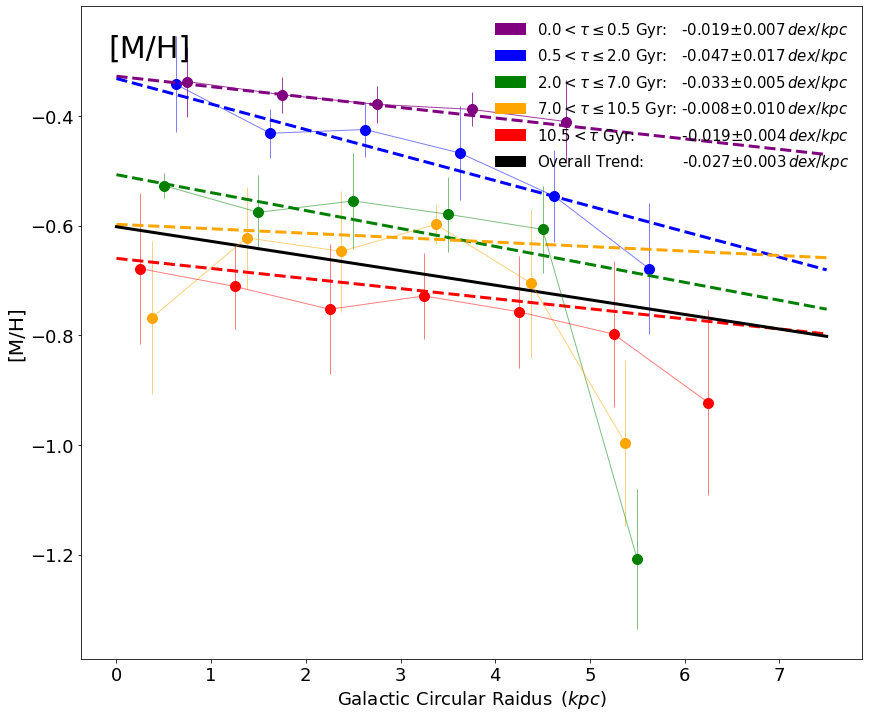

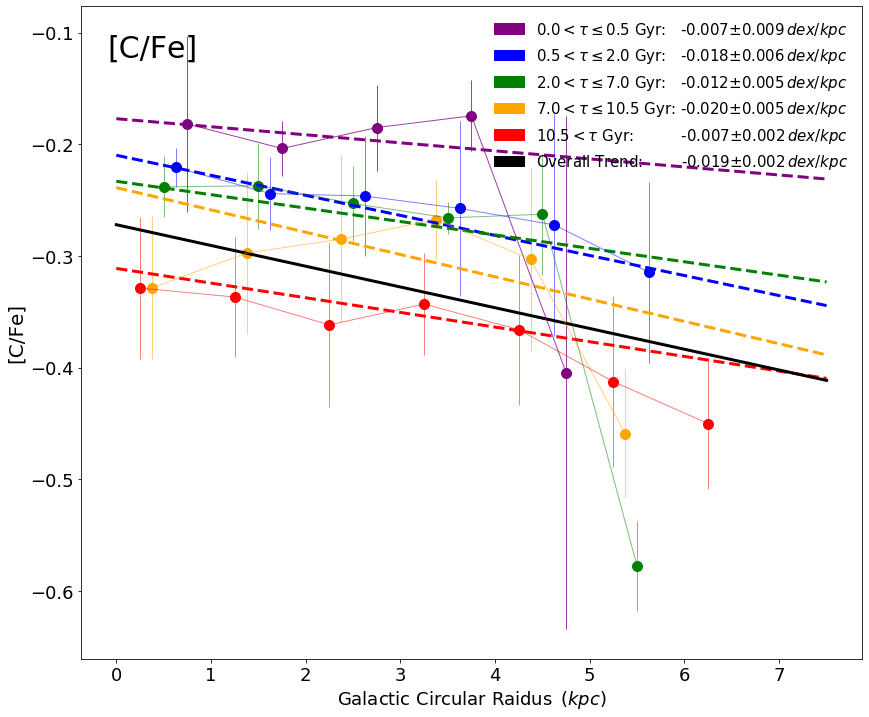

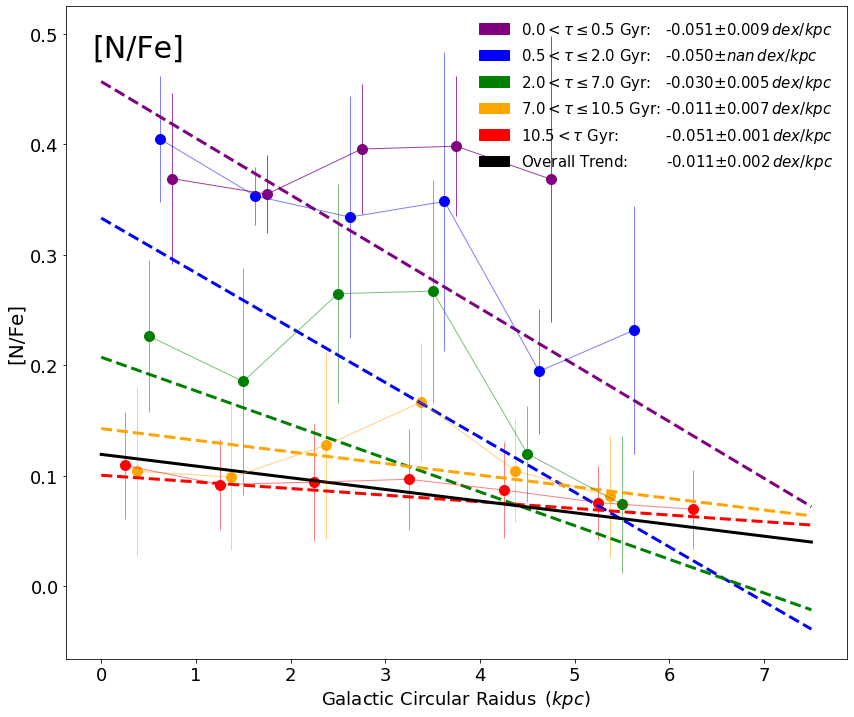

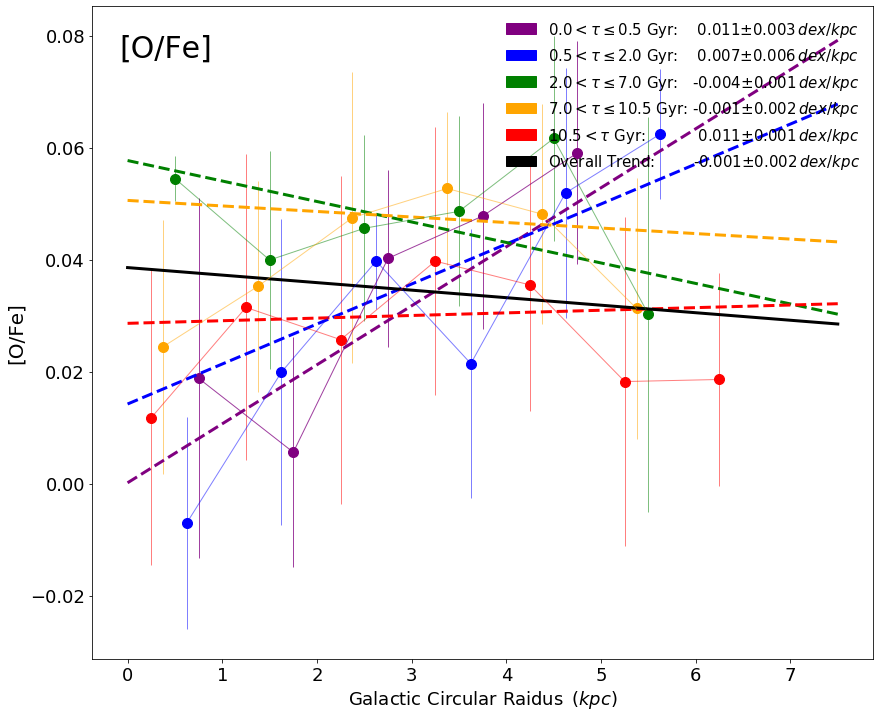

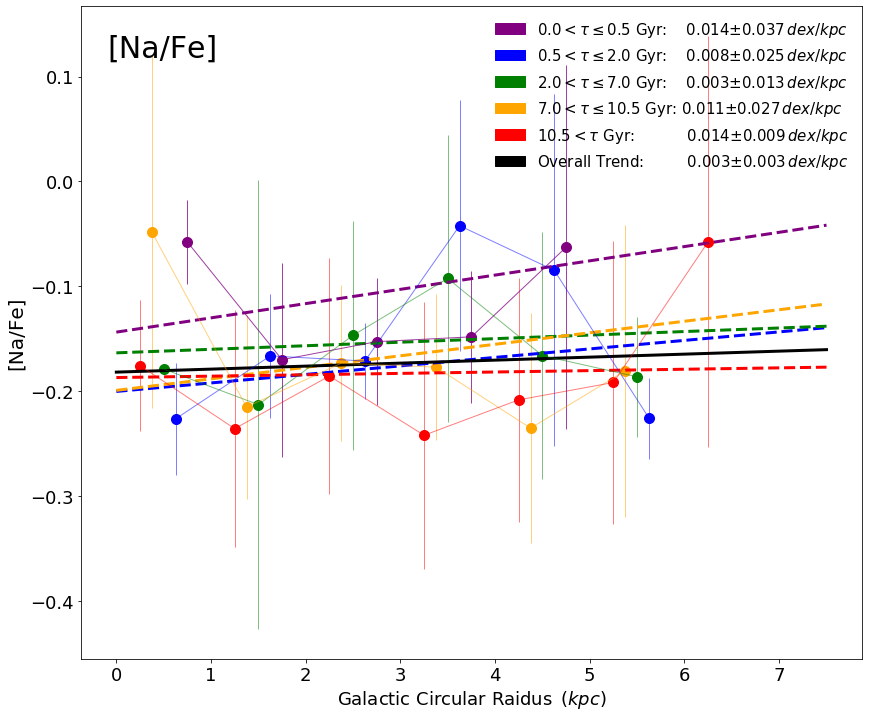

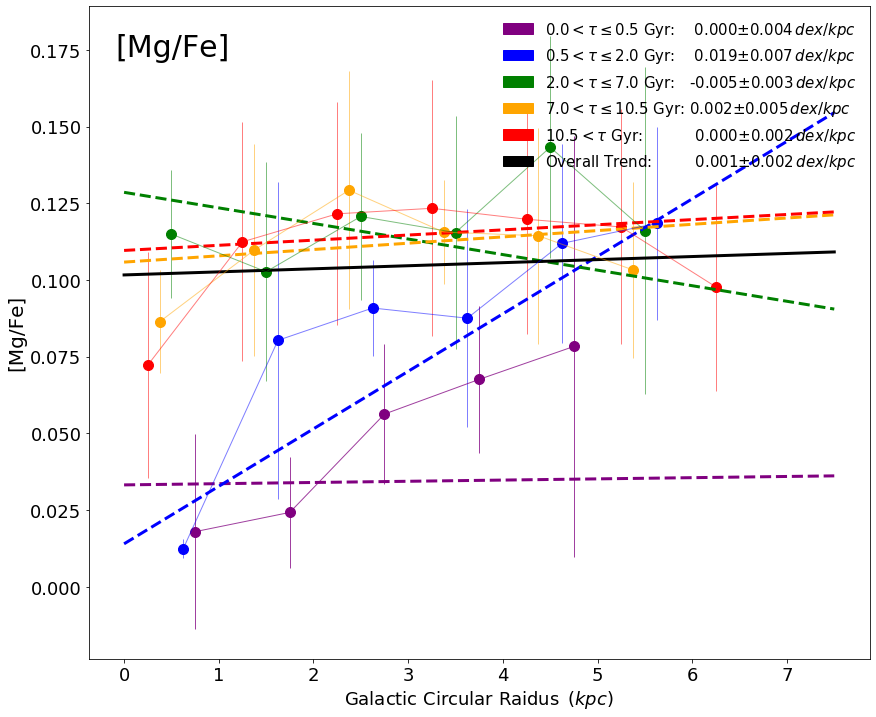

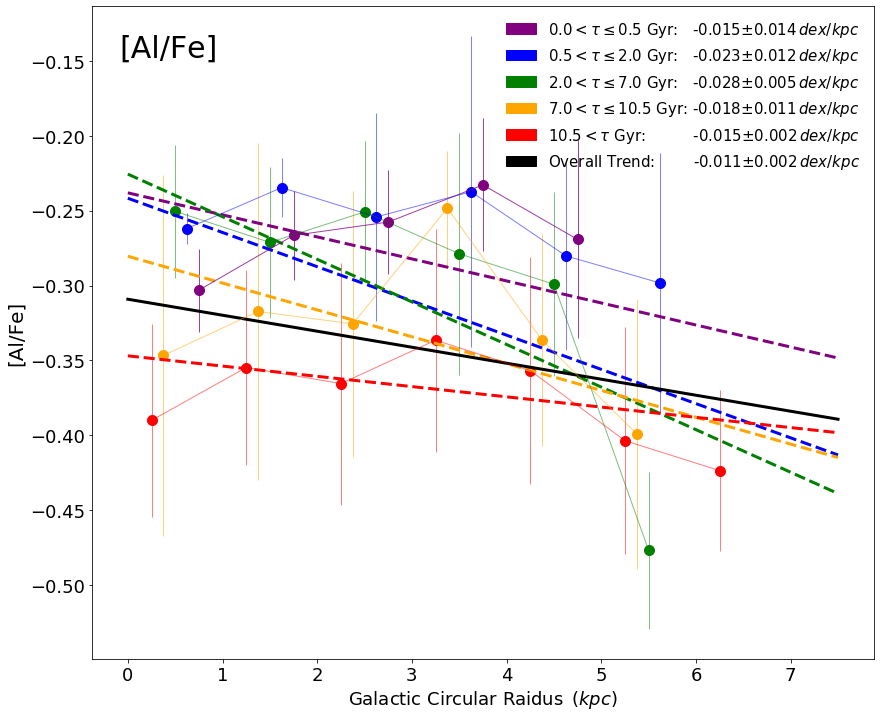

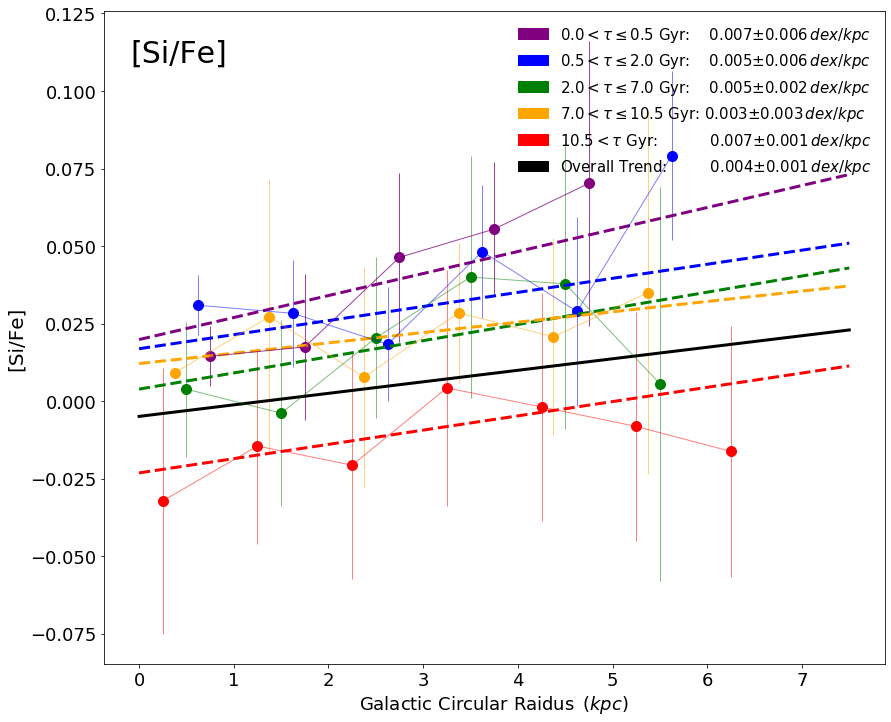

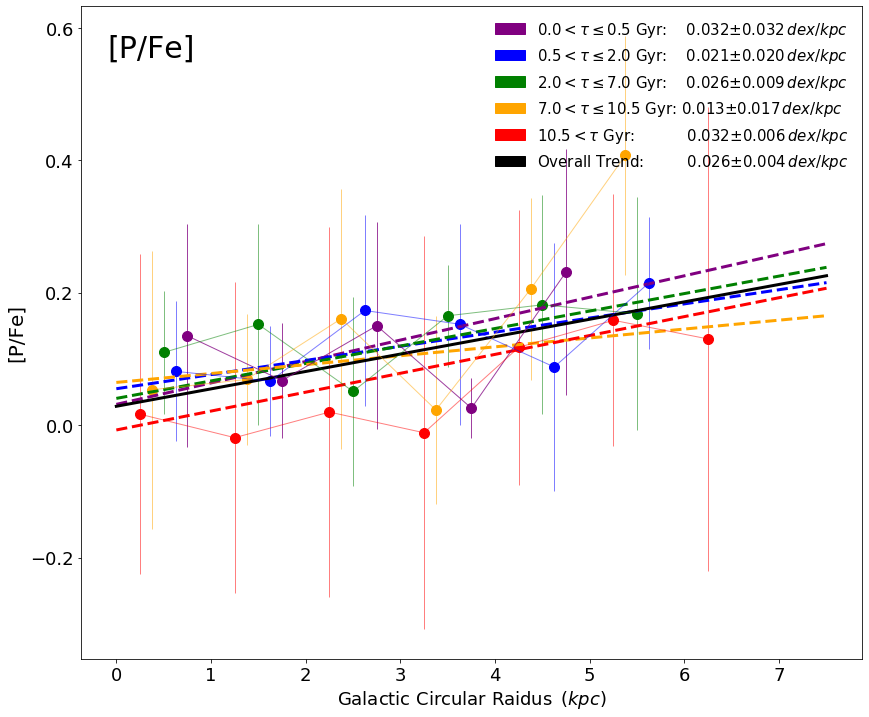

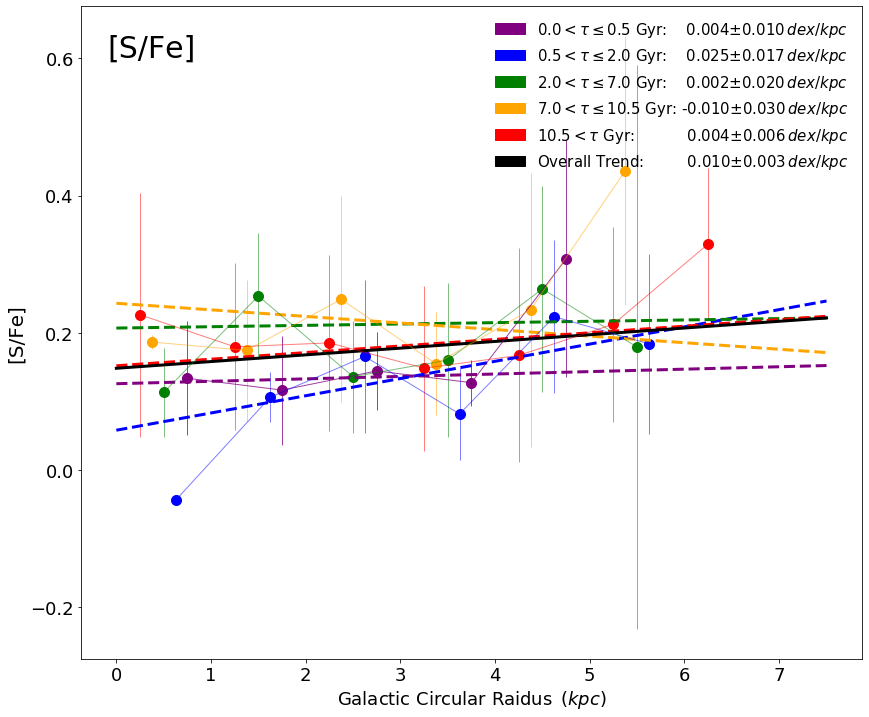

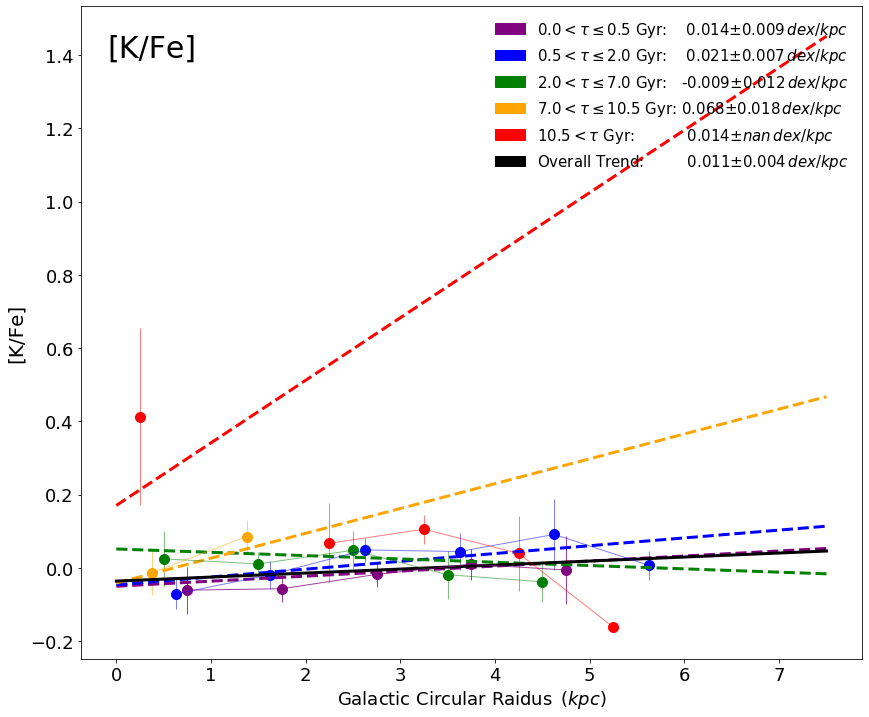

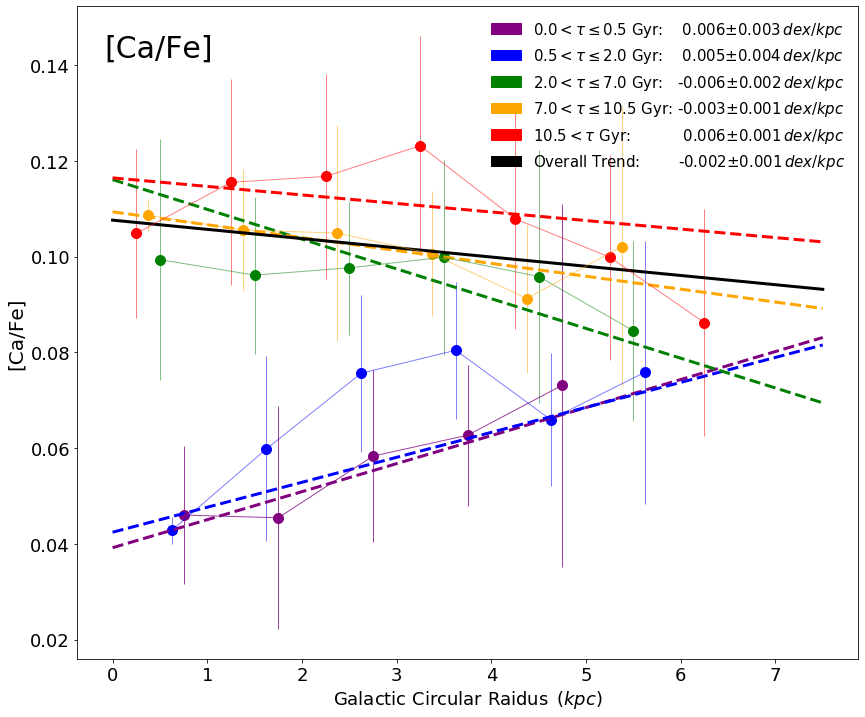

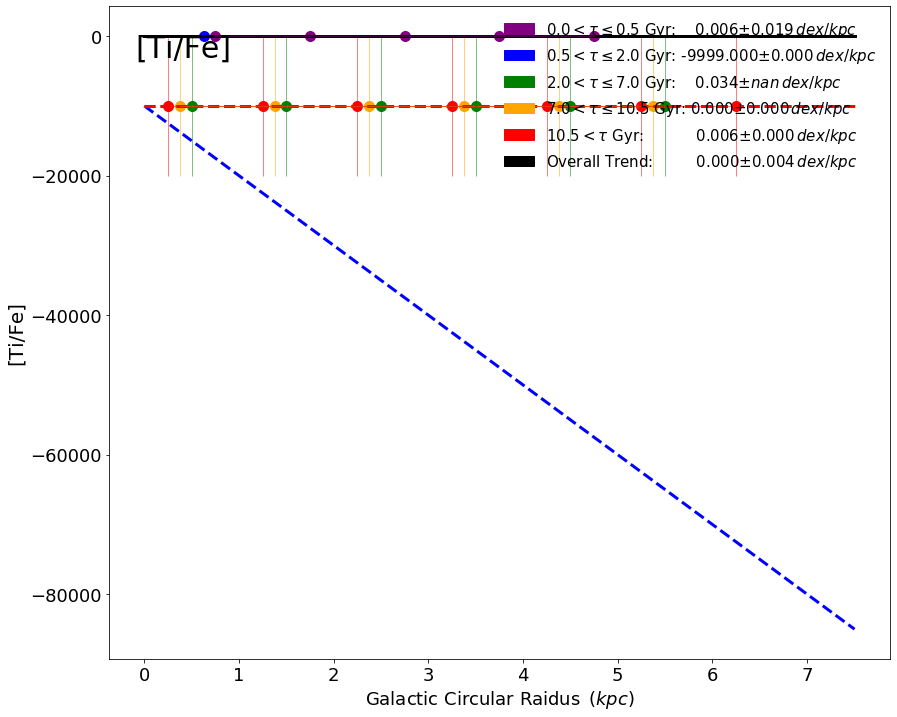

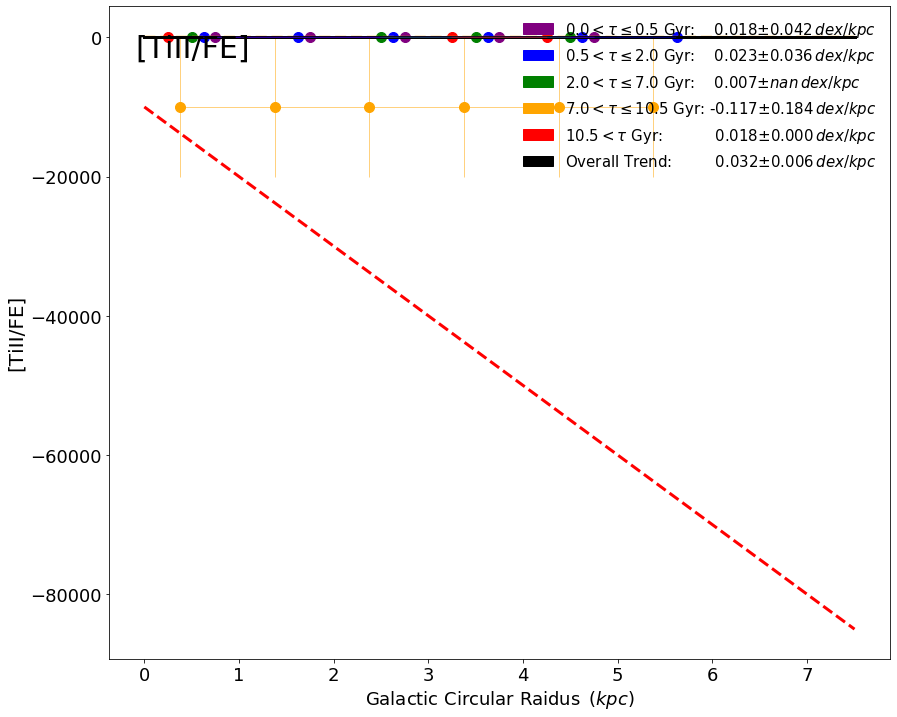

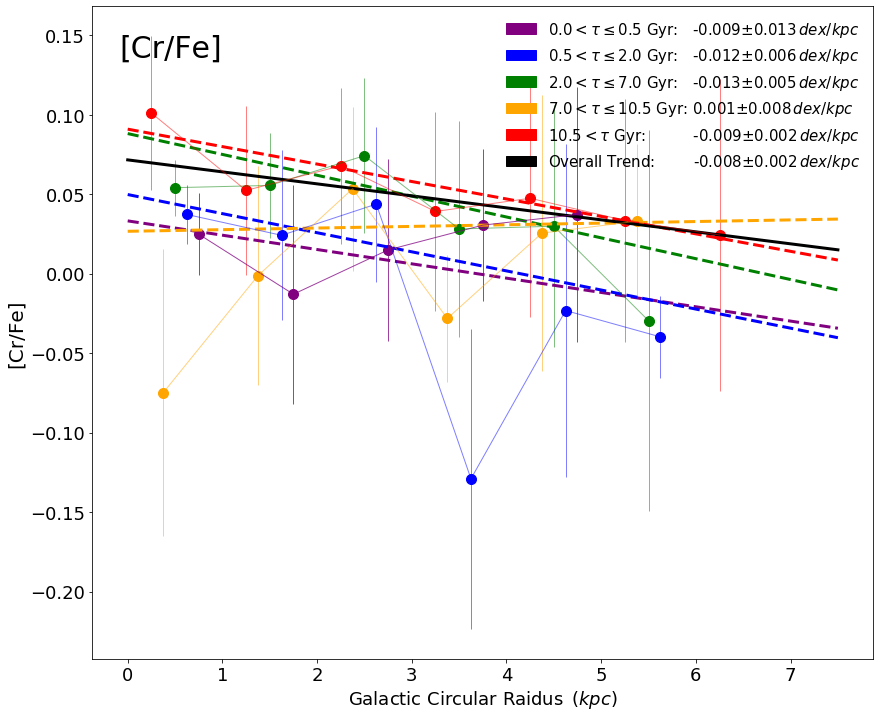

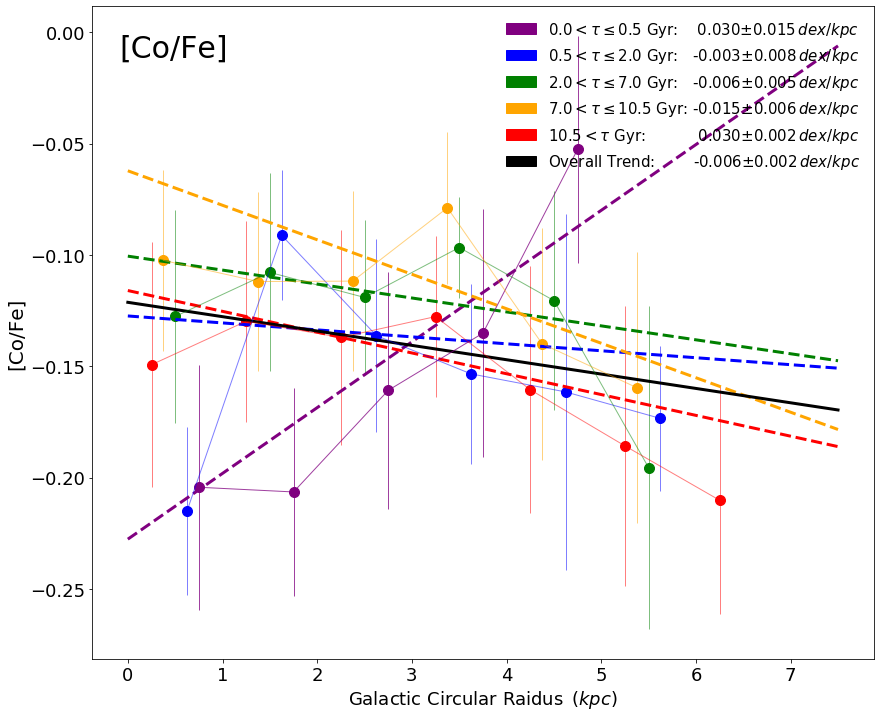

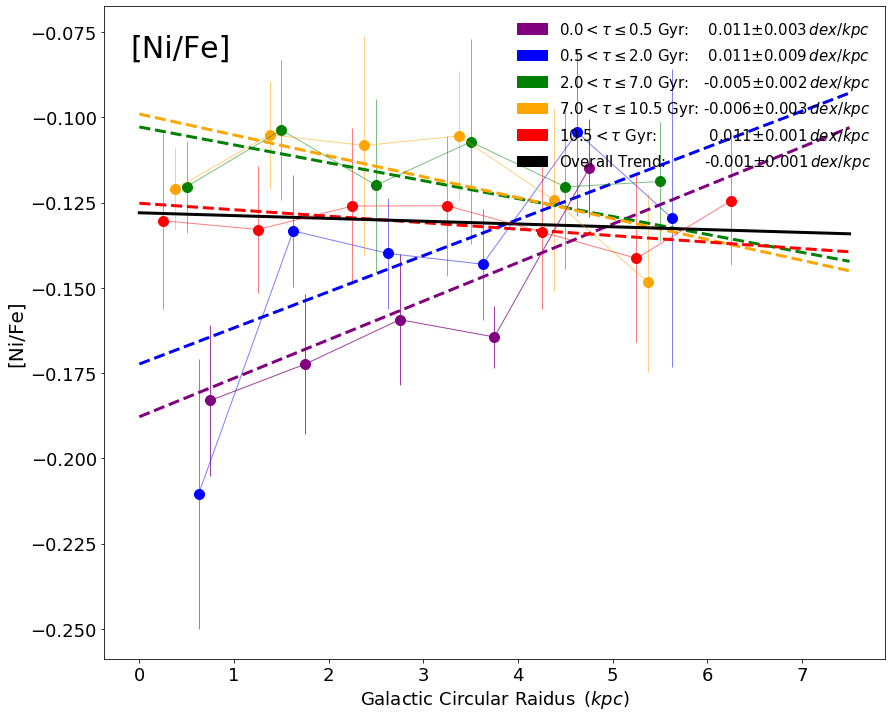

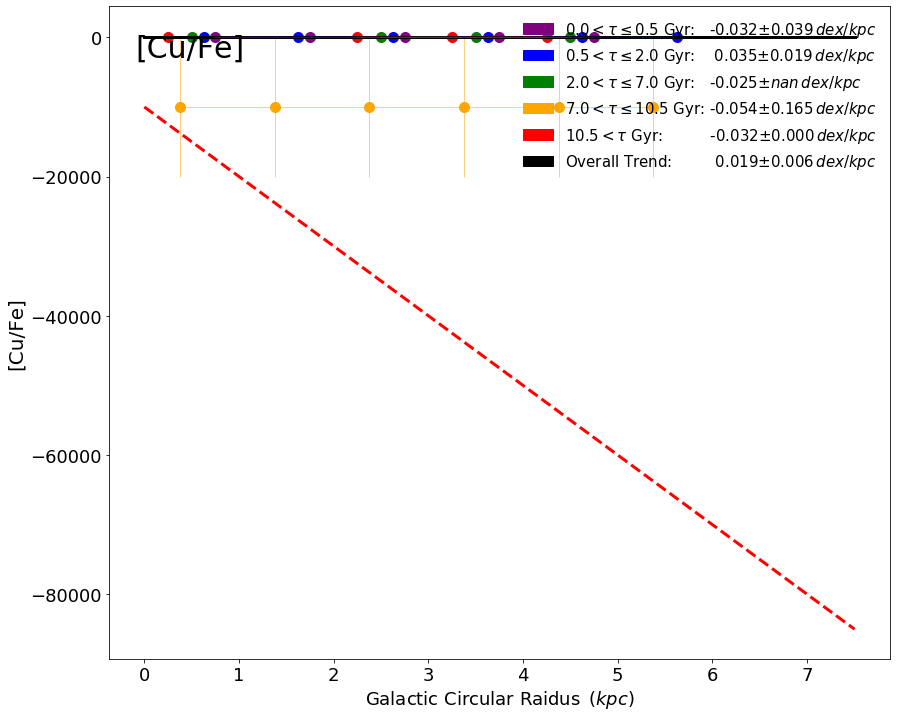

In [84]:
radius = np.sqrt(gfunc.LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+gfunc.LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = np.asarray(parages)[young]
yless_parage = np.asarray(parages)[yless]
ymed_parage = np.asarray(parages)[ymed]
omed_parage = np.asarray(parages)[omed]
old_parage = np.asarray(parages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    
    young_ = np.where((r13young[elems[i]]>-100))#&(r13young['SNR']>=100))
    yless_ = np.where((r13yless[elems[i]]>-100))#&(r13yless['SNR']>=100))
    ymed_ = np.where((r13ymed[elems[i]]>-100))#&(r13ymed['SNR']>=100))
    omed_ = np.where((r13omed[elems[i]]>-100))#&(r13omed['SNR']>=100))
    old_ = np.where((r13old[elems[i]]>-100))#&(r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])

    plt.scatter(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple',marker='o',s=100)
    plt.errorbar(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],yerr=young_spread[i],color='purple',
                 ls='-',alpha=0.75,lw=1)
    #plt.plot(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.scatter(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue',marker='o',s=100)
    plt.errorbar(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],yerr=yless_spread[i],color='blue',
                 ls='-',alpha=0.5,lw=1)
    #plt.plot(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.scatter(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green',marker='o',s=100)
    plt.errorbar(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],yerr=ymed_spread[i],color='green',
                 ls='-',alpha=0.5,lw=1)
    #plt.plot(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.scatter(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange',marker='o',s=100)
    plt.errorbar(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],yerr=omed_spread[i],color='orange',
                 ls='-',alpha=0.5,lw=1)
    #plt.plot(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    plt.scatter(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red',marker='o',s=100)
    plt.errorbar(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],yerr=old_spread[i],color='red',ls='-',
                 alpha=0.5,lw=1)
    #plt.plot(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_young_ms[i],
                                                                                      young_m_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_yless_ms[i],
                                                                                      yless_m_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_ymed_ms[i],
                                                                                      ymed_m_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.3f}$\pm {:.3f} \,dex/kpc$'.format(re_omed_ms[i],
                                                                                       omed_m_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.3f}$\pm {:.3f} \,dex/kpc$'.format(re_young_ms[i],
                                                                               old_m_devs[i]))
    labels.append('Overall Trend: {:>13.3f}$\pm {:.3f} \,dex/kpc$'.format(re_med_ms[i],
                                                                          med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
#     plt.ylim(top = ytops[i])
    
#     if elems[i] == 'CR_FE':
#         plt.ylim(bottom = -0.4)
#         plt.ylim(top = 0.3)
        
#     if elems[i] == 'MG_FE':
#         plt.ylim(0.0, 0.225)
        
#     if elems[i] == 'SI_FE':
#         plt.ylim(top = 0.2)
        
#     if elems[i] == 'NA_FE':
#         plt.ylim(top = 0.25)
        
#     if elems[i] == 'O_FE':
#         plt.ylim(top = 0.150)
        
#     if elems[i] == 'CA_FE':
#         plt.ylim(top = 0.225)
        
#     if elems[i] == 'AL_FE':
#         plt.ylim(top = -0.05)
        
#     if elems[i] == 'CO_FE':
#         plt.ylim(top = 0.25)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('medians_age_bins_{}2.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()
    
    

In [65]:
radius

array([1.1778636 , 1.12183015, 1.12017893, ..., 5.61788186, 6.13652037,
       6.20088292])

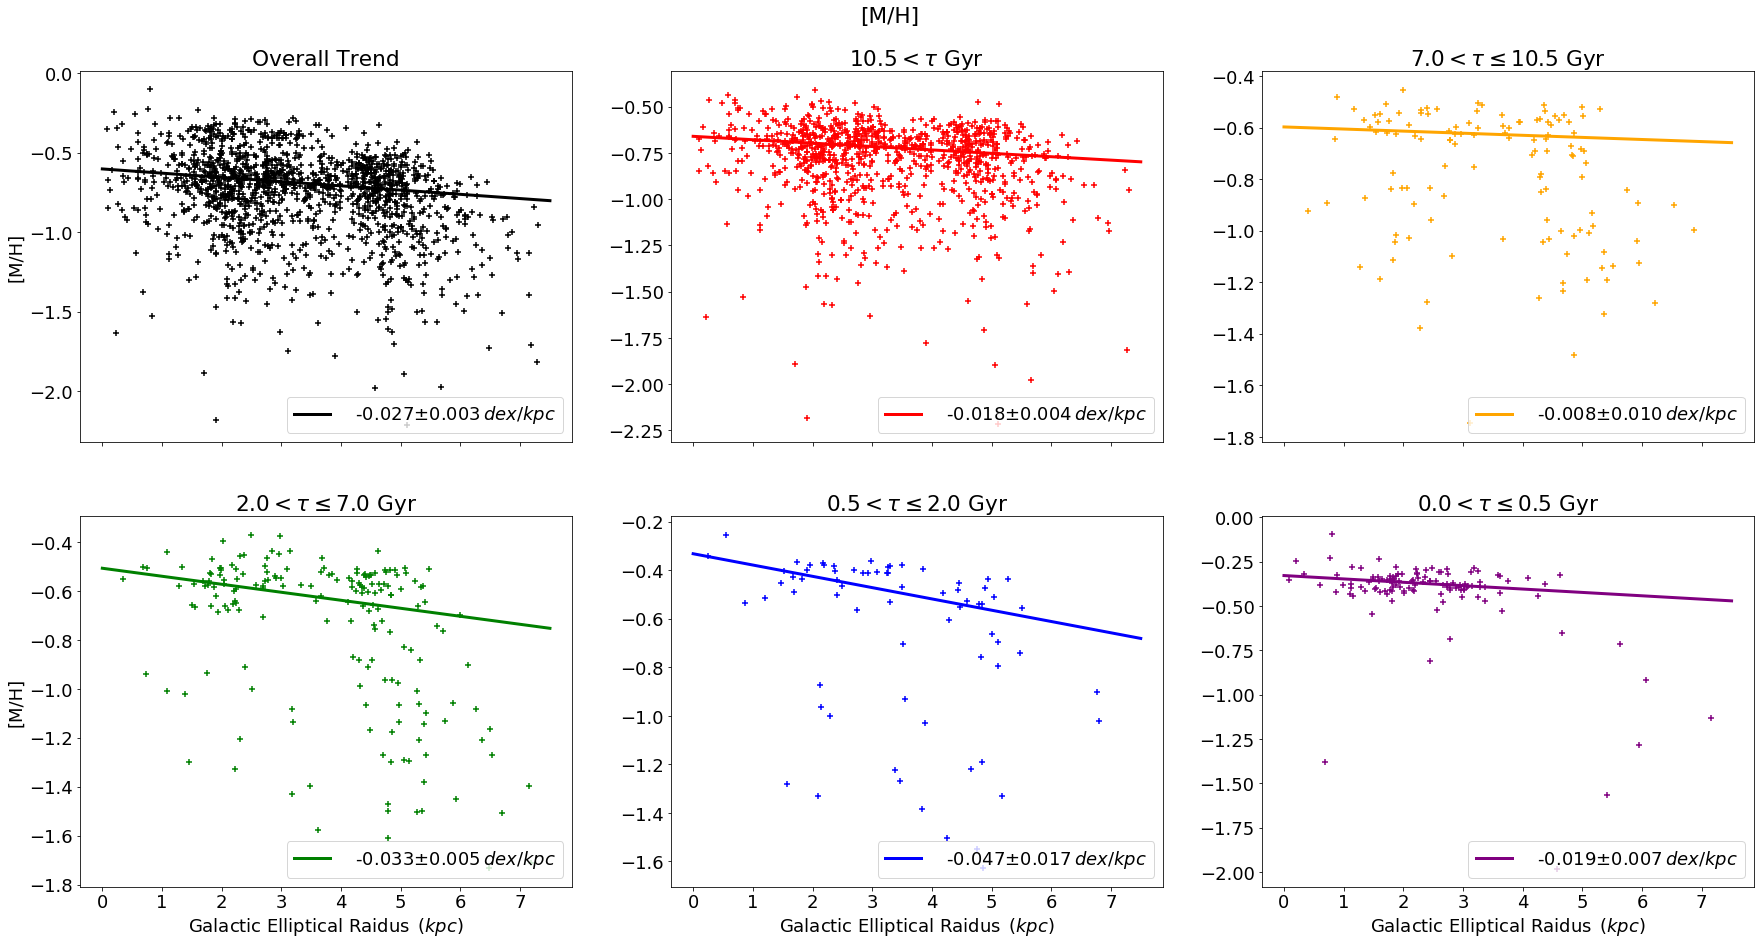

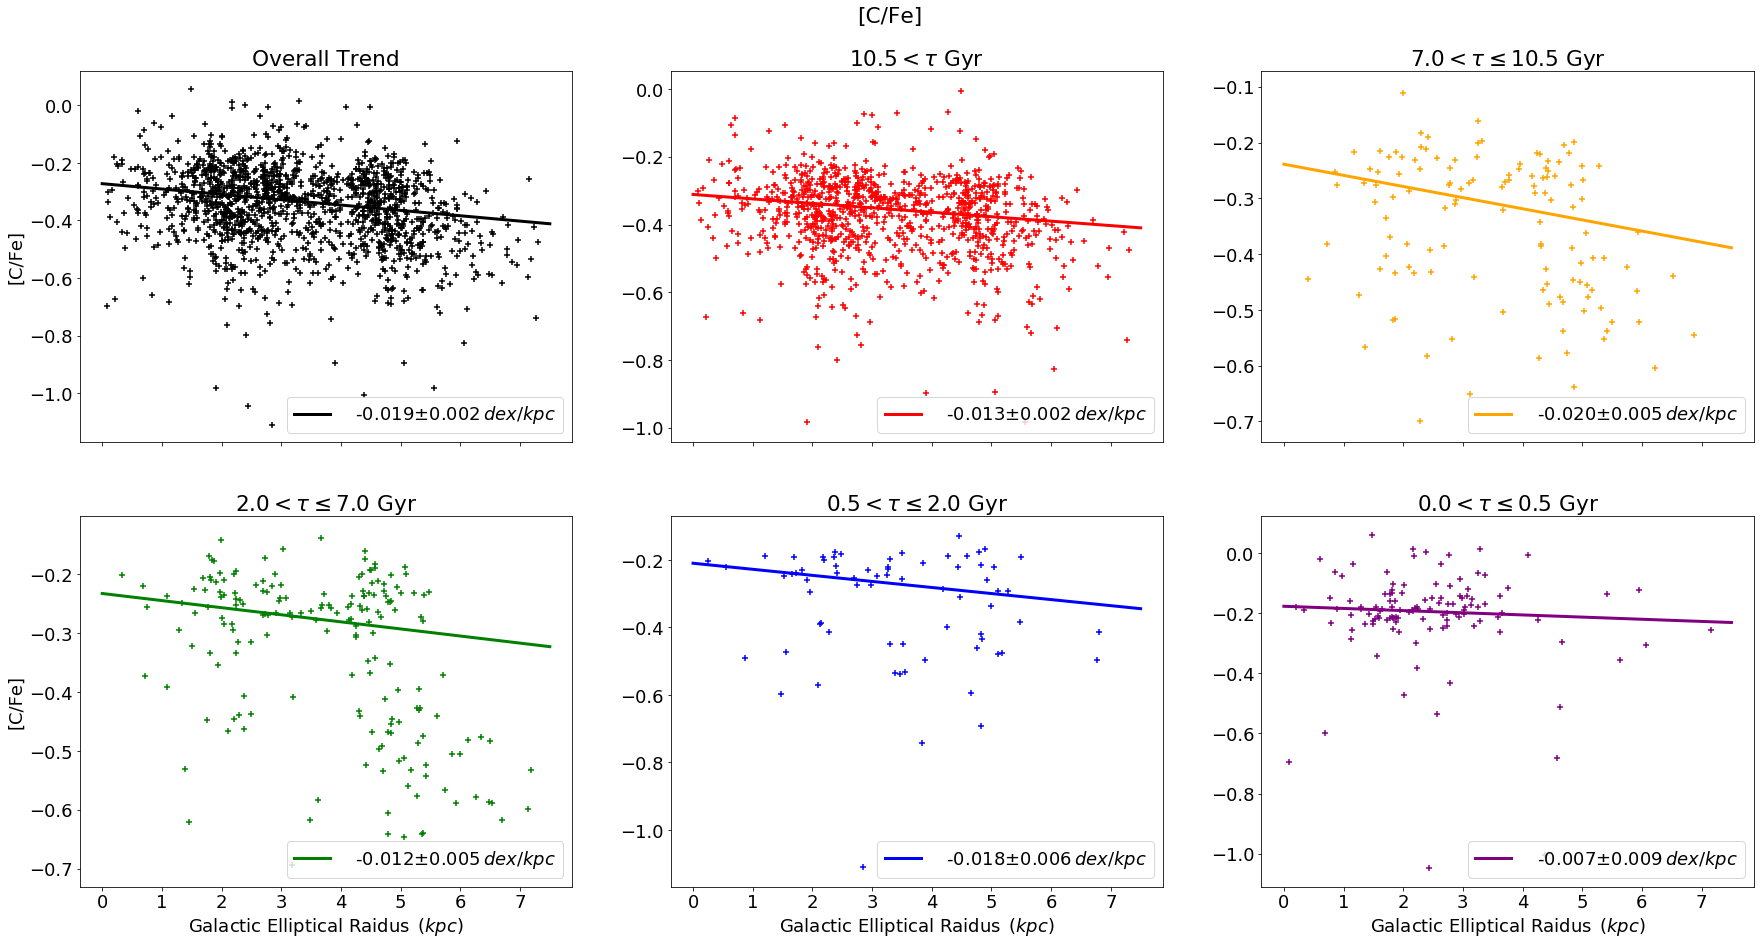

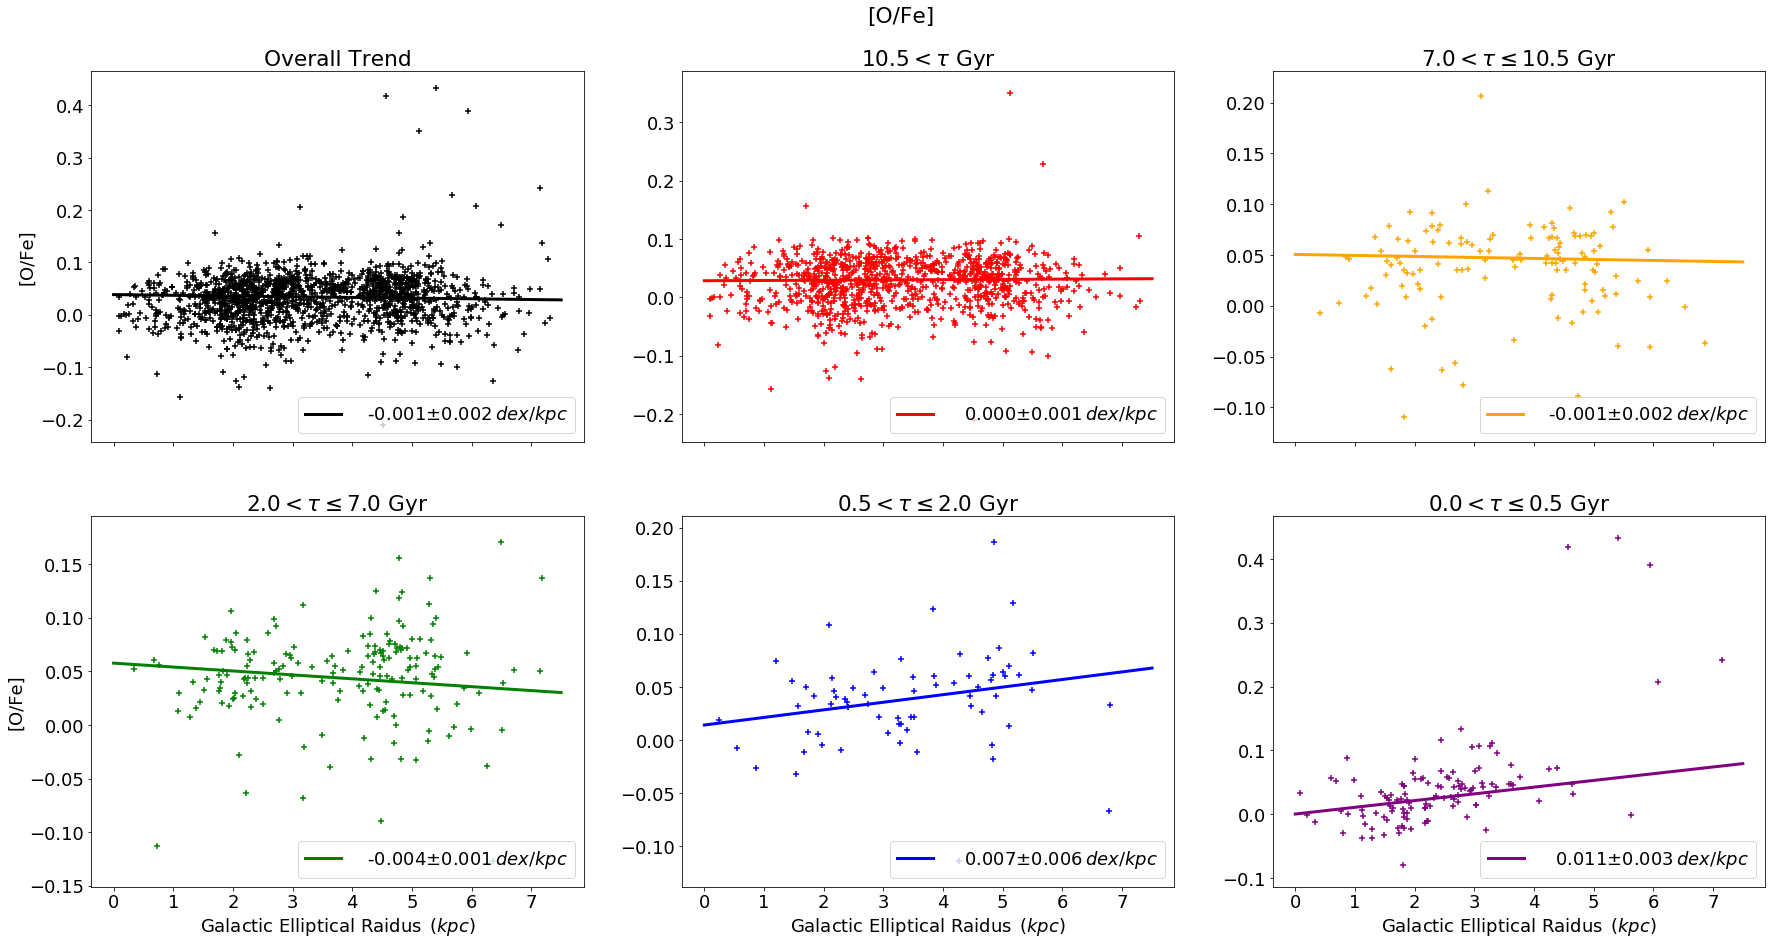

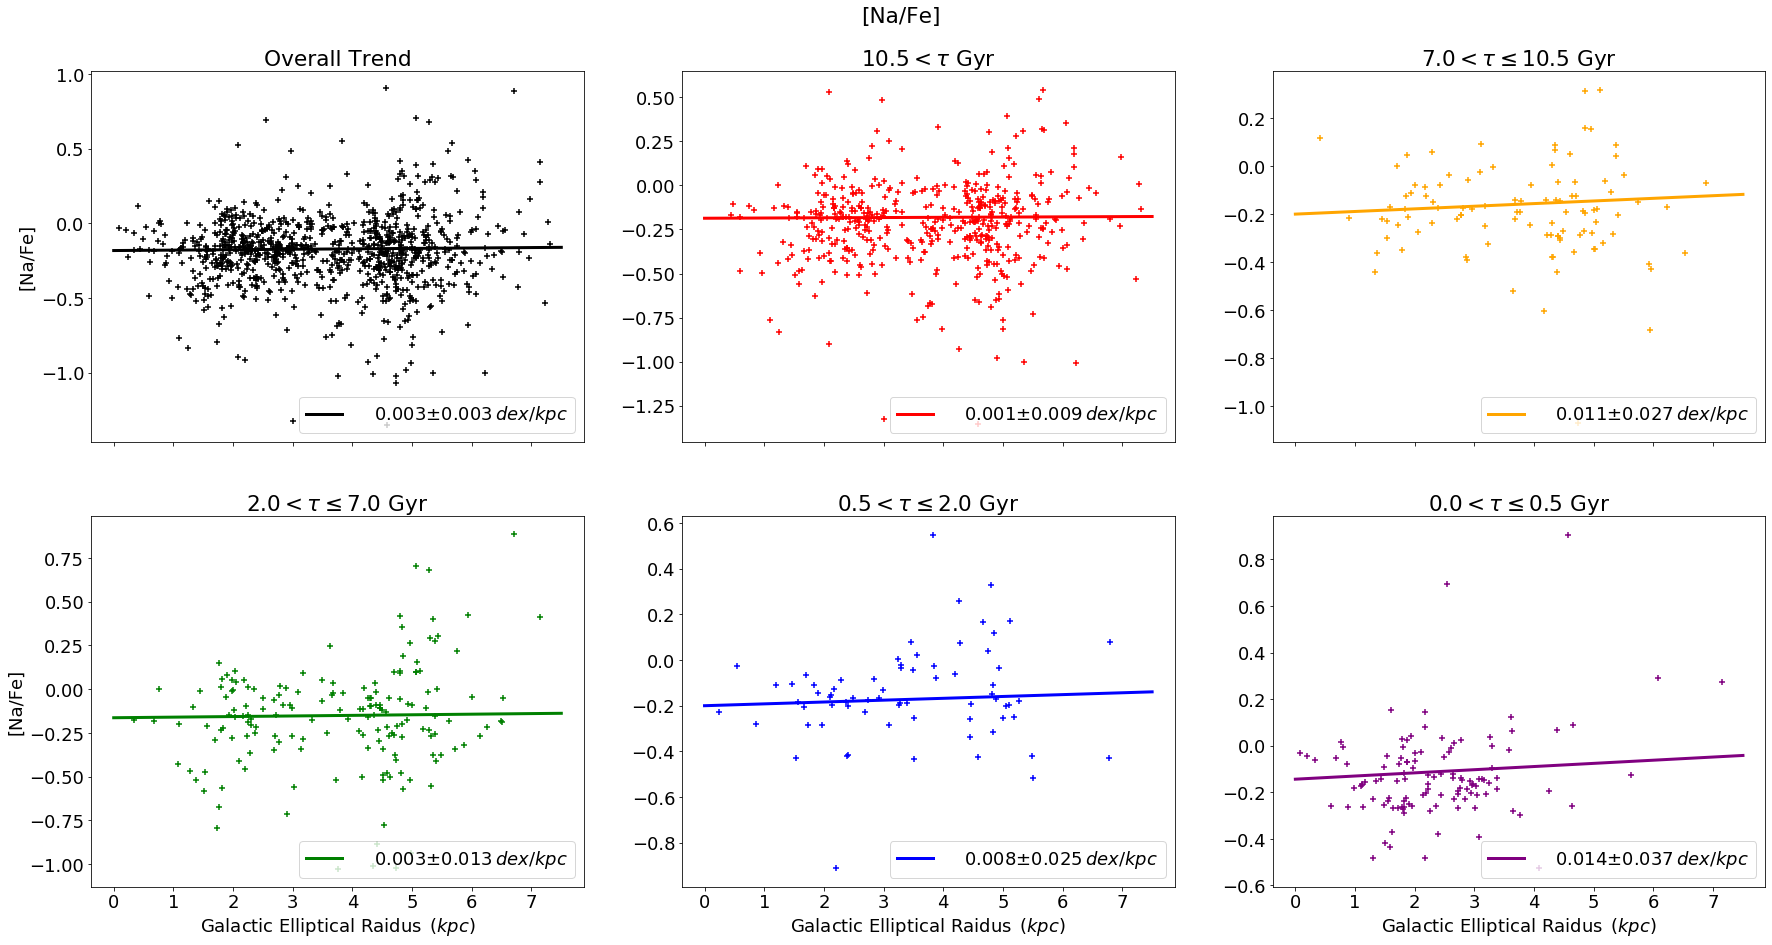

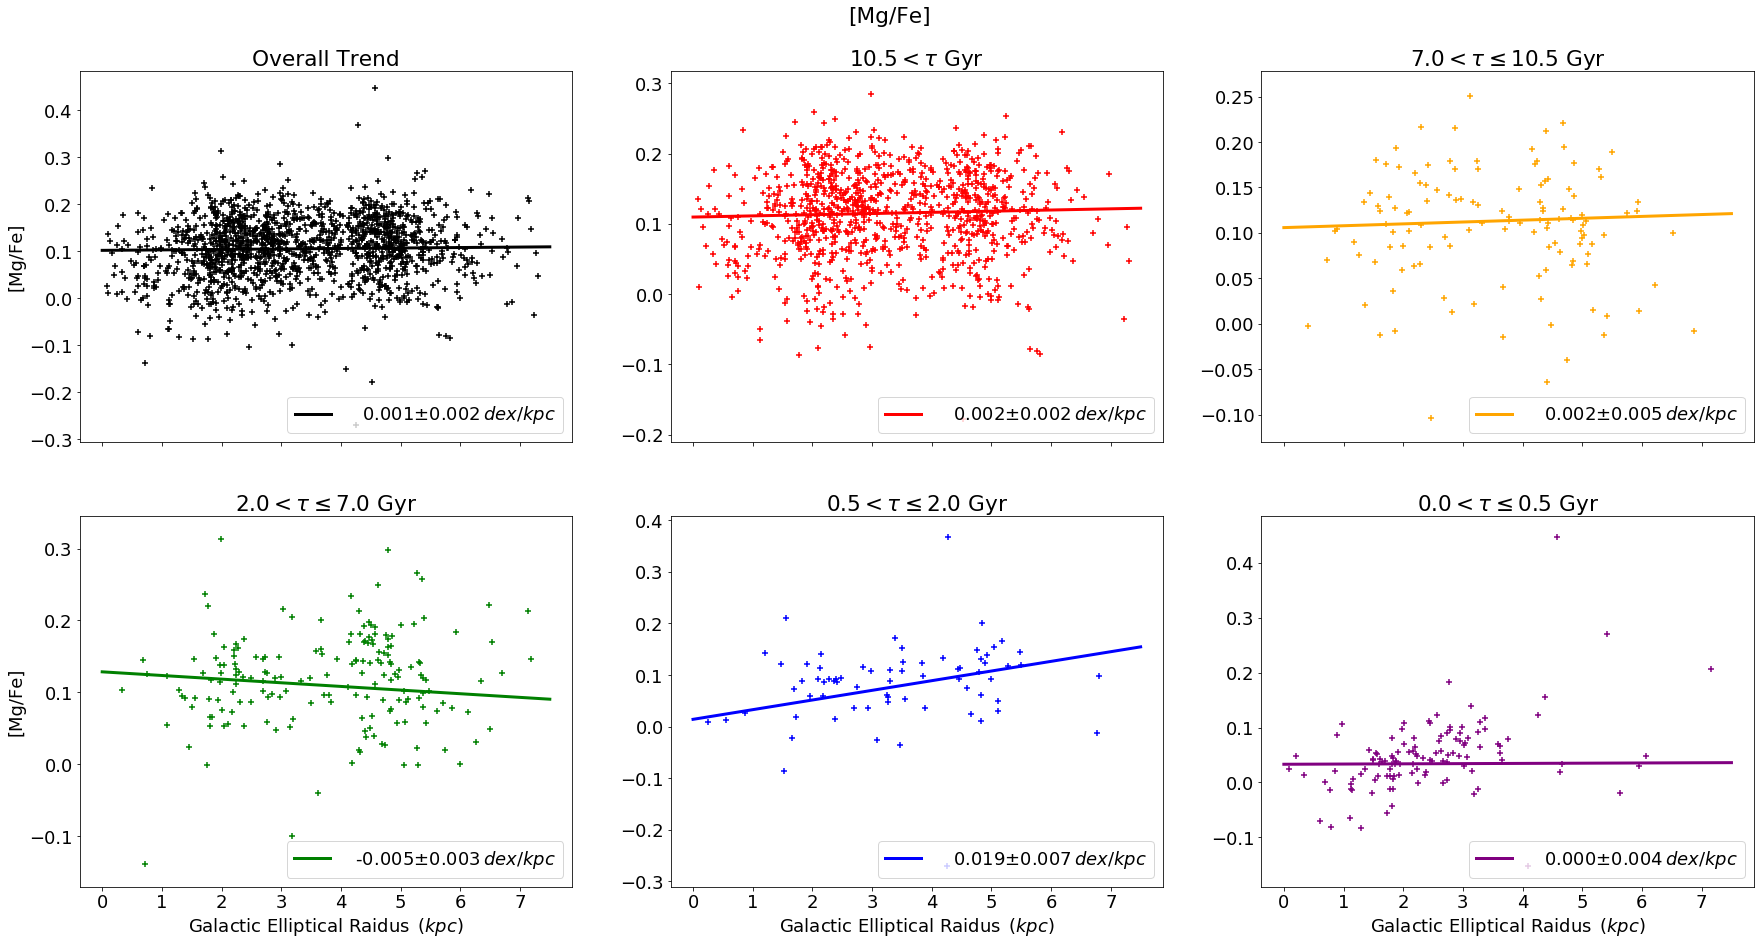

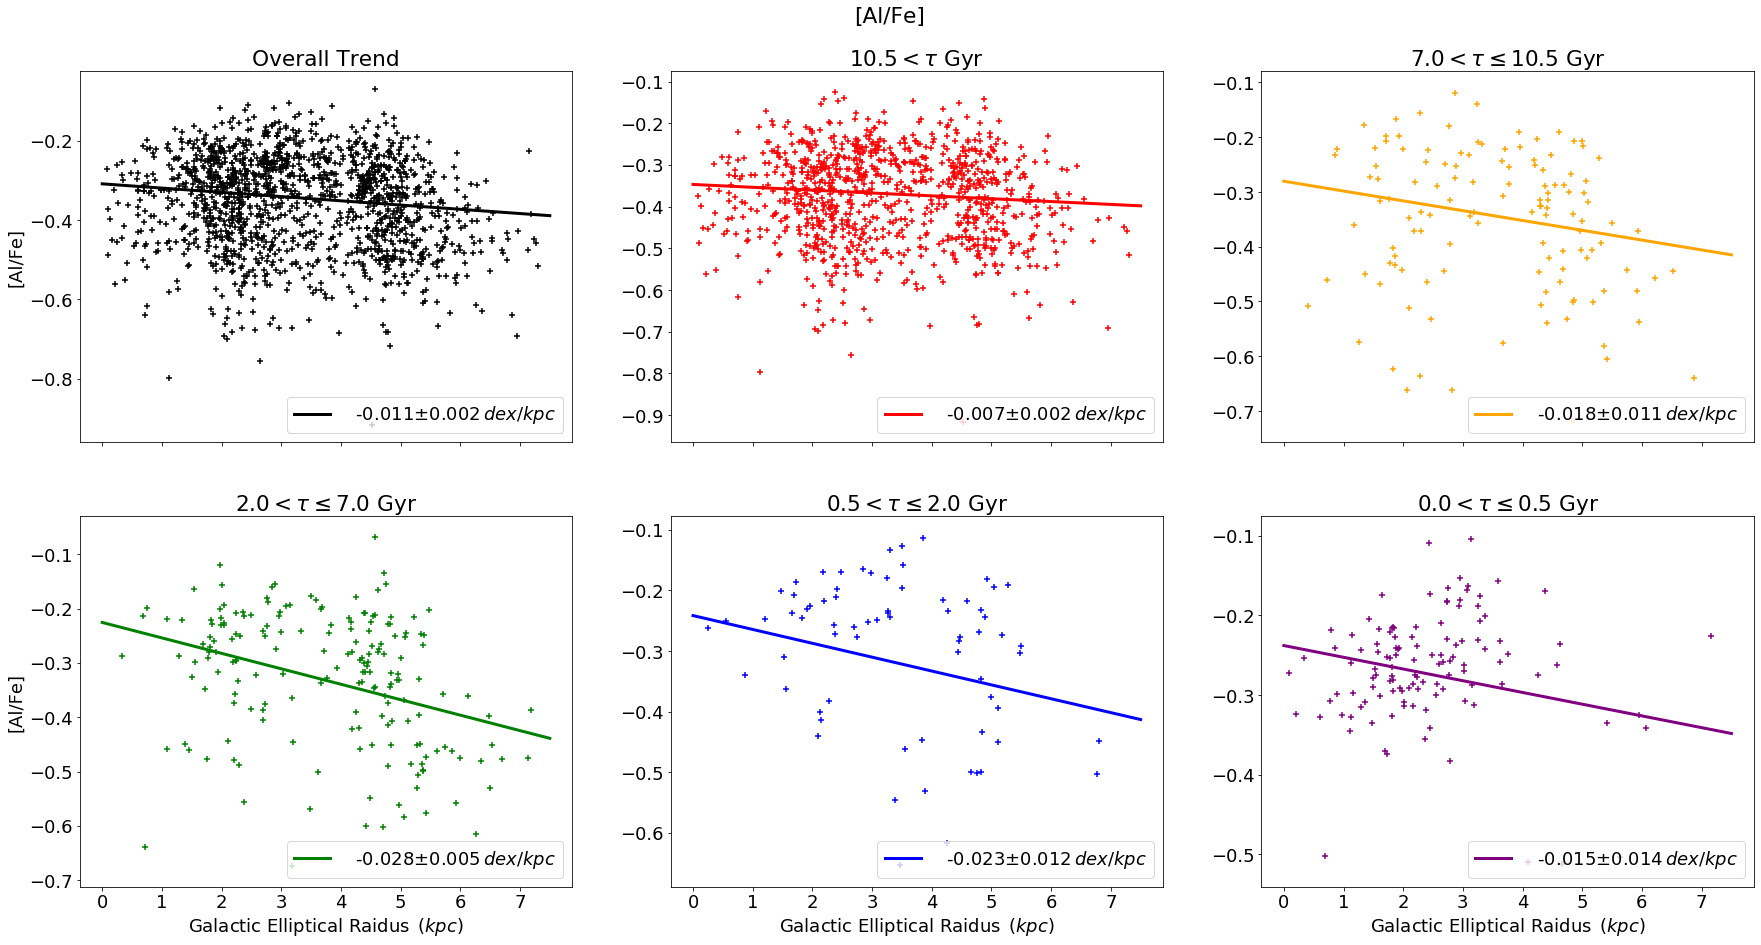

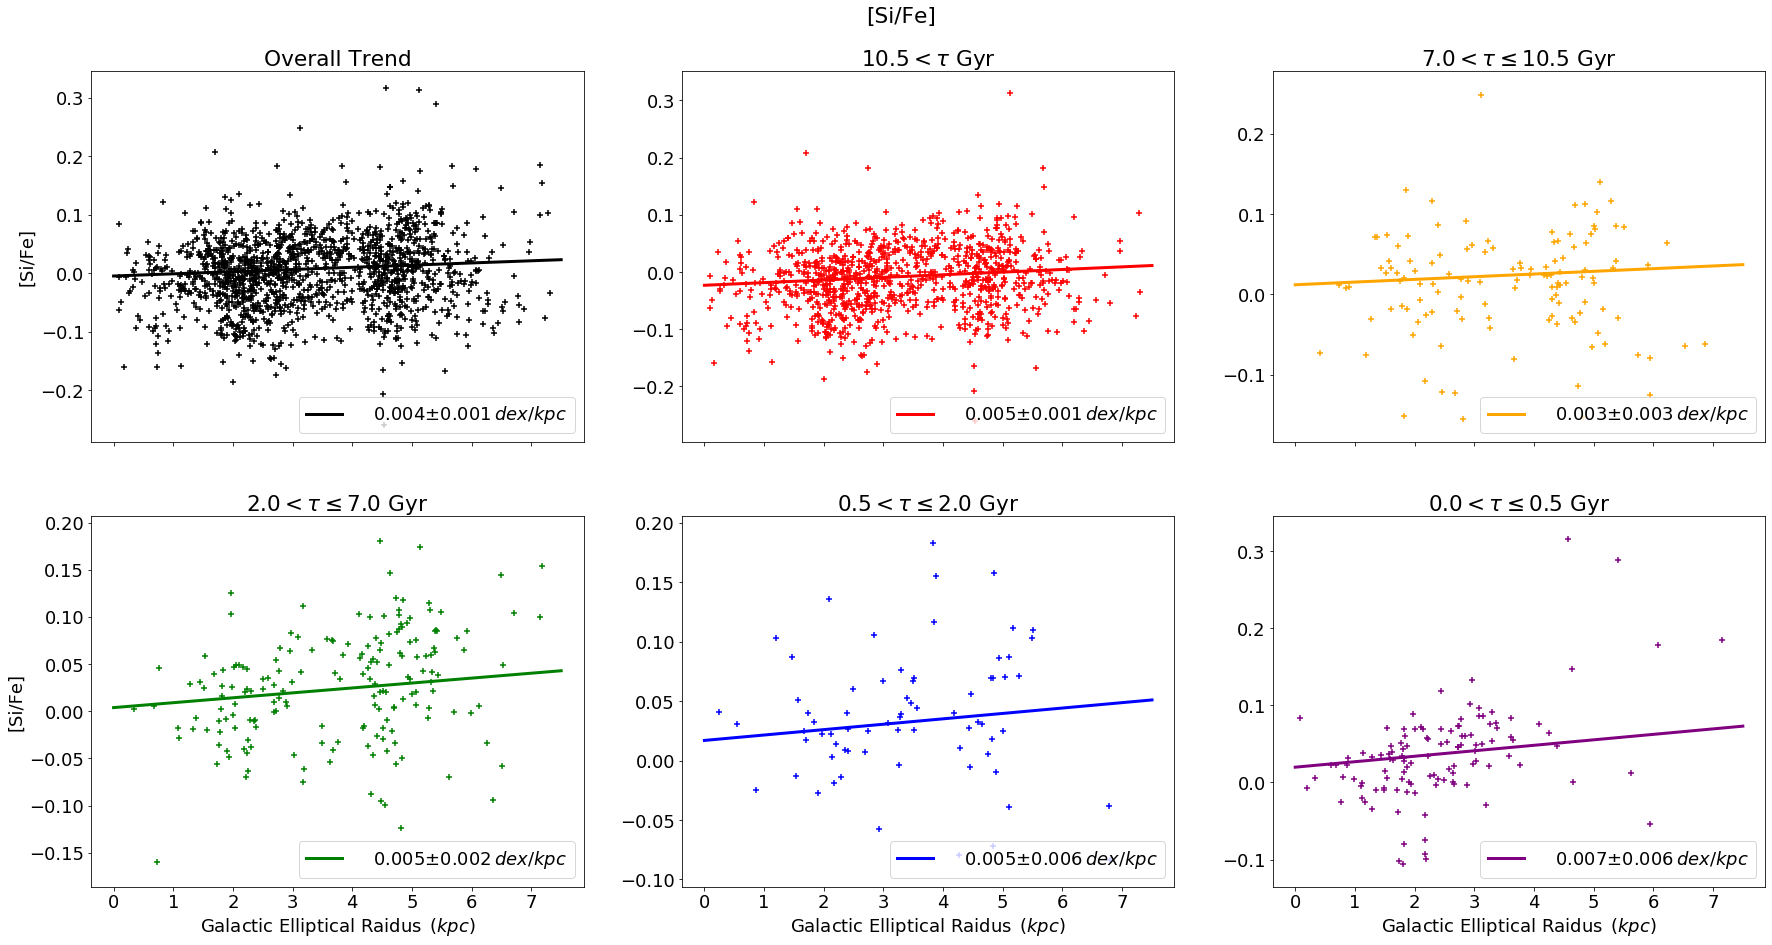

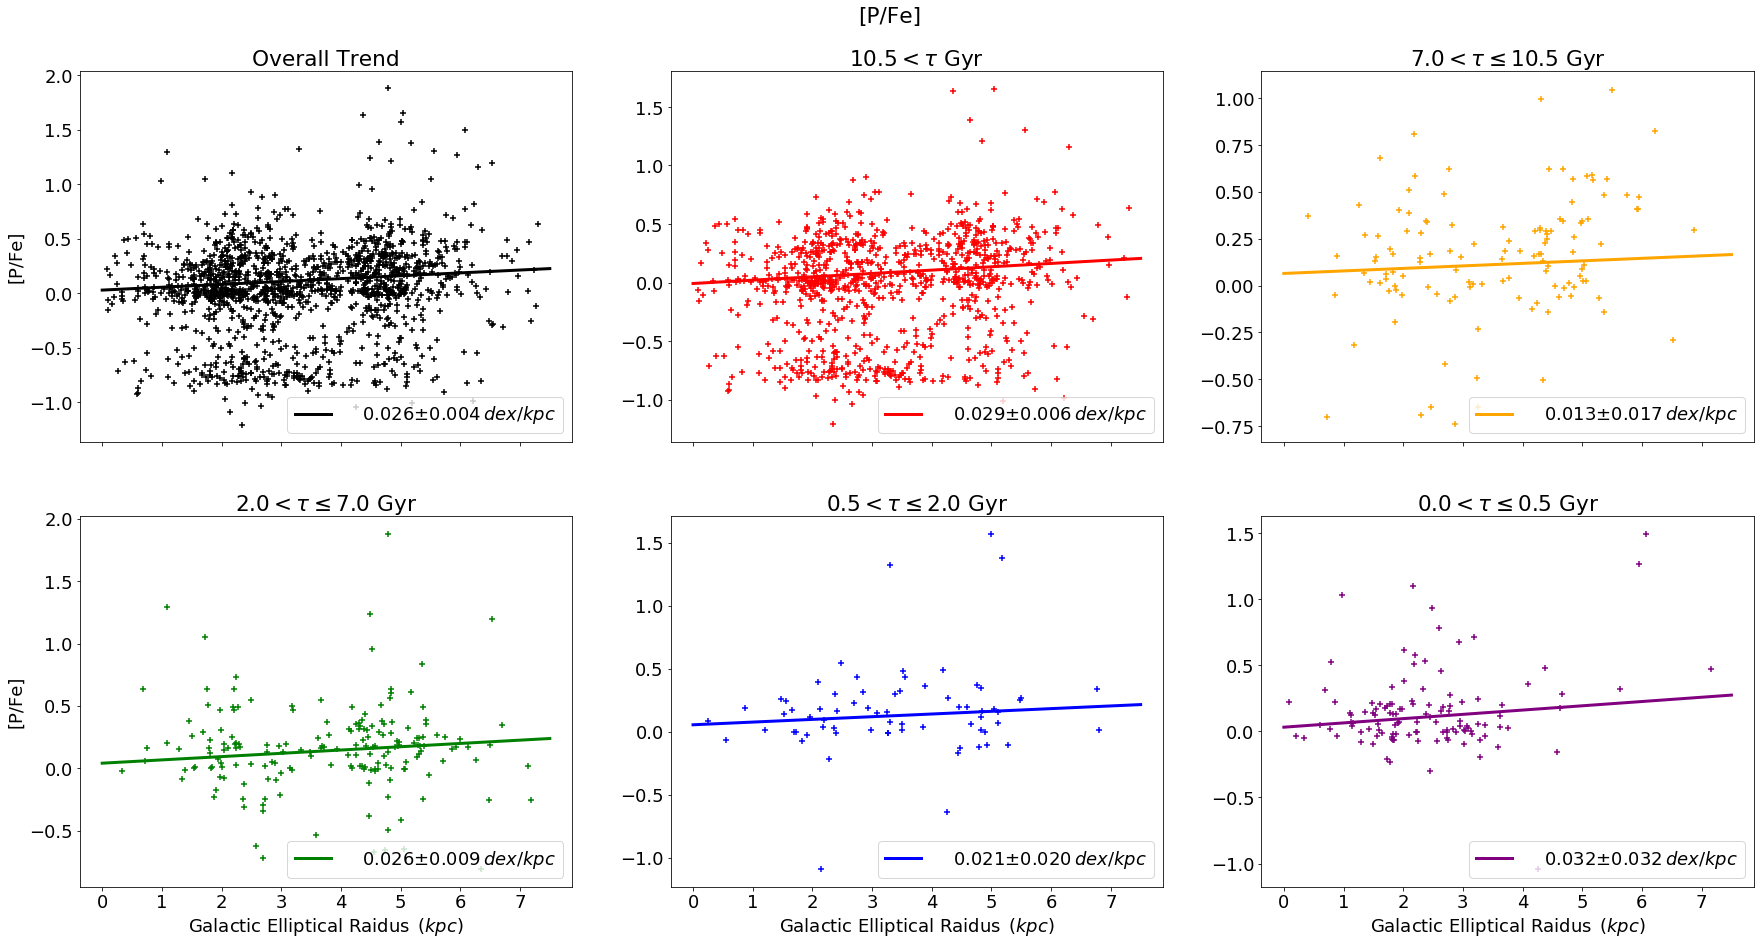

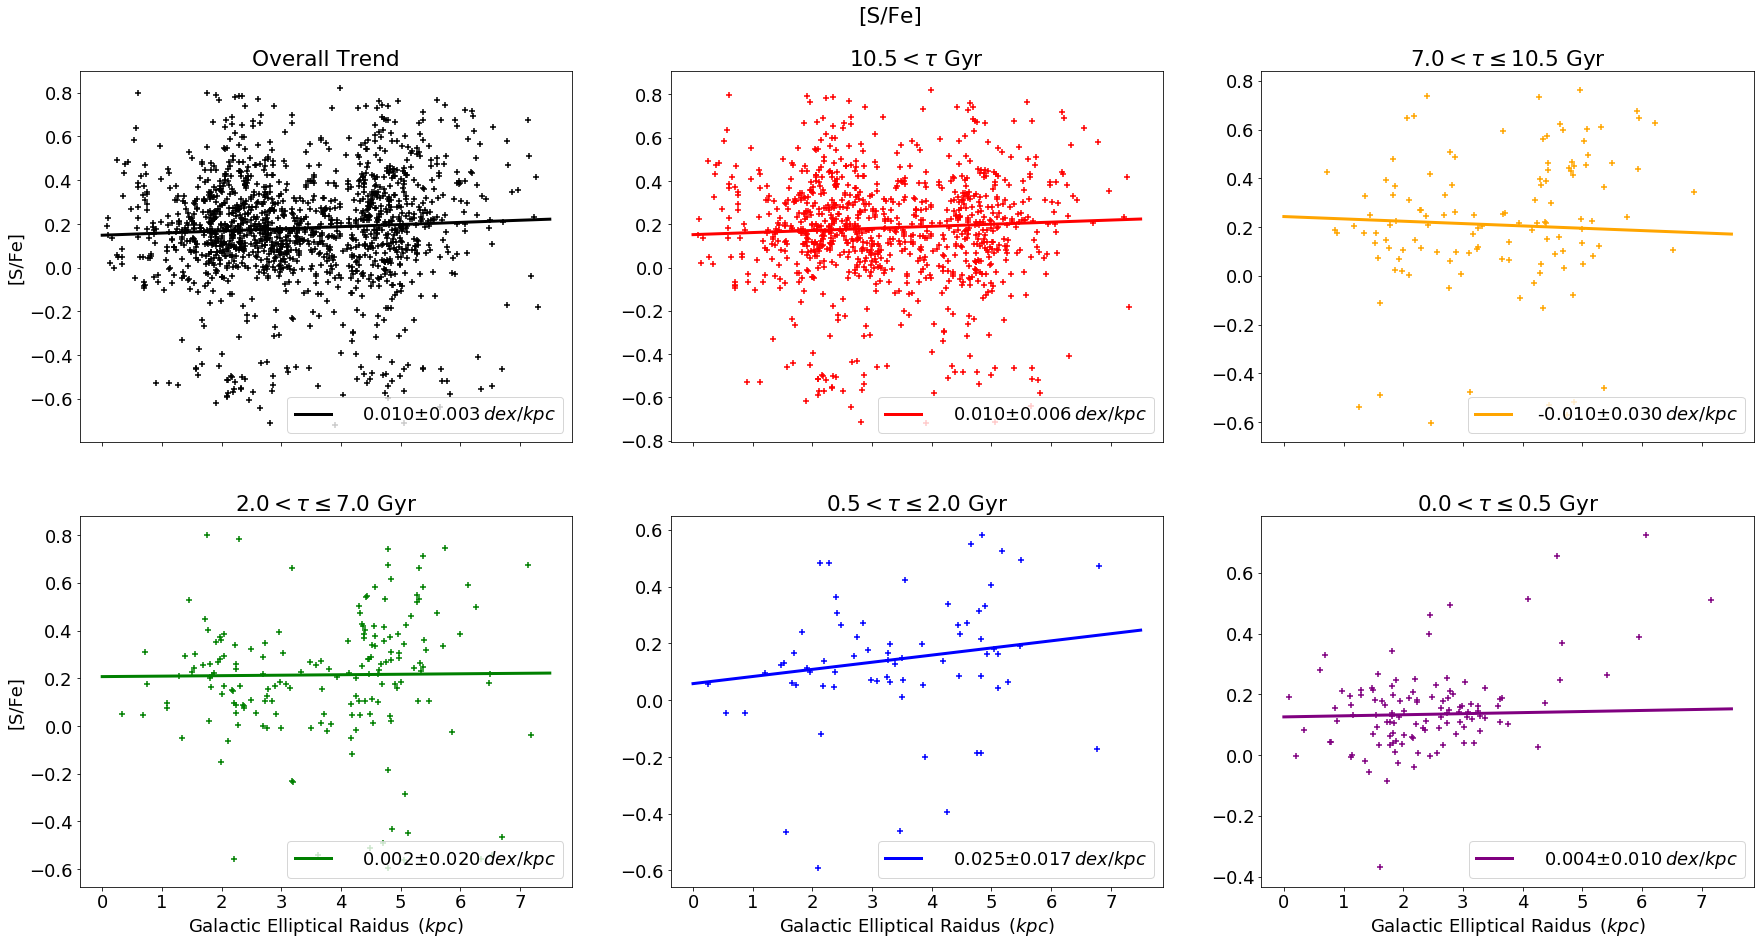

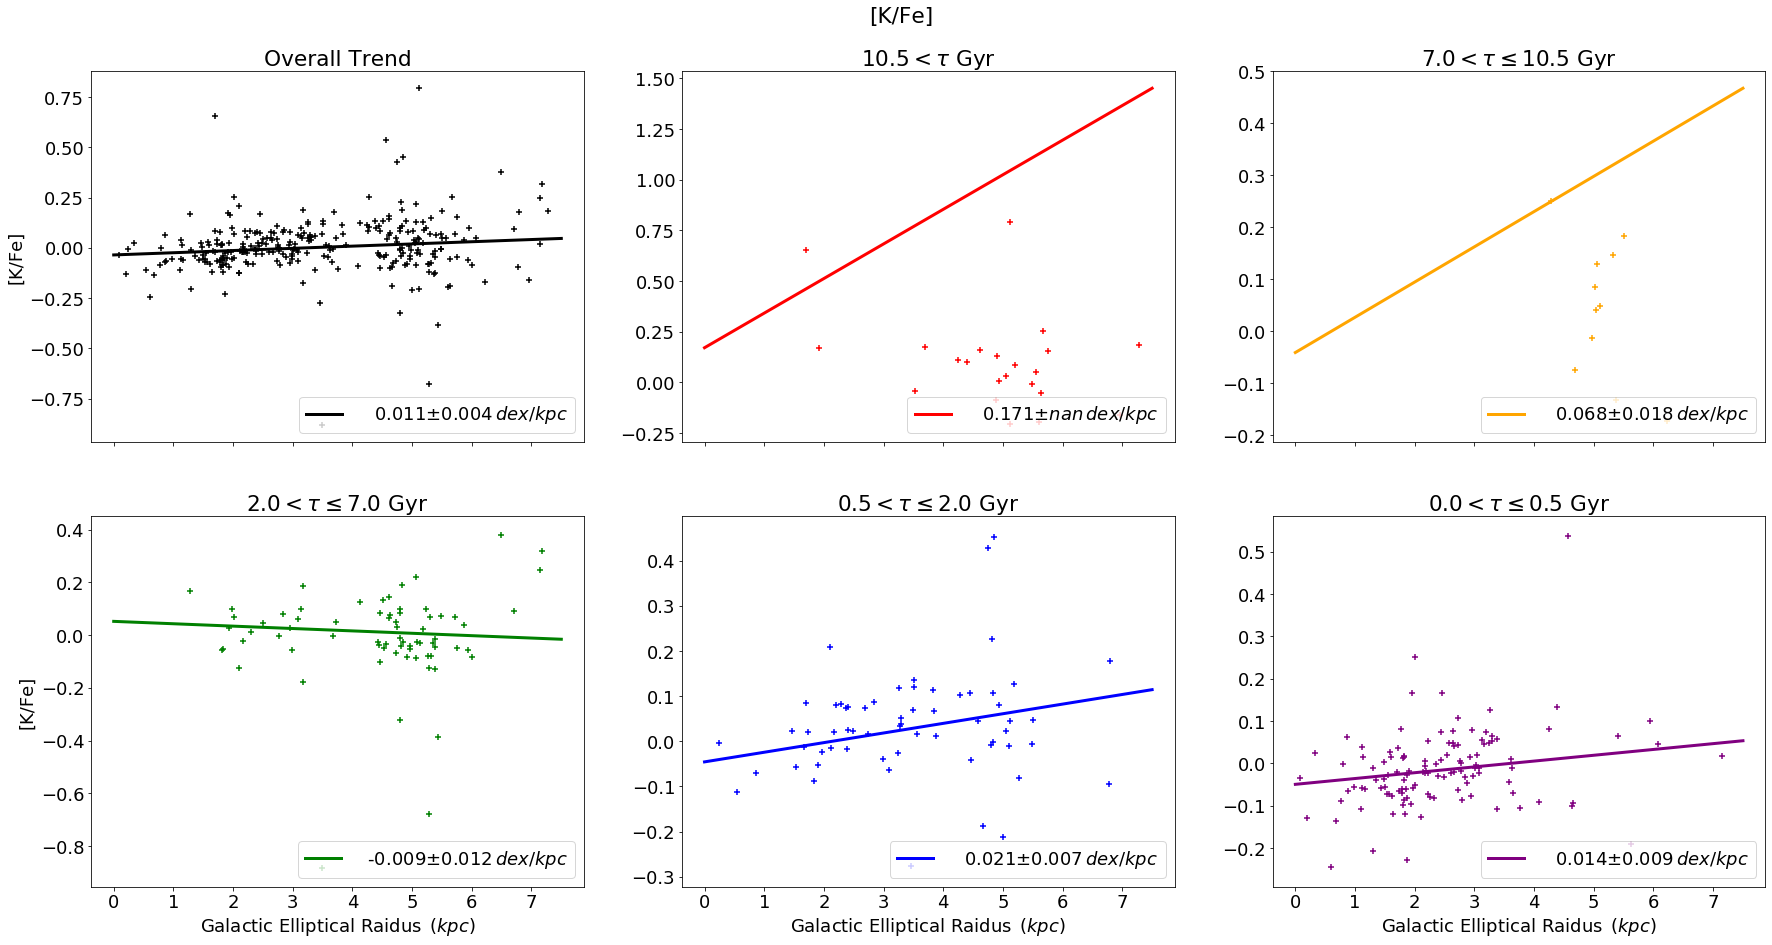

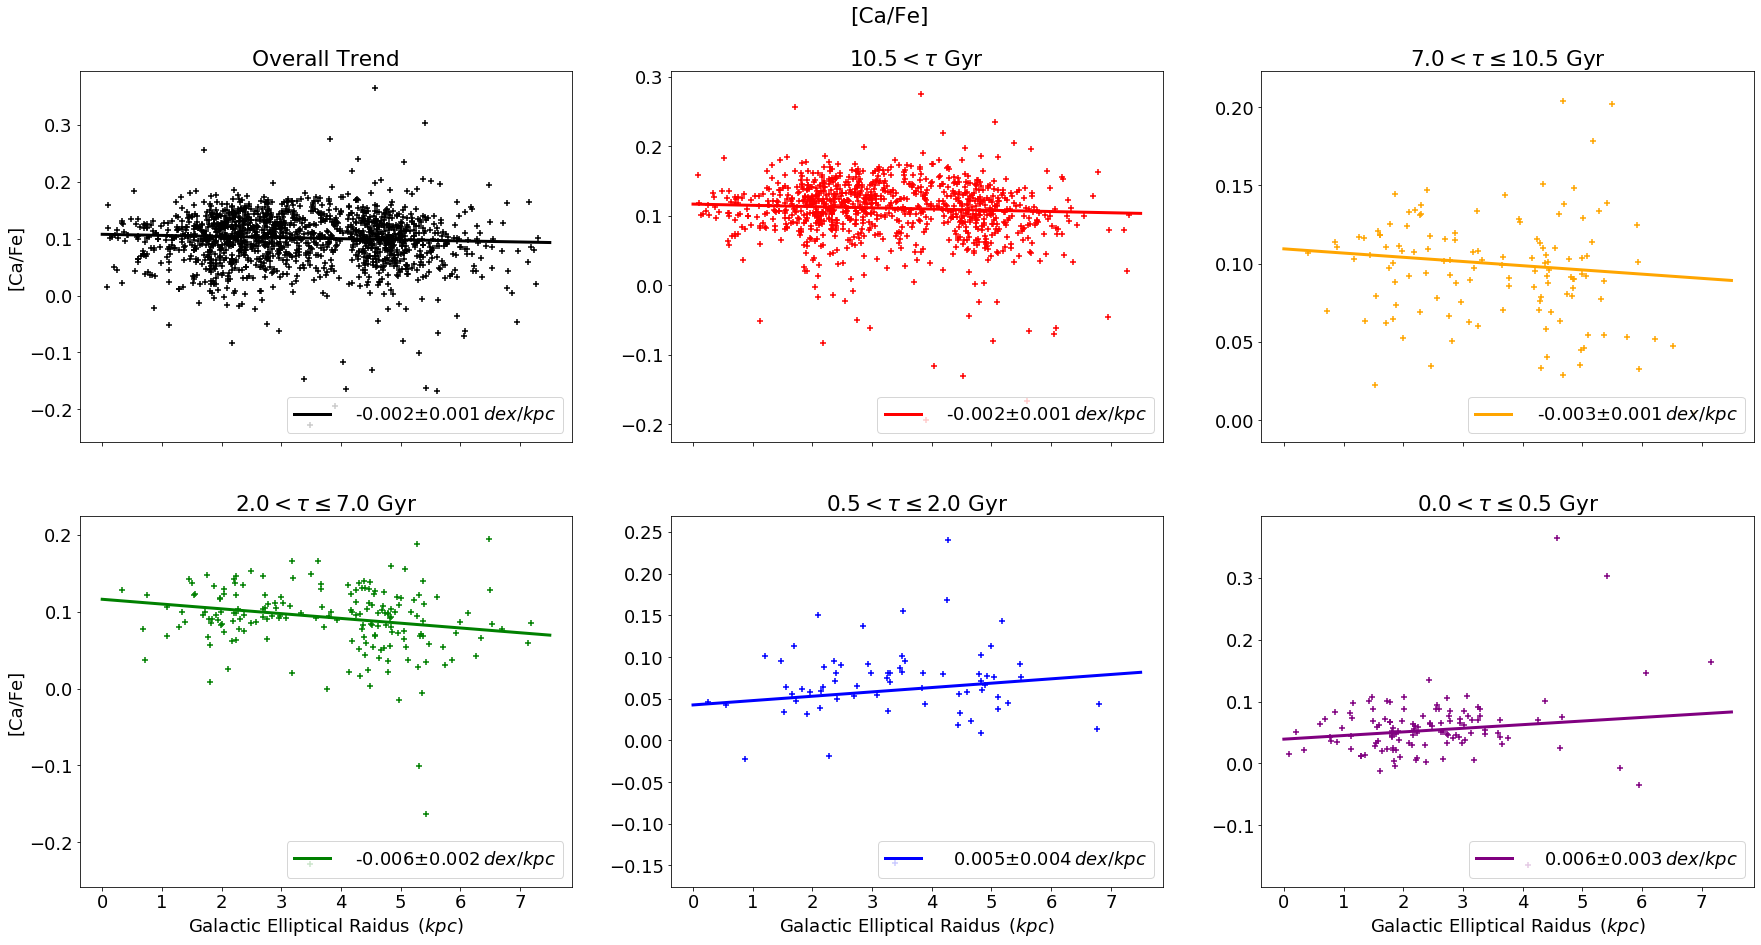

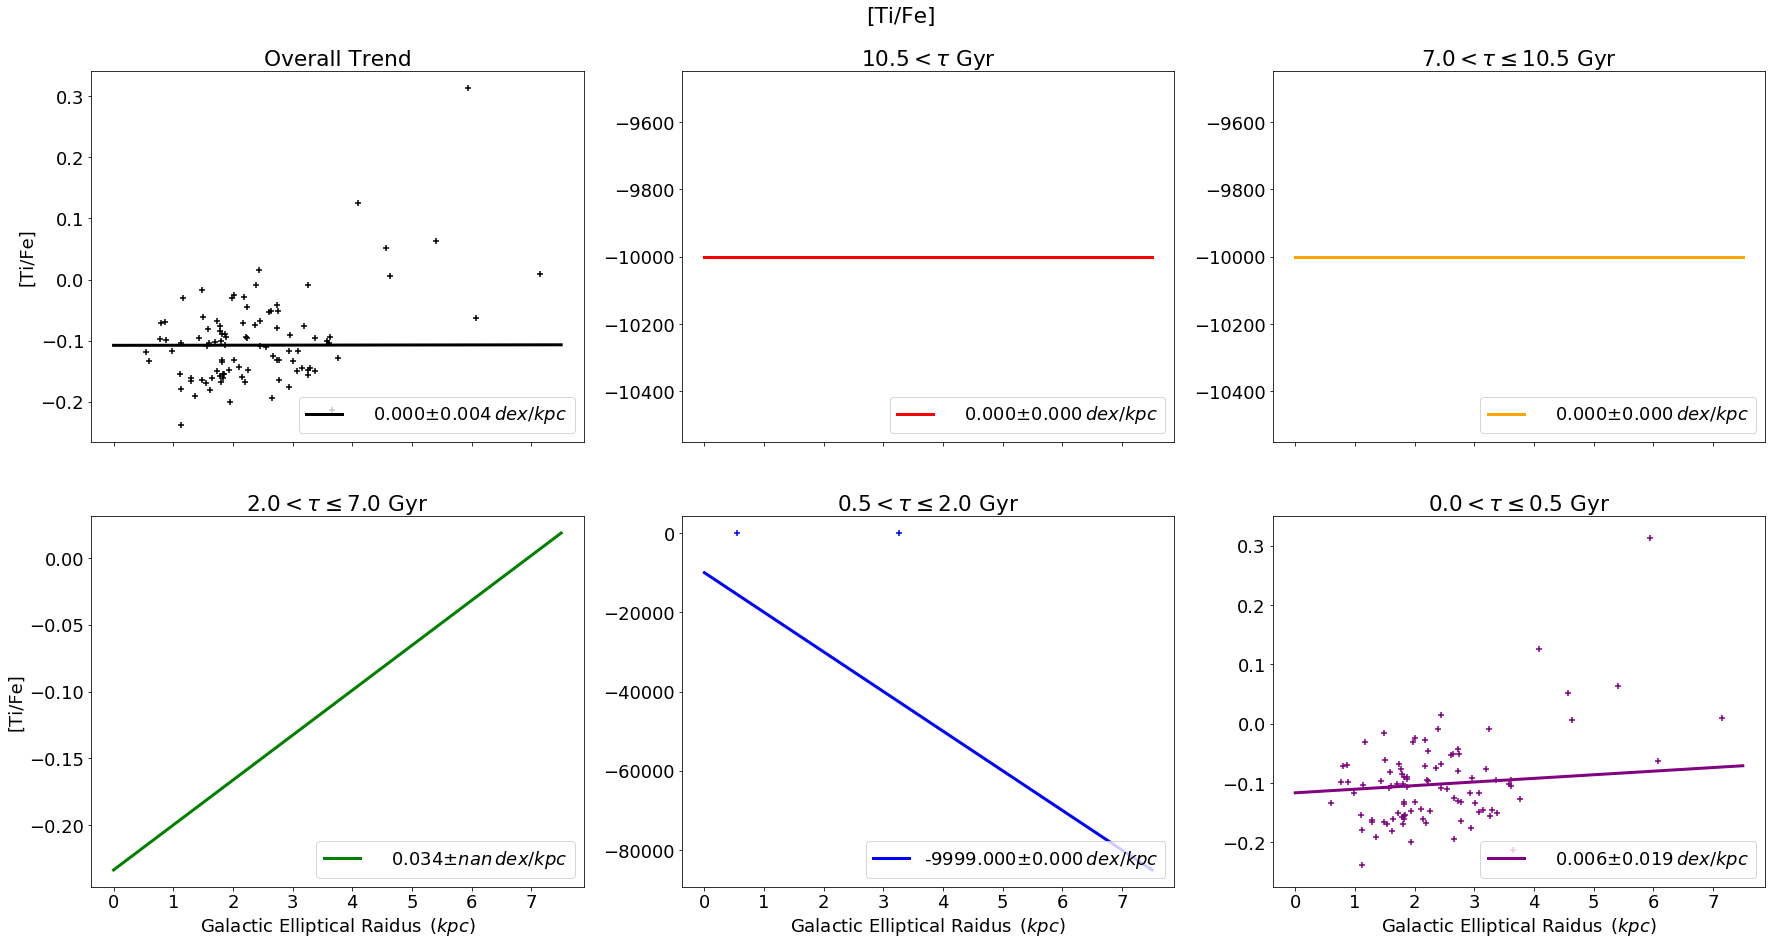

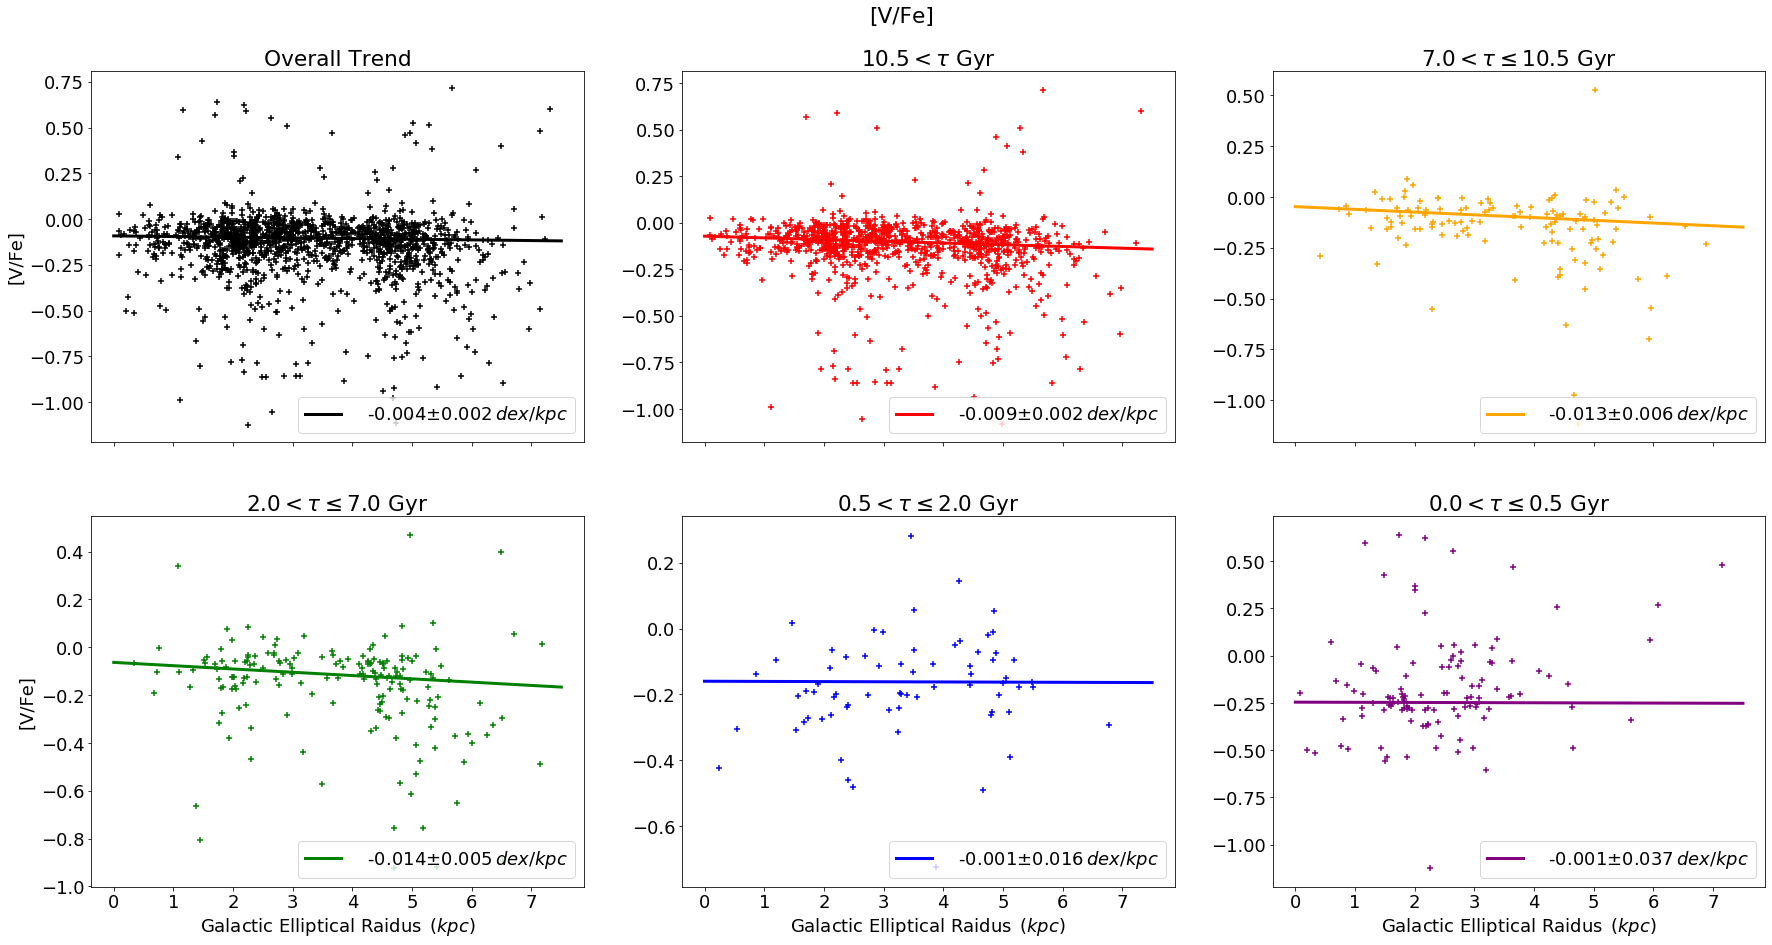

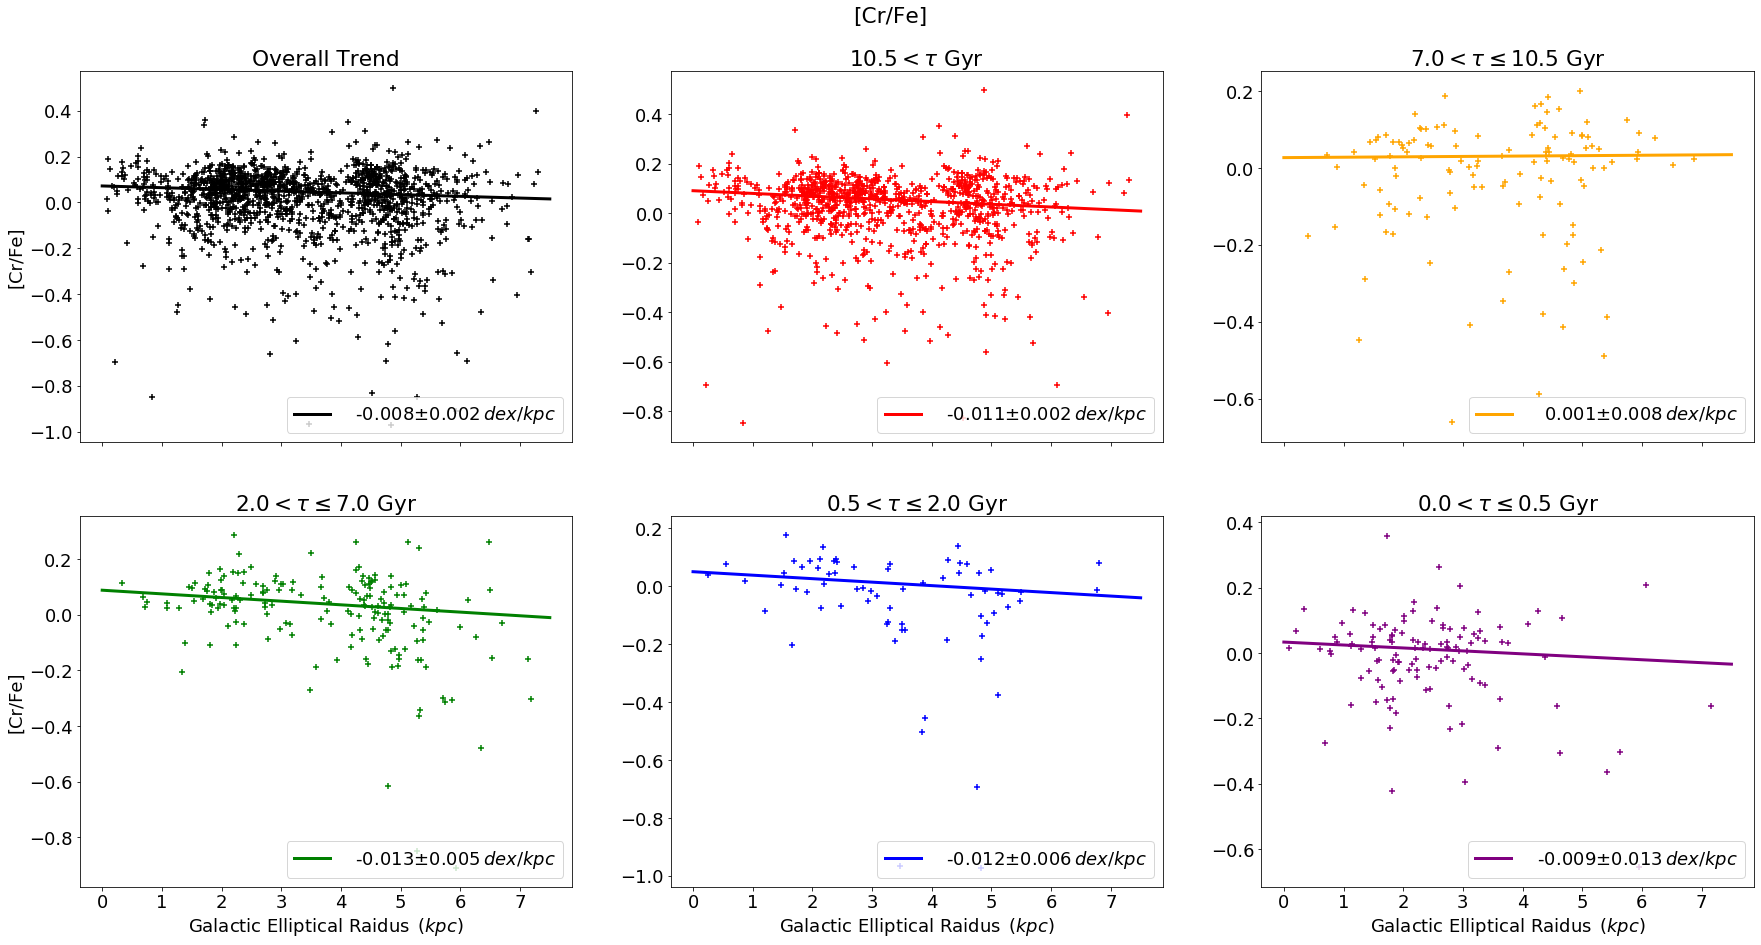

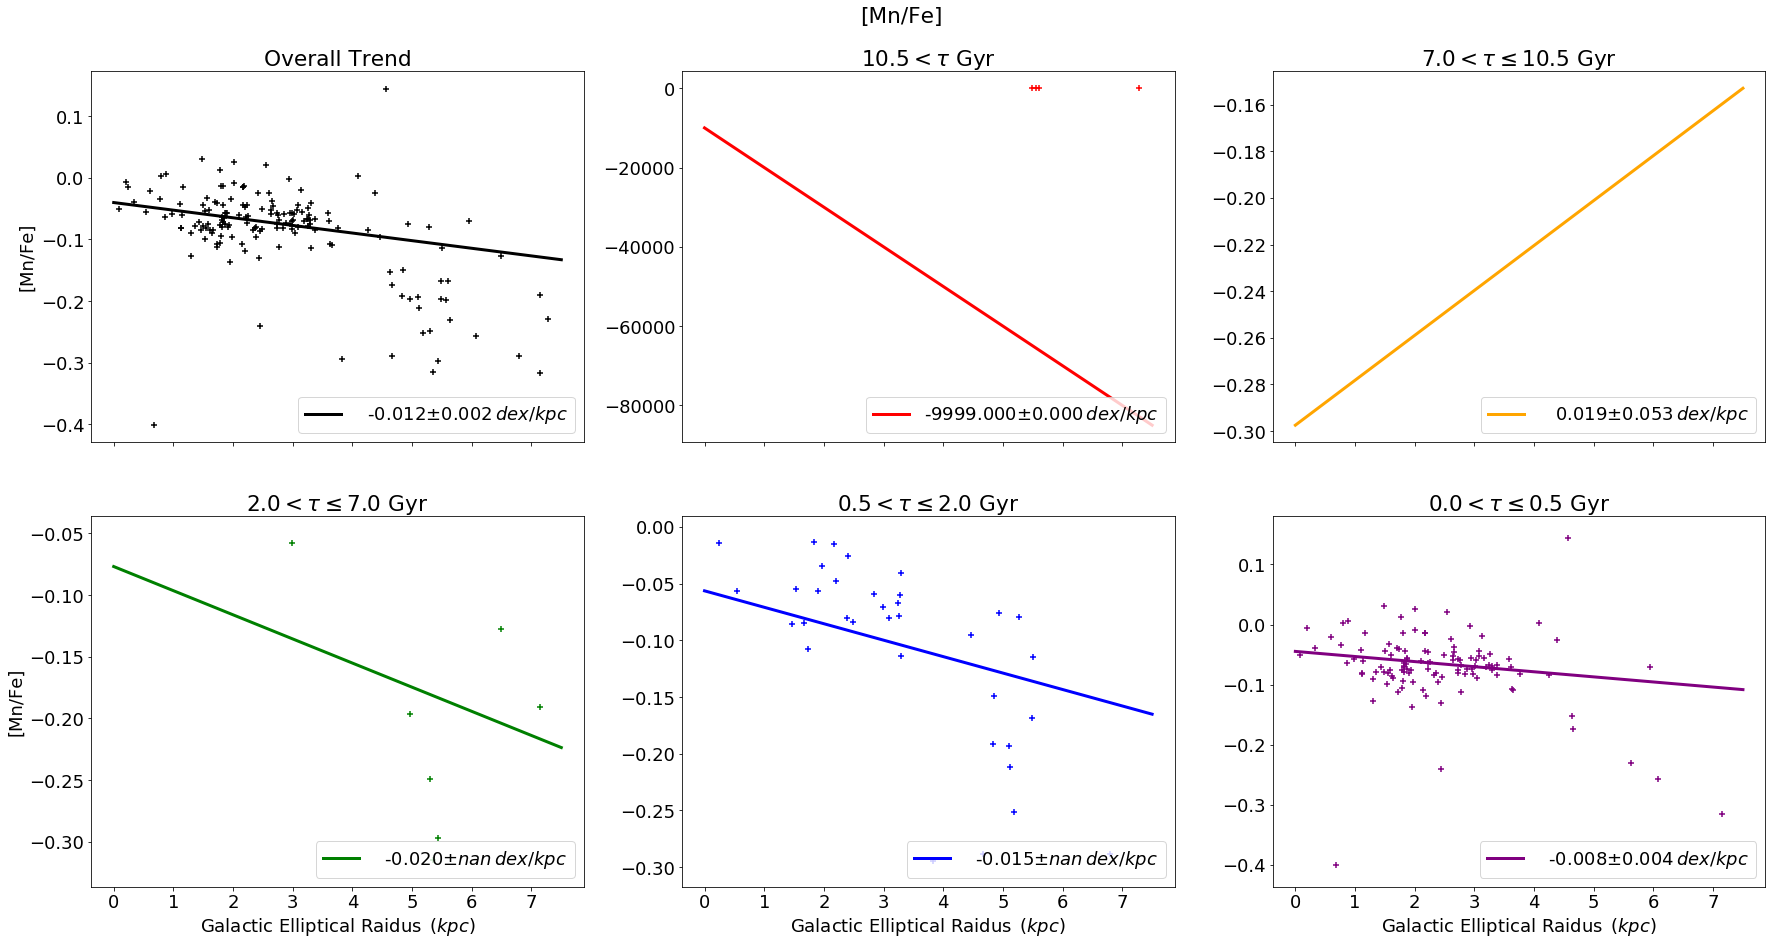

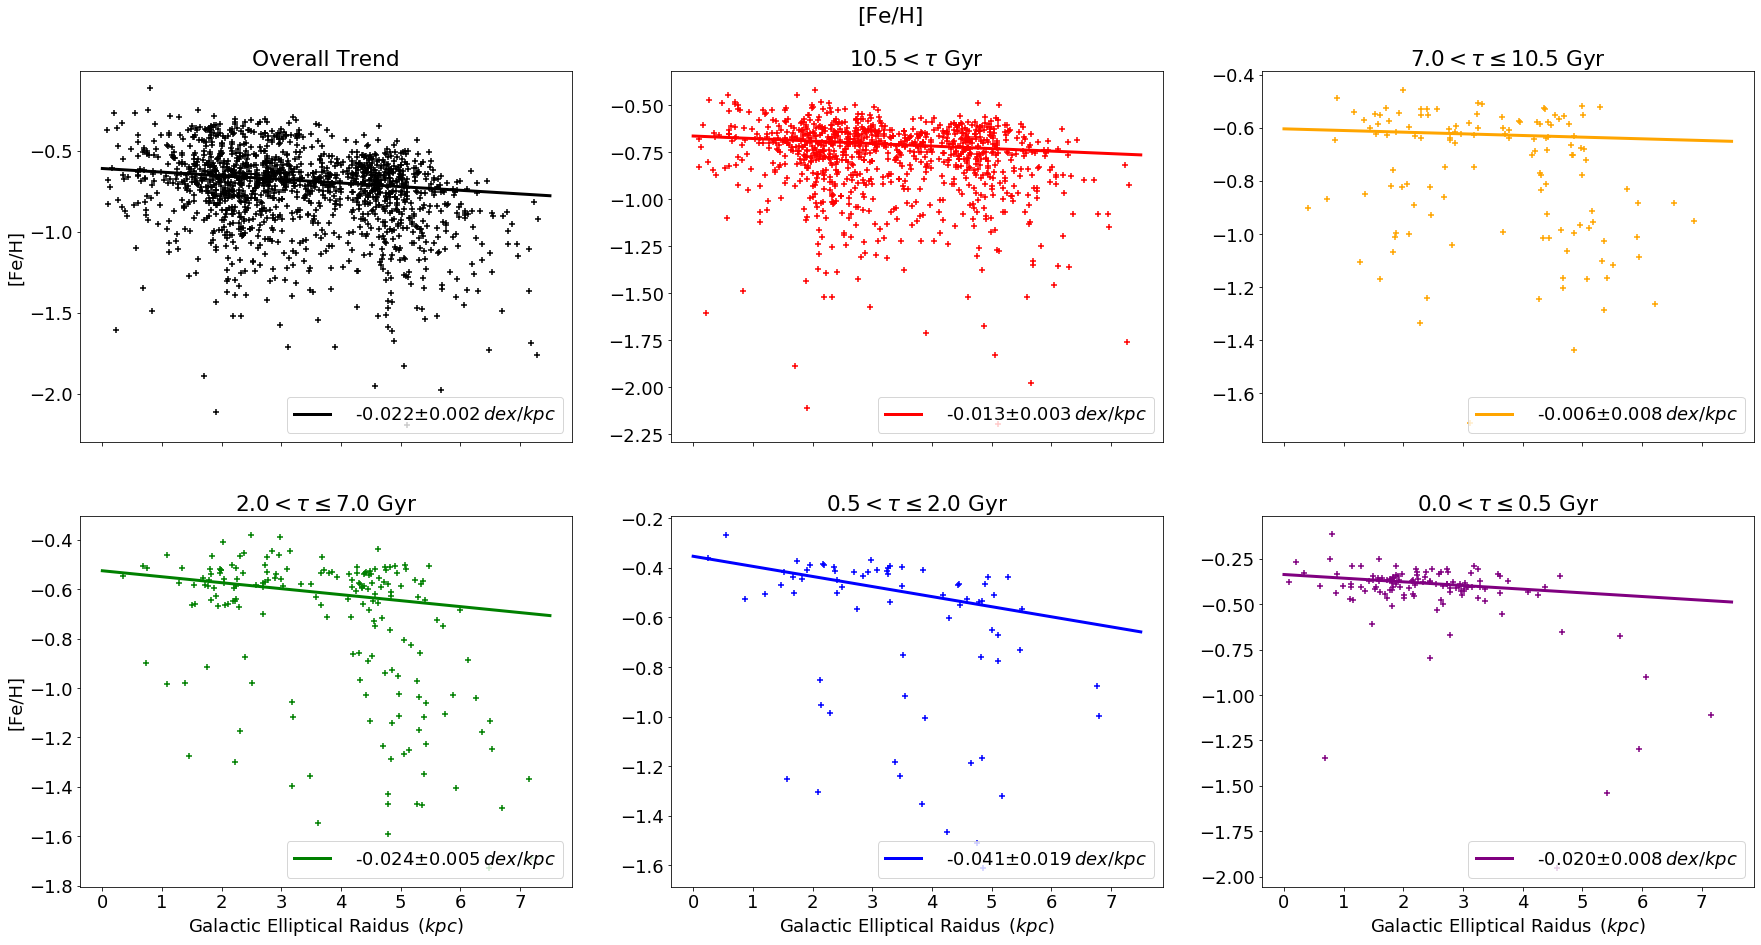

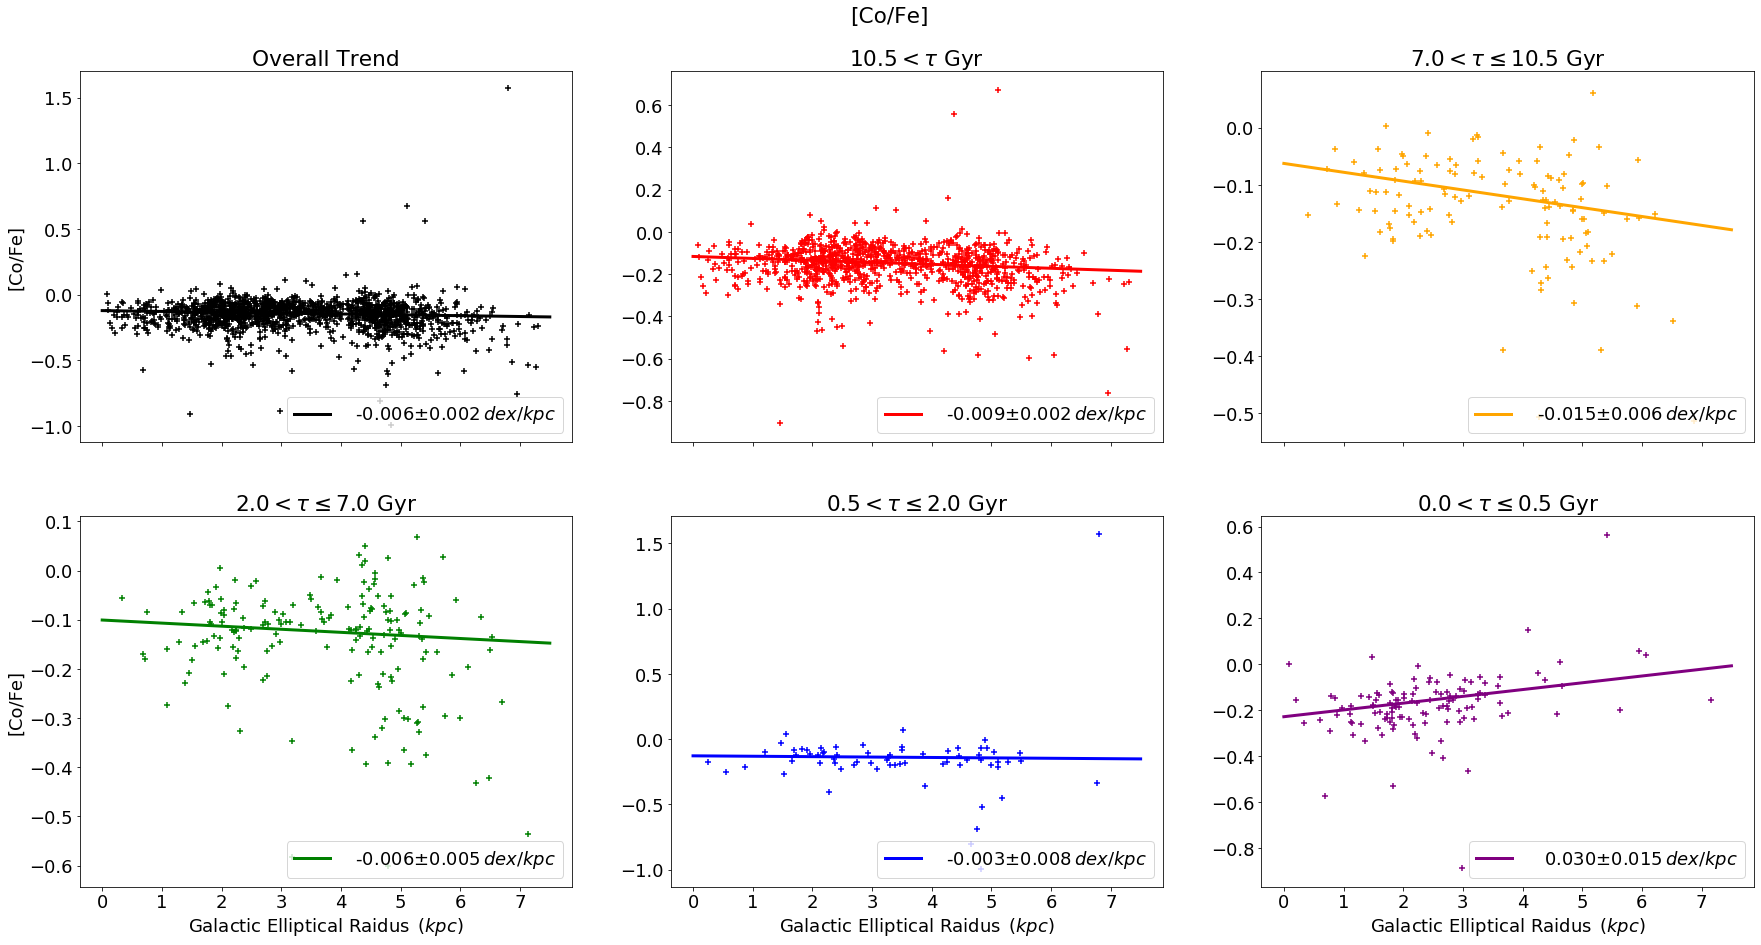

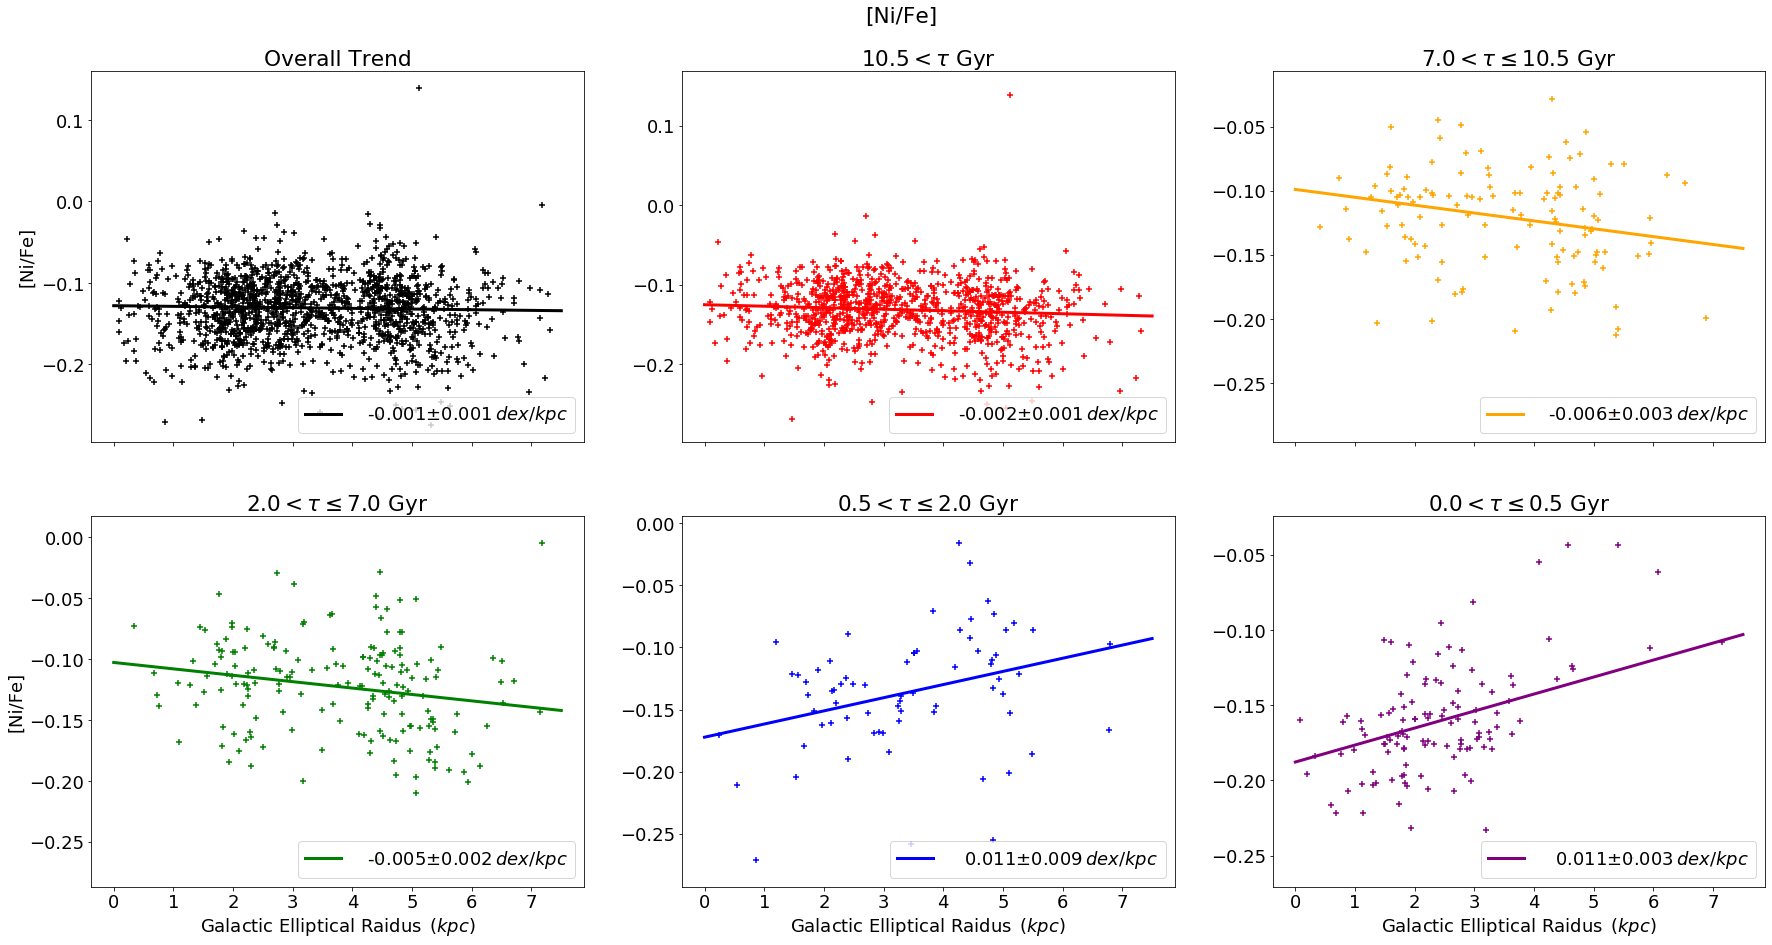

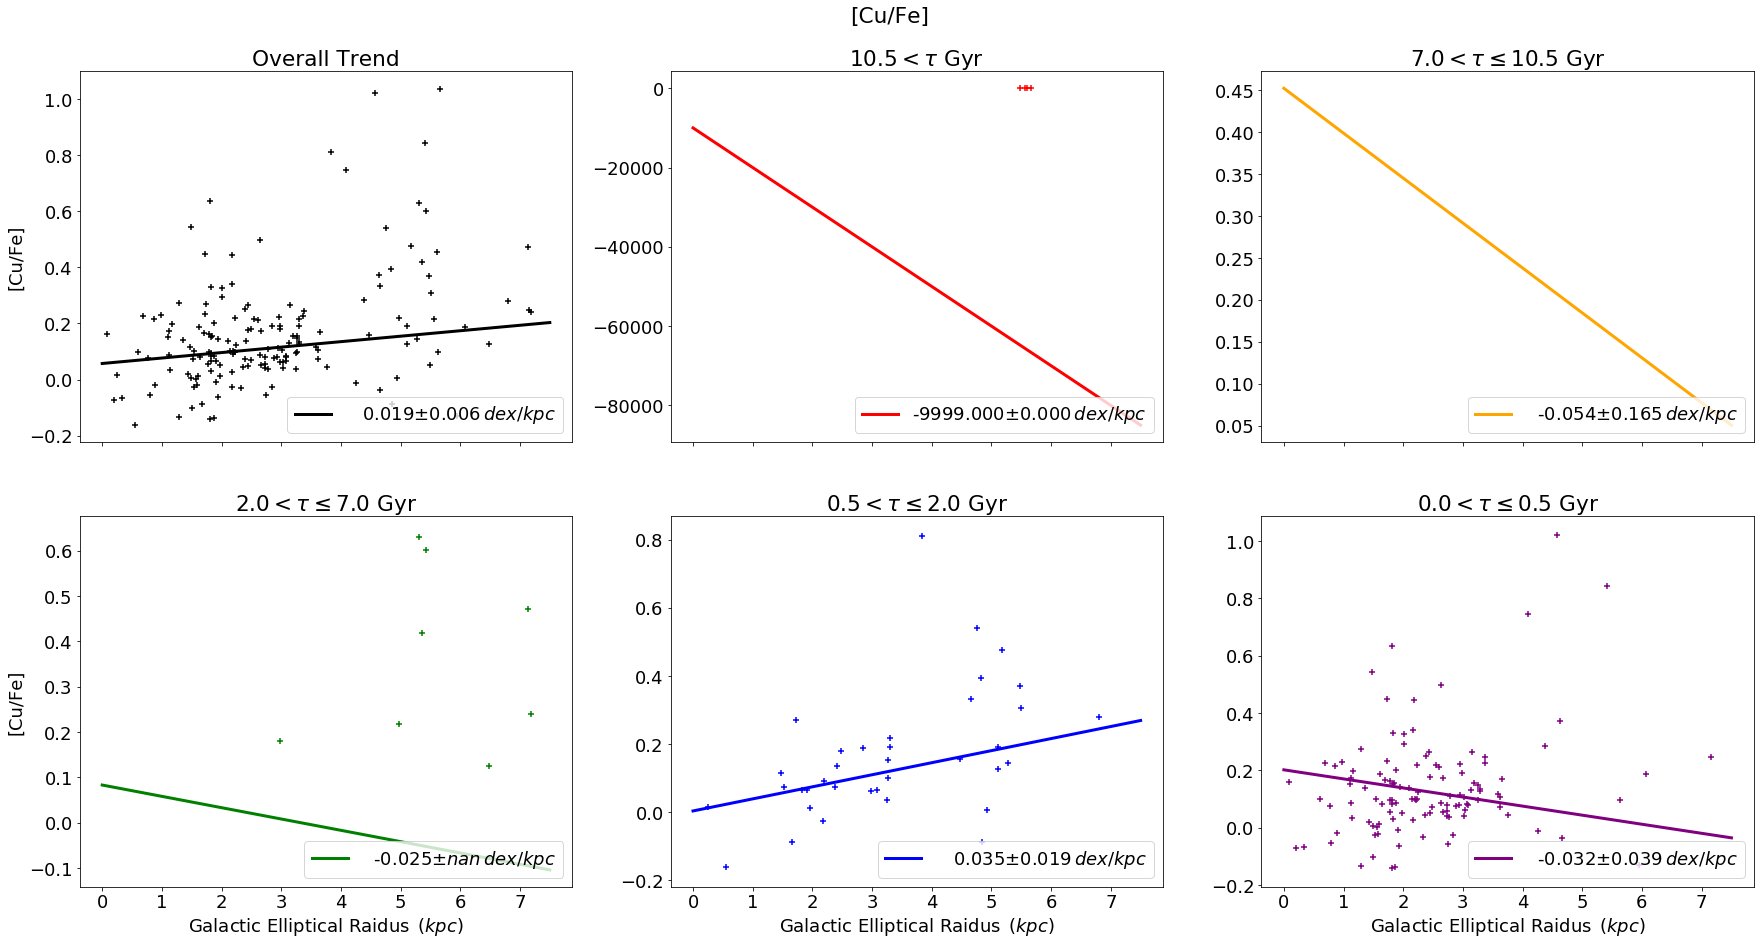

In [85]:
# radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = np.asarray(parages)[young]
yless_parage = np.asarray(parages)[yless]
ymed_parage = np.asarray(parages)[ymed]
omed_parage = np.asarray(parages)[omed]
old_parage = np.asarray(parages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    
    young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    yless_cln = np.where((r13yless[elems[i]]>-100)&(r13yless['SNR']>=100))
    ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    over_cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
    
    f, ax = plt.subplots(2,3, facecolor='w',sharex = True, figsize=(30,15))
    
    ### young
    ax[1,2].scatter(np.asarray(radius)[young][young_cln],r13young[elems[i]][young_cln],marker='+',c='purple')
    ax[1,2].plot(xval,youngtrendline(xval),c='purple',lw=3.0,
                 label='{:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_young_ms[i],young_m_devs[i])) #young
    
    ### yless
    ax[1,1].scatter(np.asarray(radius)[yless][yless_cln],r13yless[elems[i]][yless_cln],marker='+',c='blue')
    ax[1,1].plot(xval,ylesstrendline(xval),c='blue',lw=3.0,
                 label='{:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_yless_ms[i],yless_m_devs[i])) #yless
    
    ### ymed
    ax[1,0].scatter(np.asarray(radius)[ymed][ymed_cln],r13ymed[elems[i]][ymed_cln],marker='+',c='green')
    ax[1,0].plot(xval,ymedtrendline(xval),c='green',lw=3.0,
                 label='{:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_ymed_ms[i],ymed_m_devs[i])) #ymed
    
    ### omed
    ax[0,2].scatter(np.asarray(radius)[omed][omed_cln],r13omed[elems[i]][omed_cln],marker='+',c='orange')
    ax[0,2].plot(xval,omedtrendline(xval),c='orange',lw=3.0,
                 label='{:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_omed_ms[i],omed_m_devs[i])) #omed
    
    ### old
    ax[0,1].scatter(np.asarray(radius)[old][old_cln],r13old[elems[i]][old_cln],marker='+',c='red')
    ax[0,1].plot(xval,oldtrendline(xval),c='red',lw=3.0,
                 label='{:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_old_ms[i],old_m_devs[i])) #old
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    ax[0,0].plot(xval,trendline(xval),c='k',lw=3.0,
                 label='{:>8.3f}$\pm {:.3f} \,dex/kpc$'.format(re_med_ms[i],med_m_devs[i]))
    ax[0,0].scatter(np.asarray(radius)[over_cln],r13[elems[i]][over_cln],marker='+',c='k')
  
    ### Axis labels
    ax[1,0].set_xlabel(r'Galactic Elliptical Raidus $\,(kpc$)')
    ax[1,1].set_xlabel(r'Galactic Elliptical Raidus $\,(kpc$)')
    ax[1,2].set_xlabel(r'Galactic Elliptical Raidus $\,(kpc$)')
    
    ax[0,0].set_ylabel(r'{}'.format(labs[i]))
    ax[1,0].set_ylabel(r'{}'.format(labs[i]))
    
    ### Legends
    ax[1,2].legend(loc='lower right')
    ax[1,1].legend(loc='lower right')
    ax[1,0].legend(loc='lower right')
    ax[0,2].legend(loc='lower right')
    ax[0,1].legend(loc='lower right')
    ax[0,0].legend(loc='lower right')
    
    
    ###Titles
    ax[1,2].set_title(r'$0.0 < \tau \leq 0.5$ Gyr')
    ax[1,1].set_title(r'$0.5 < \tau \leq 2.0$ Gyr')
    ax[1,0].set_title(r'$2.0 < \tau \leq 7.0$ Gyr')
    
    ax[0,2].set_title(r'$7.0 < \tau \leq 10.5$ Gyr')
    ax[0,1].set_title(r'$10.5 < \tau$ Gyr')
    ax[0,0].set_title(r'Overall Trend')
    
    
    plt.suptitle(r'{}'.format(labs[i]),y=0.94)
    plt.savefig('age_subplots_{}'.format(elems[i]),bbox_inches='tight')
    plt.show()

In [ ]:
(10.1-8)/14

In [ ]:
# samp_m = []
# samp_b = []
# samp_m_up = []
# samp_m_dwn = []
# samp_b_up = []
# samp_b_dwn = []

# for i in range(len(flat_samples)):
#     labs = ["m", "b"]
#     print('{}'.format(elems[i]))
#     for j in range(ndim):
#         mcmc = np.percentile(flat_samples[i][:, j], [16, 50, 84])
#         q = np.diff(mcmc)
#         txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
#         txt = txt.format(mcmc[j], q[0], q[1], labs[j])
#         display(Math(txt))
# #         if j == 0:
# #             samp_m.append(mcmc[j])
# #             samp_m_up.append(q[0])
# #             samp_m_dwn.append(q[1])
# #         else:
# #             samp_b.append(mcmc[j])
# #             samp_b_up.append(q[0])
# #             samp_b_dwn.append(q[1])
#     fig = corner.corner(flat_samples[j], labels=labs)
#     plt.show()

In [1]:
test = fits.getdata('/Users/joshpovick/Downloads/lmcdr16_w_ages.fits')

NameError: name 'fits' is not defined